# Sentiment Analysis
- NCCU PyDay 2022: https://www.facebook.com/groups/pythontw/posts/10162007038723438/
- Author: TENG-LIN YU
- Email: tlyu0419@gmail.com
- Github: https://github.com/TLYu0419/Stock-Prediction-Using-Facebook-Sentiment-with-Python

## Import packages

In [1]:
# !pip install jieba
# !pip install snownlp
# !pip install nltk
# !pip install translate
# !pip install seaborn
# !pip install xarray

In [1]:
import pandas as pd
import numpy as np
import os
import re
import json
import jieba
import requests
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from snownlp import SnowNLP
from translate import Translator
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from IPython.display import clear_output
import seaborn as sns
import matplotlib.pyplot as plt
import datetime


# import plotly.express as px
# import xarray as xr
sns.set(rc={'figure.figsize':(16.7,8.27)})

## Load data

In [3]:
# path = '/home/tlyu0419/github/facebook_crawler/develop/data/'
# df = pd.DataFrame()
# for file in os.listdir(path):
#     if 'pkl' in file:
#         # print(file)
#         ndf = pd.read_pickle(path + file)
#         df = pd.concat([df, ndf], ignore_index=True)
#         df = df.sort_values('UPDATETIME', ascending=False)
#         df = df.drop_duplicates('POSTID', ignore_index=True)
# print(df.shape)
# df.head(5)

(47974, 19)


,NAME,TIME,MESSAGE,POSTID,PAGEID,COMMENT_COUNT,REACTION_COUNT,SHARE_COUNT,DISPLAYCOMMENTCOUNT,CURSOR,URL,LIKE,LOVE,HAHA,WOW,CARE,SAD,ANGRY,UPDATETIME
0,Yahoo奇摩股市理財,2021-02-08 10:31:03,今年金融業年終真的也發好發滿嗎\n#金融業 #獲利 #中信銀,3685451071540141,114062348679049,5,89,4,4,AQHRfot20AhK-IrmLxd0FtWvBFDSB-fsmz1a2cZz2NjBDH...,https://www.facebook.com/YahooTWFinance/,86.0,1.0,0.0,2.0,0.0,0.0,0.0,2022-04-29 15:21:47
1,Yahoo奇摩股市理財,2021-03-30 13:01:52,投資虛擬貨幣真的要小心啦！\n\n#比特幣 #虛擬貨幣 #投資,3824838804268033,114062348679049,1,7,2,1,AQHRqN2TDtlStu6_v0OjAfm78oK8rcKfLgUtLcPGKWcaFf...,https://www.facebook.com/YahooTWFinance/,7.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-04-29 15:21:47
2,Yahoo奇摩股市理財,2021-03-12 12:31:57,終於等到景氣循環股熬出頭了😭\n\n#投資 #景氣循環股 #產業,3775484925870088,114062348679049,0,3,0,0,AQHR5mYMKTOWwEuPZMweoLaol4BEj5uX2l9_Jiv5FJyl_G...,https://www.facebook.com/YahooTWFinance/,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-04-29 15:21:47
3,Yahoo奇摩股市理財,2021-03-24 12:06:26,長榮這下真的尷尬了😰\n\n#長榮海運 #蘇伊士運河 #航道,3807670252651555,114062348679049,5,116,0,5,AQHRBcVJr174Tu_qU-6GiVgn5hL6RDHi4nYe3NDYVweIt7...,https://www.facebook.com/YahooTWFinance/,86.0,0.0,21.0,9.0,0.0,0.0,0.0,2022-04-29 15:21:47
4,Yahoo奇摩股市理財,2021-03-12 16:01:09,有壽險子公司的金控股真的賺很大😏\n\n#投資 #金融股 #壽險,3775730052512242,114062348679049,0,4,0,0,AQHRGC3doCJg21Ra8kyBmP20iqtFZTWkYcKC67GcAZhi6J...,https://www.facebook.com/YahooTWFinance/,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-04-29 15:21:47


In [5]:
# df.to_csv('./data/fanspage_posts/fanspage_posts.csv',index=False)
# df.to_excel('./data/fanspage_posts/fanspage_posts.xlsx', index=False, engine='xlsxwriter')
df = pd.read_csv('./data/fanspage_posts/fanspage_posts.csv')
df

,NAME,TIME,MESSAGE,POSTID,PAGEID,COMMENT_COUNT,REACTION_COUNT,SHARE_COUNT,DISPLAYCOMMENTCOUNT,CURSOR,URL,LIKE,LOVE,HAHA,WOW,CARE,SAD,ANGRY,UPDATETIME
0,Yahoo奇摩股市理財,2021-02-08 10:31:03,今年金融業年終真的也發好發滿嗎\n#金融業 #獲利 #中信銀,3685451071540141,114062348679049,5,89,4,4,AQHRfot20AhK-IrmLxd0FtWvBFDSB-fsmz1a2cZz2NjBDH...,https://www.facebook.com/YahooTWFinance/,86.0,1.0,0.0,2.0,0.0,0.0,0.0,2022-04-29 15:21:47
1,Yahoo奇摩股市理財,2021-03-30 13:01:52,投資虛擬貨幣真的要小心啦！\n\n#比特幣 #虛擬貨幣 #投資,3824838804268033,114062348679049,1,7,2,1,AQHRqN2TDtlStu6_v0OjAfm78oK8rcKfLgUtLcPGKWcaFf...,https://www.facebook.com/YahooTWFinance/,7.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-04-29 15:21:47
2,Yahoo奇摩股市理財,2021-03-12 12:31:57,終於等到景氣循環股熬出頭了😭\n\n#投資 #景氣循環股 #產業,3775484925870088,114062348679049,0,3,0,0,AQHR5mYMKTOWwEuPZMweoLaol4BEj5uX2l9_Jiv5FJyl_G...,https://www.facebook.com/YahooTWFinance/,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-04-29 15:21:47
3,Yahoo奇摩股市理財,2021-03-24 12:06:26,長榮這下真的尷尬了😰\n\n#長榮海運 #蘇伊士運河 #航道,3807670252651555,114062348679049,5,116,0,5,AQHRBcVJr174Tu_qU-6GiVgn5hL6RDHi4nYe3NDYVweIt7...,https://www.facebook.com/YahooTWFinance/,86.0,0.0,21.0,9.0,0.0,0.0,0.0,2022-04-29 15:21:47
4,Yahoo奇摩股市理財,2021-03-12 16:01:09,有壽險子公司的金控股真的賺很大😏\n\n#投資 #金融股 #壽險,3775730052512242,114062348679049,0,4,0,0,AQHRGC3doCJg21Ra8kyBmP20iqtFZTWkYcKC67GcAZhi6J...,https://www.facebook.com/YahooTWFinance/,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2022-04-29 15:21:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47969,東森財經,2022-04-07 15:00:00,"桃園公布20處新足跡!\n包含大潤發,誠品\n蘆竹運動中心",4462330627202305,127254684043276,1,17,0,1,AQHRFDPORjSoyLtNHpizpgRuA9xFbRWNq8XwUuDjlGlpQ0...,https://www.facebook.com/ebcmoney/,14.0,0.0,0.0,2.0,1.0,0.0,0.0,2022-04-14 07:37:44
47970,東森財經,2022-04-09 23:45:00,牙買加閃電：女神也躲不過腳底按摩＞＜\n波多野結衣還沒隱退！按摩狂叫1部位痛到嬌喘\n\n影...,4467779879990713,127254684043276,42,472,56,31,AQHREK5nbfl1CxdFMv-pLwmWS7njPtrmzb6YBpxMpIlueD...,https://www.facebook.com/ebcmoney/,378.0,7.0,80.0,4.0,2.0,0.0,1.0,2022-04-14 07:37:44
47971,東森財經,2022-04-06 21:05:00,#榛果拿鐵編：秘密任務欸！！是特種部隊那種嗎🤔\n\n#烏克蘭 #俄羅斯 #南韓,4459755627459805,127254684043276,4,11,0,4,AQHRO4q0pl7IbCYJbf-Xp2lhcG1N2Vkp_ZSAitooE2Wrt6...,https://www.facebook.com/ebcmoney/,8.0,1.0,2.0,0.0,0.0,0.0,0.0,2022-04-14 07:37:44
47972,東森財經,2022-03-08 13:15:54,303停電報告出爐 「防呆機制」全失靈 經部提13改善措施\n#森森編：那是虛設的嗎...？...,4384198911682144,127254684043276,5,17,0,5,AQHR8wvCGR2wZxpCS64eOKREIxQnelIxZizpX5outjHqKh...,https://www.facebook.com/ebcmoney/,12.0,0.0,5.0,0.0,0.0,0.0,0.0,2022-04-14 07:37:44


In [35]:
df['REACTION_COUNT'] = df['REACTION_COUNT'].astype('int')
df['COMMENT_COUNT'] = df['COMMENT_COUNT'].astype('int')
df['SHARE_COUNT'] = df['SHARE_COUNT'].astype('int')
df['DISPLAYCOMMENTCOUNT'] = df['DISPLAYCOMMENTCOUNT'].astype('int')

In [36]:
df['DATE'] = df['TIME'].apply(lambda x: x[:10])
df['YM'] = df['DATE'].apply(lambda x: x[:7])
df['HOUR'] = df['TIME'].apply(lambda x: x[10:13])
df.head(3)

,NAME,TIME,MESSAGE,POSTID,PAGEID,COMMENT_COUNT,REACTION_COUNT,SHARE_COUNT,DISPLAYCOMMENTCOUNT,CURSOR,...,LOVE,HAHA,ANGRY,SAD,WOW,CARE,UPDATETIME,DATE,YM,HOUR
0,Yahoo奇摩股市理財,2020-12-31 15:00:03,【台積電&鴻海還會漲？分析師解答你的投資疑難雜症】\n今年台股強強滾！明年看好哪些股票？\n...,416134436394373,114062348679049,2,20,5,2,AQHRfs8JRAeBHCbxPU4mMYplDePhVnTkqQdyyA9HJ0ej2J...,...,0.0,0.0,0.0,0.0,0.0,1.0,2022-04-25 06:33:28,2020-12-31,2020-12,15
1,Yahoo奇摩股市理財,2021-01-11 14:31:09,大家覺得有搞頭嗎❓\n\n#統一超商 #外送平台 #foodomo,3612127648872484,114062348679049,0,4,2,0,AQHRb34oCZSJPBjb5G8WYlh5ZKOTZZI12LFvKCwpNaAR_F...,...,0.0,0.0,0.0,0.0,0.0,0.0,2022-04-25 06:33:28,2021-01-11,2021-01,14
2,Yahoo奇摩股市理財,2022-01-19 17:03:00,該抱股過年？專家點頭：1類型股可抱,4745502675534970,114062348679049,5,20,0,4,AQHRpxvmGF8QueeNeT75N7P1R5WCplvKlzjZxjMYSUc8T5...,...,0.0,0.0,0.0,0.0,0.0,0.0,2022-04-25 06:33:28,2022-01-19,2022-01,17


## EDA
- by 時間, 發文人的line plot，方便我們設定研究的時間範圍

### 貼文數-Barplot
-  https://plotly.com/python/heatmaps/

In [37]:
# 不同粉絲頁的每天有多少貼文
plotdf = df.groupby(['NAME', 'DATE']).size().reset_index(name='CNT')
plotdf['CNT'] = np.log(plotdf['CNT'])
plotdf = plotdf.pivot('NAME', 'DATE', 'CNT')
plotdf = plotdf.fillna(0)
plotdf

DATE,2020-12-24,2020-12-28,2020-12-29,2020-12-30,2020-12-31,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,...,2022-04-15,2022-04-16,2022-04-17,2022-04-18,2022-04-19,2022-04-20,2022-04-21,2022-04-22,2022-04-23,2022-04-24
NAME,,,,,,,,,,,,,,,,,,,,,
CMoney 理財寶,0.0,0.0,0.0,0.693147,1.098612,1.386294,1.098612,1.791759,0.000000,1.609438,...,3.091042,2.890372,2.833213,3.135494,3.135494,3.218876,3.178054,3.178054,2.995732,2.772589
MoneyDJ理財資訊,0.0,0.0,0.0,0.000000,1.098612,0.000000,0.000000,0.000000,2.197225,1.945910,...,2.197225,0.000000,0.000000,2.397895,2.484907,2.197225,2.197225,2.197225,0.000000,0.000000
Money錢,0.0,0.0,0.0,0.000000,1.098612,1.386294,1.386294,0.693147,1.098612,1.386294,...,2.484907,2.484907,2.397895,2.484907,2.397895,2.484907,2.397895,2.564949,2.302585,2.484907
Smart 智富月刊,0.0,0.0,0.0,0.000000,1.386294,1.098612,1.609438,1.386294,1.609438,1.609438,...,2.079442,2.197225,2.302585,2.197225,2.079442,2.302585,2.197225,2.079442,2.197225,2.197225
Yahoo奇摩股市理財,0.0,0.0,0.0,0.000000,1.386294,0.693147,0.693147,0.000000,1.609438,1.791759,...,3.637586,2.772589,2.708050,3.713572,3.713572,3.761200,3.761200,3.713572,2.639057,2.639057
iMoney 智富雜誌,0.0,0.0,0.0,0.000000,1.609438,1.945910,0.000000,0.000000,0.000000,0.000000,...,3.610918,3.178054,3.178054,3.465736,3.555348,3.737670,3.526361,3.737670,3.637586,2.995732
今周刊,0.0,0.0,0.0,0.000000,1.609438,0.693147,0.000000,0.000000,0.000000,0.000000,...,3.555348,3.218876,3.367296,3.583519,3.637586,3.688879,3.526361,3.637586,3.044522,3.496508
東森財經,0.0,0.0,0.0,0.000000,1.386294,1.386294,0.000000,0.000000,0.000000,0.000000,...,4.158883,3.465736,3.663562,4.262680,4.219508,4.234107,4.204693,4.174387,3.688879,3.555348
林恩如-飆股女王,0.0,0.0,0.0,0.693147,0.693147,0.000000,0.000000,0.000000,1.098612,0.000000,...,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,1.386294,0.000000,0.693147,0.000000


<AxesSubplot:xlabel='DATE', ylabel='NAME'>

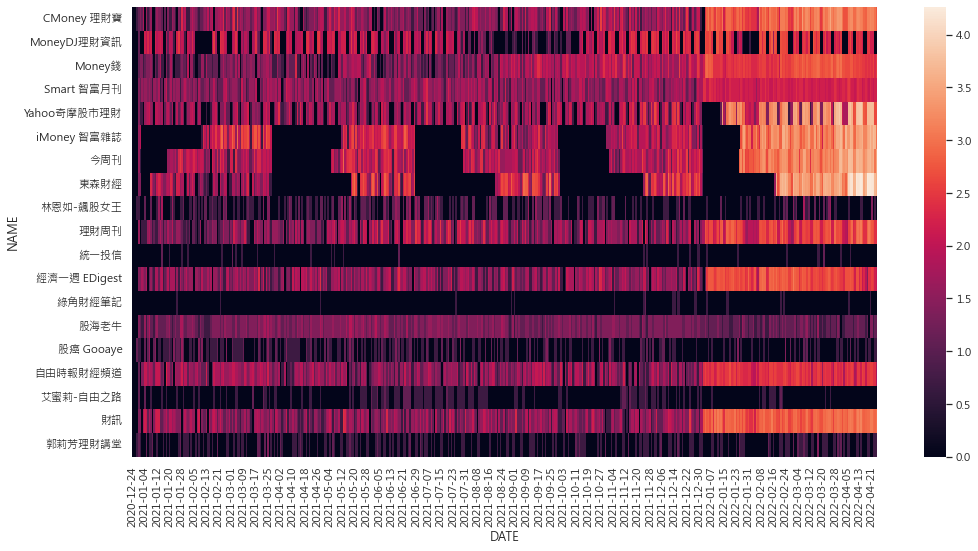

In [38]:
sns.heatmap(plotdf)

### 貼文數量與LIKE數 - scatter plot
- 初步檢視粉絲專頁的影響力

In [39]:
plotdf = df.groupby('NAME')['REACTION_COUNT'].describe()
plotdf

,count,mean,std,min,25%,50%,75%,max
NAME,,,,,,,,
CMoney 理財寶,3816.0,30.323637,85.697327,0.0,4.00,10.0,26.00,2776.0
MoneyDJ理財資訊,2571.0,46.003112,144.088870,0.0,14.00,22.0,36.00,3980.0
Money錢,3251.0,36.431867,129.228696,0.0,4.00,8.0,20.00,2420.0
Smart 智富月刊,2746.0,67.605972,109.488491,0.0,15.00,32.0,72.00,1564.0
Yahoo奇摩股市理財,3991.0,125.904535,519.289576,0.0,4.00,8.0,27.00,10406.0
iMoney 智富雜誌,4006.0,29.840739,111.361182,0.0,2.00,5.0,16.00,2516.0
今周刊,4018.0,352.826033,1232.865269,0.0,20.00,60.5,222.75,24171.0
東森財經,4132.0,912.792352,4466.912806,0.0,18.00,53.0,196.00,87487.0
林恩如-飆股女王,754.0,384.456233,258.692152,31.0,185.25,341.0,503.75,2476.0


<AxesSubplot:xlabel='count', ylabel='50%'>

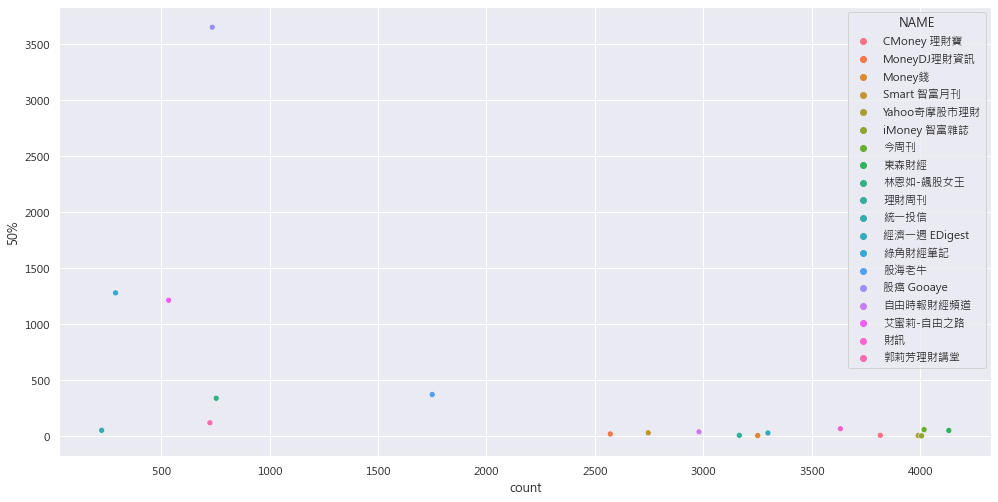

In [40]:
sns.scatterplot(x='count', y='50%', data=plotdf, hue='NAME')

### 貼文字數-Boxplot

In [41]:
# 不同粉絲頁的貼文字數
df['MESSAGE_LEN'] = df['MESSAGE'].apply(lambda x: len(x))
df.groupby('NAME')['MESSAGE_LEN'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
NAME,,,,,,,,,,,,,,
CMoney 理財寶,3816.0,85.304769,100.235835,7.0,29.0,35.0,40.0,45.0,52.0,61.0,74.0,101.0,176.5,1517.0
MoneyDJ理財資訊,2571.0,165.942046,77.678937,42.0,106.0,118.0,128.0,138.0,148.0,159.0,172.0,192.0,232.0,984.0
Money錢,3251.0,66.173485,66.706637,12.0,29.0,33.0,37.0,41.0,46.0,52.0,61.0,78.0,129.0,714.0
Smart 智富月刊,2746.0,82.153314,135.067375,3.0,9.5,13.0,17.0,22.0,29.0,40.0,57.0,101.0,244.5,1016.0
Yahoo奇摩股市理財,3991.0,41.077174,36.730517,3.0,16.0,22.0,26.0,30.0,33.0,37.0,41.0,48.0,63.0,388.0
iMoney 智富雜誌,4006.0,186.886420,169.056460,11.0,32.0,40.0,50.0,58.0,80.5,267.0,313.5,347.0,395.5,1547.0
今周刊,4018.0,104.460677,97.183880,6.0,30.0,40.0,49.0,61.0,72.0,87.0,106.0,152.0,224.0,982.0
東森財經,4132.0,56.958616,37.201721,9.0,25.0,28.0,35.0,52.0,56.0,59.0,62.0,68.0,93.0,511.0
林恩如-飆股女王,754.0,166.298408,167.218086,4.0,15.3,34.6,60.0,87.0,113.0,147.8,207.0,277.4,389.0,1696.0


<AxesSubplot:xlabel='MESSAGE_LEN', ylabel='NAME'>

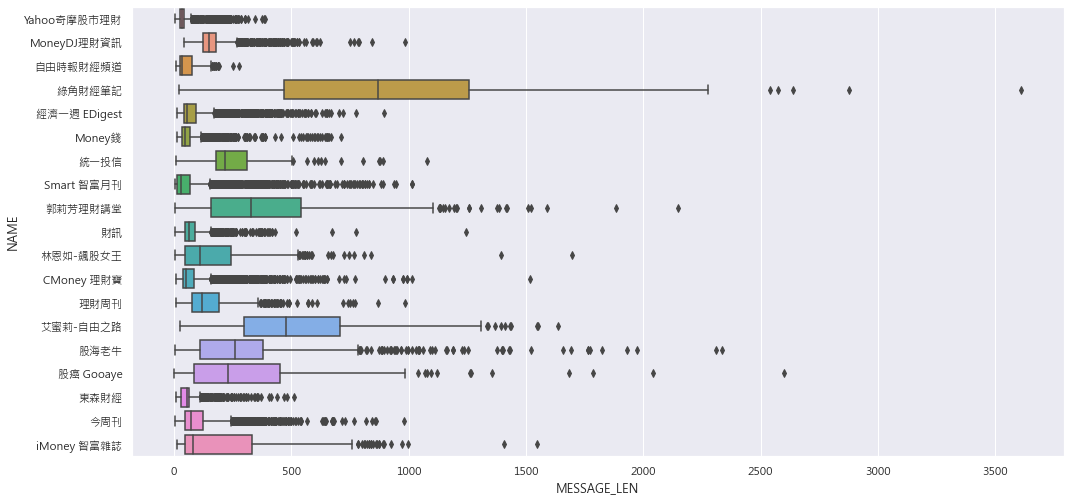

In [42]:
sns.boxplot(x='MESSAGE_LEN', y='NAME', data=df[['NAME', 'MESSAGE', 'MESSAGE_LEN']])

### 字數跟按讚數- Regplot, hue by name

In [43]:
plotdf = df[['NAME', 'MESSAGE_LEN', 'REACTION_COUNT']]
plotdf['MESSAGE_LEN'] = np.log(plotdf['MESSAGE_LEN'])
plotdf['REACTION_COUNT'] = np.log(plotdf['REACTION_COUNT'])
plotdf

/tmp/ipykernel_17160/1133643367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotdf['MESSAGE_LEN'] = np.log(plotdf['MESSAGE_LEN'])
/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_17160/1133643367.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotdf['REACTION_COUNT'] = np.log(plotdf['REACTION_COUNT'])


,NAME,MESSAGE_LEN,REACTION_COUNT
0,Yahoo奇摩股市理財,4.804021,2.995732
1,Yahoo奇摩股市理財,3.433987,1.386294
2,Yahoo奇摩股市理財,2.833213,2.995732
3,Yahoo奇摩股市理財,4.356709,0.693147
4,Yahoo奇摩股市理財,2.995732,4.394449
...,...,...,...
46618,東森財經,4.615121,3.367296
46619,東森財經,3.332205,5.105945
46620,東森財經,2.397895,1.791759
46621,東森財經,3.332205,4.158883


/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/numpy/lib/function_

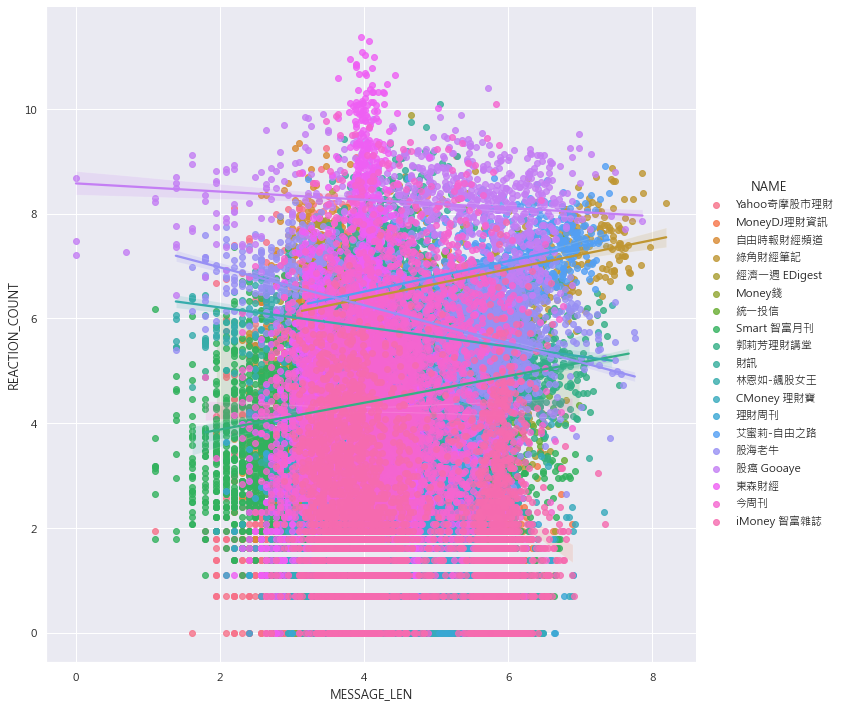

In [44]:
# sns.set(rc={'figure.figsize':(16, 16)})
sns.lmplot(x='MESSAGE_LEN', y='REACTION_COUNT', data = plotdf, hue='NAME', height=10)

### by小時的heatmap
- 透過這個分析可以知道爬蟲的時候要在什麼時間爬

In [45]:
plotdf = df[['NAME', 'HOUR']].groupby(['NAME', 'HOUR']).size().reset_index(name='COUNT')#.pivot('HOUR')
plotdf = plotdf.pivot(index='NAME', columns='HOUR', values='COUNT')
plotdf = plotdf.fillna(0)
plotdf

HOUR,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
NAME,,,,,,,,,,,,,,,,,,,,,
CMoney 理財寶,1.0,23.0,24.0,0.0,0.0,0.0,17.0,92.0,197.0,208.0,...,232.0,226.0,202.0,112.0,403.0,276.0,354.0,260.0,134.0,13.0
MoneyDJ理財資訊,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,25.0,229.0,...,197.0,193.0,197.0,179.0,197.0,219.0,243.0,114.0,20.0,2.0
Money錢,1.0,1.0,0.0,1.0,0.0,0.0,0.0,67.0,244.0,100.0,...,159.0,228.0,236.0,7.0,80.0,174.0,289.0,377.0,103.0,6.0
Smart 智富月刊,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,85.0,...,316.0,27.0,377.0,10.0,303.0,54.0,297.0,288.0,132.0,0.0
Yahoo奇摩股市理財,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,175.0,162.0,...,320.0,303.0,232.0,275.0,309.0,297.0,259.0,211.0,139.0,110.0
iMoney 智富雜誌,19.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,159.0,191.0,...,211.0,213.0,339.0,311.0,288.0,338.0,320.0,315.0,289.0,254.0
今周刊,3.0,0.0,1.0,0.0,0.0,0.0,2.0,70.0,178.0,236.0,...,307.0,271.0,246.0,274.0,272.0,273.0,253.0,245.0,241.0,114.0
東森財經,102.0,36.0,3.0,1.0,0.0,0.0,7.0,47.0,120.0,250.0,...,343.0,280.0,277.0,291.0,221.0,199.0,196.0,286.0,167.0,105.0
林恩如-飆股女王,13.0,8.0,0.0,0.0,0.0,0.0,0.0,3.0,31.0,54.0,...,43.0,35.0,36.0,88.0,48.0,36.0,82.0,70.0,27.0,28.0


<AxesSubplot:xlabel='HOUR', ylabel='NAME'>

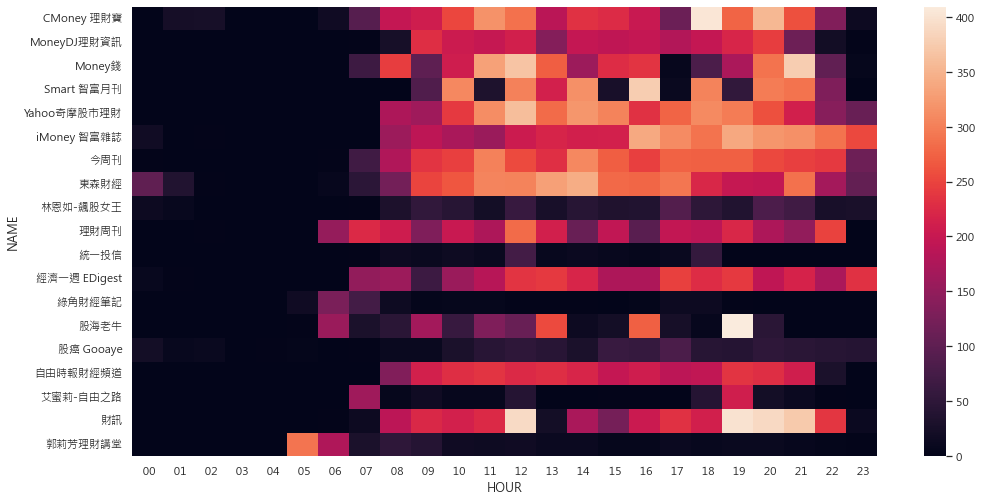

In [46]:
sns.heatmap(plotdf)

## 斷詞器

### 資料清理

In [47]:
stringliteral = 'https://www.yahoo.com.tw today'
re.sub(r'http\S+', '', stringliteral)

' today'

In [48]:
# remove http...
df['MESSAGE'] = df['MESSAGE'].apply(lambda x: re.sub(r'http\S+', '', x))

# remove illegal multibyte ex: ❓🤗⭕🤓🤔🤘🦁⭐🆗🆖🈲🤐🤗🤖🤑🆙⏩
df['MESSAGE'] = df['MESSAGE'].apply(lambda x: re.sub('[^\u4e00-\u9fa50-9A-Za-z\s+]', ' ', x))

# remove \n
df['MESSAGE'] = df['MESSAGE'].apply(lambda x: re.sub('\n', '', x))



# remove hash tag...
df['MESSAGE'] = df['MESSAGE'].apply(lambda x: re.sub(r'#\S+', '', x))

# remove multiplt \s
df['MESSAGE'] = df['MESSAGE'].apply(lambda x: re.sub('[\s+]{1,}', ' ', x))

### 手動新增
- jieba 的是詞庫是來自於1995年的人民日報訓練而得，一方面時間距今已久，另方面則是中國的語料庫，跟我們的習慣難免會不一樣，使用時可以適當的添加關鍵詞提升斷詞效果

In [50]:
sentence = df['MESSAGE'][9]
sentence

'今天的來賓陳啟祥 30歲才開始學投資 當時月薪不到4萬 慘賠掉數月薪水 之後他靠著3張圖表的選股 養股模式 即便結婚生子開銷變大 時間變少 也能夠創造穩定高報酬 5年總報酬率100 到底哪三張圖表如此神奇呢 另外 今天大佛有新單元喔 一起來看看 進擊的荷包 宅女小紅 李其展的外匯交易致勝兵法'

In [51]:
np.array(jieba.lcut(sentence))

array(['今天', '的', '來賓', '陳啟祥', ' ', '30', '歲', '才', '開始', '學', '投資', ' ',
       '當時', '月薪', '不到', '4', '萬', ' ', '慘賠', '掉', '數月', '薪水', ' ', '之後他',
       '靠', '著', '3', '張圖表', '的', '選股', ' ', '養股', '模式', ' ', '即便', '結',
       '婚生子', '開銷', '變大', ' ', '時間', '變少', ' ', '也', '能夠', '創造', '穩定',
       '高', '報酬', ' ', '5', '年', '總報', '酬率', '100', ' ', '到底', '哪三張',
       '圖表', '如此', '神奇', '呢', ' ', '另外', ' ', '今天', '大佛', '有', '新', '單元',
       '喔', ' ', '一起', '來', '看看', ' ', '進擊', '的', '荷包', ' ', '宅女', '小紅',
       ' ', '李其展', '的', '外匯', '交易', '致勝', '兵法'], dtype='<U3')

In [52]:
words = ['存股族', '資金', '瑞幸咖啡', '台中', '資產', '公開', '強強滾', '大盤', '覺得', '佈局', '宅女', '搶買', '投資', '上漲', '後悔', '房地產', 
         '以房養老', '留房養老', '殖利率', '佳世達', '公升', '無鉛汽油', '陳啟祥', '開始']
for word in words:
    jieba.add_word(word)

In [53]:
np.array(jieba.lcut(sentence))

array(['今天', '的', '來賓', '陳啟祥', ' ', '30', '歲', '才', '開始', '學', '投資', ' ',
       '當時', '月薪', '不到', '4', '萬', ' ', '慘賠', '掉', '數月', '薪水', ' ', '之後他',
       '靠', '著', '3', '張圖表', '的', '選股', ' ', '養股', '模式', ' ', '即便', '結',
       '婚生子', '開銷', '變大', ' ', '時間', '變少', ' ', '也', '能夠', '創造', '穩定',
       '高', '報酬', ' ', '5', '年', '總報', '酬率', '100', ' ', '到底', '哪三張',
       '圖表', '如此', '神奇', '呢', ' ', '另外', ' ', '今天', '大佛', '有', '新', '單元',
       '喔', ' ', '一起', '來', '看看', ' ', '進擊', '的', '荷包', ' ', '宅女', '小紅',
       ' ', '李其展', '的', '外匯', '交易', '致勝', '兵法'], dtype='<U3')

In [54]:
df['PROC_MESSAGE'] = df['MESSAGE'].apply(lambda x: jieba.lcut(x))
df.head(3)

,NAME,TIME,MESSAGE,POSTID,PAGEID,COMMENT_COUNT,REACTION_COUNT,SHARE_COUNT,DISPLAYCOMMENTCOUNT,CURSOR,...,ANGRY,SAD,WOW,CARE,UPDATETIME,DATE,YM,HOUR,MESSAGE_LEN,PROC_MESSAGE
0,Yahoo奇摩股市理財,2020-12-31 15:00:03,台積電 鴻海還會漲 分析師解答你的投資疑難雜症 今年台股強強滾 明年看好哪些股票 明年台股...,416134436394373,114062348679049,2,20,5,2,AQHRfs8JRAeBHCbxPU4mMYplDePhVnTkqQdyyA9HJ0ej2J...,...,0.0,0.0,0.0,1.0,2022-04-25 06:33:28,2020-12-31,2020-12,15,122,"[ , 台積電, , 鴻海, 還會漲, , 分析, 師, 解答, 你, 的, 投資, 疑..."
1,Yahoo奇摩股市理財,2021-01-11 14:31:09,大家覺得有搞頭嗎 統一超商 外送平台 foodomo,3612127648872484,114062348679049,0,4,2,0,AQHRb34oCZSJPBjb5G8WYlh5ZKOTZZI12LFvKCwpNaAR_F...,...,0.0,0.0,0.0,0.0,2022-04-25 06:33:28,2021-01-11,2021-01,14,31,"[大家, 覺得, 有, 搞頭, 嗎, , 統一, 超商, , 外送, 平台, , fo..."
2,Yahoo奇摩股市理財,2022-01-19 17:03:00,該抱股過年 專家點頭 1類型股可抱,4745502675534970,114062348679049,5,20,0,4,AQHRpxvmGF8QueeNeT75N7P1R5WCplvKlzjZxjMYSUc8T5...,...,0.0,0.0,0.0,0.0,2022-04-25 06:33:28,2022-01-19,2022-01,17,17,"[該, 抱, 股過, 年, , 專家, 點頭, , 1, 類型, 股, 可, 抱]"


In [55]:
for sent in df['PROC_MESSAGE'][:5]:
    print(sent)
    print('====')

[' ', '台積電', ' ', '鴻海', '還會漲', ' ', '分析', '師', '解答', '你', '的', '投資', '疑難', '雜症', ' ', '今年', '台股', '強強滾', ' ', '明年', '看好', '哪些', '股票', ' ', '明年', '台股', '展望', '如何', ' ', '拿到', '年', '終獎', '金', ' ', '可以', '投資', '到', '哪裡', '呢', ' ', '有', '任何', '投資', '問題', ' ', '分析', '師幫', '你', '解答', ' ', '有', '問題', '歡迎', '發問', '喔', ' ', '股市', '小葉問', ' ', '葉芷娟', ' ', '李其展', '的', '外匯', '交易', '致勝', '兵法']
====
['大家', '覺得', '有', '搞頭', '嗎', ' ', '統一', '超商', ' ', '外送', '平台', ' ', 'foodomo']
====
['該', '抱', '股過', '年', ' ', '專家', '點頭', ' ', '1', '類型', '股', '可', '抱']
====
['Gogoro', '透露', ' ', '2021', '年', '營收', '超越', '財測', '目標', ' ', '已向', '美國', '證管', '單位', '繳交', 'F', ' ', '4', '申請', '資料', ' ', '有望', '在', '2022', '年', '第一季', '於', '那斯達克', '掛牌', ' ', 'gogoro', ' ', '私募', ' ', '借殼', '上市']
====
['經理', '尾牙', '中', '5', '萬', '被', '拱', '捐出', '爆氣', ' ', '是', '要', '多', '貪', ' ']
====


### ngram

In [16]:
df['PROC_MESSAGE'] = df['MESSAGE'].apply(lambda x: re.sub('[^\u4e00-\u9fa5]', '', x))
count_vect = CountVectorizer(ngram_range=(2,5), analyzer='char', max_features=50) # analyzer{‘word’, ‘char’, ‘char_wb’} or callable, default=’word’
bow_rep = count_vect.fit_transform(df['PROC_MESSAGE'])
count_vect.vocabulary_.keys()

dict_keys(['台積', '積電', '分析', '的投', '投資', '今年', '台股', '股票', '可以', '股市', '台積電', '的投資', '大家', '美國', '中國', '一個', '開始', '時間', '自己', '怎麼', '理財', '市場', '股價', '還是', '知道', '可能', '因為', '什麼', '美股', '利率', '現在', '不是', '沒有', '指數', '我們', '更多', '台灣', '獲利', '產業', '公司', '經濟', '疫情', '全球', '就是', '一週', '濟一', '經濟一', '智富', '濟一週', '經濟一週'])

In [17]:
# for word in count_vect.vocabulary_.keys():
#     jieba.add_word(word)

## 情感分析

### 統計值法

In [73]:
fb_sent = df.groupby('DATE')[['LIKE', 'HAHA', 'LOVE', 'WOW', 'CARE', 'ANGRY', 'SAD']].sum()
fb_sent = fb_sent.reset_index()
fb_sent

,DATE,LIKE,HAHA,LOVE,WOW,CARE,ANGRY,SAD
0,2020-12-24,199.0,0.0,2.0,0.0,0.0,0.0,0.0
1,2020-12-28,1257.0,0.0,14.0,4.0,1.0,0.0,0.0
2,2020-12-29,3158.0,21.0,21.0,3.0,2.0,0.0,2.0
3,2020-12-30,9667.0,541.0,55.0,309.0,10.0,0.0,13.0
4,2020-12-31,14999.0,676.0,210.0,63.0,26.0,29.0,12.0
...,...,...,...,...,...,...,...,...
479,2022-04-20,99298.0,12725.0,634.0,2284.0,319.0,377.0,256.0
480,2022-04-21,77382.0,10099.0,1756.0,2456.0,1310.0,976.0,338.0
481,2022-04-22,73873.0,14978.0,1004.0,1189.0,553.0,820.0,1006.0
482,2022-04-23,68343.0,17408.0,564.0,478.0,173.0,108.0,120.0


In [74]:
os.mkdir('./data/fb_sent')
fb_sent.to_pickle('./data/fb_sent/fb_sent.pkl')
fb_sent.to_csv('./data/fb_sent/fb_sent.csv', index=False)

### 詞典法

#### 自定義關鍵詞
根據最常出現的詞來標資料即可

In [88]:
neg_words = ['跳空', '競爭', '懷疑', '庫存', '封城', '憂心']
pos_words = ['強勢', '傑出', '解決', '上漲']

In [89]:
def sent_score(sent, pos_words, neg_words):
    pos_score = 0
    neg_score = 0
    seg = jieba.lcut(sent)
    print(seg)
    for word in seg:
        if word in pos_words:
            pos_score = pos_score + 1
        if word in neg_words:
            neg_score = neg_score + 1
    return pos_score, neg_score

In [93]:
sentence = '台積電的股價強勢上漲但是上海的封城令人憂心'
sent_score(sent = sentence, pos_words=pos_words, neg_words=neg_words)

['台積電', '的', '股價', '強勢', '上漲', '但是', '上海', '的', '封城', '令人', '憂心']


(2, 2)

#### 情感詞庫
- 哈大: 
  - https://github.com/ZaneMuir/DLUT-Emotionontology
  - 情感语料库的构建和分析 徐琳宏 ,林鸿飞 ,赵 晶
- 台大情感詞庫
  - http://rportal.lib.ntnu.edu.tw/bitstream/20.500.12235/80604/1/ntnulib_ja_A1021_4401_024.pdf
  - https://www.rdocumentation.org/packages/tmcn/versions/0.2-13/topics/NTUSD
  - https://rdrr.io/rforge/tmcn/
- 缺點是通用的情感詞典無法適用特定的情境

In [57]:
# NTUSD
neg_words = pd.read_csv('./sent_dict/NTUSD_traditional/NTUSD_negative_unicode.txt', header=None)[0].to_list()
print(neg_words[:30])
print('=============')
pos_words = pd.read_csv('./sent_dict/NTUSD_traditional/NTUSD_positive_unicode.txt', header=None)[0].to_list()
print(pos_words[:30])

['一下子爆發', '一下子爆發的一連串', '一巴掌', '一再', '一再叮囑', '一拳', '一般殺人罪', '一陣狂風', '一陣緊張', '一掌', '一團糟', '一摑', '一點點', '一蹶不振', '人事不省', '人為', '人為的', '入迷', '入迷的', '入迷的人', '刀刃', '刁難', '力盡', '匕首', '下地獄', '下垂', '下垂度', '下流', '下流的', '下降']
['一帆風順', '一帆風順的', '一流', '一致', '一致的', '了不起', '了不起的', '了解', '人性', '人性的', '人格高尚', '人格高尚的', '人情', '人情味', '入神', '入神的', '入迷', '入迷的', '上好', '上好的', '上等', '上等的', '口頭通過', '大方', '大方的', '大無畏', '大無畏的', '大量的', '大膽', '大膽的']


In [58]:
# 大連理工大學
sentment_keywords = pd.read_excel('./sent_dict/情感词汇本体/情感词汇本体.xlsx')
sentment_keywords.groupby('情感分类').head(2)

,词语,词性种类,词义数,词义序号,情感分类,强度,极性,辅助情感分类,强度.1,极性.1,Unnamed: 10,Unnamed: 11
0,脏乱,adj,1.0,1.0,NN,7,2,NaN,NaN,NaN,NaN,NaN
1,糟报,adj,1.0,1.0,NN,5,2,NaN,NaN,NaN,NaN,NaN
2,早衰,adj,1.0,1.0,NE,5,2,NaN,NaN,NaN,NaN,NaN
5,战祸,noun,1.0,1.0,ND,5,2,NC,5.0,2.0,NaN,NaN
7,折辱,noun,1.0,1.0,NE,5,2,NN,5.0,2.0,NaN,NaN
9,清峻,adj,1.0,1.0,PH,5,0,NaN,NaN,NaN,NaN,NaN
10,清莹,adj,1.0,1.0,PH,5,1,NaN,NaN,NaN,NaN,NaN
18,瑞雪,noun,1.0,1.0,PA,5,1,NaN,NaN,NaN,NaN,NaN
19,擅名,noun,1.0,1.0,PD,7,1,NaN,NaN,NaN,NaN,NaN
20,神采,adj,1.0,1.0,PA,5,1,PH,1.0,1.0,NaN,NaN


In [61]:
sentence = ['我', '以為', '今天', '的', '天氣', '很好', '但', '現實', '給了我', '一拳']
sent_score(sent = sentence)

(1, 2)

### 套件法
- 英文的可以看NLTK
- 但是要留意準確度的問題，因為每個人要應用的場景不會完全相同

#### NLTK

In [94]:
# NLTK
sentence = '''
It was one of the worst movies I've seen, despite good reviews. 
Unbelievably bad acting!! Poor direction. VERY poor production. 
The movie was bad. Very bad movie. VERY bad movie. VERY BAD movie. VERY BAD movie!
'''
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(sentence)

{'neg': 0.609, 'neu': 0.391, 'pos': 0.0, 'compound': -0.9921}

#### SnowNLP

In [95]:
# SnowNLP
s = SnowNLP('這個東西真的很棒')
s.sentiments

0.8587303470185047

In [99]:
df2 =  df[['NAME', 'TIME', 'MESSAGE', 'POSTID', 'PAGEID']]
df2 = df2.loc[df2['MESSAGE'].apply(lambda x: len(x)>2)]
df2['SnowNLP_sent'] = df2['MESSAGE'].apply(lambda x: SnowNLP(x).sentiments)
df2

,NAME,TIME,MESSAGE,POSTID,PAGEID,SnowNLP_sent
0,Yahoo奇摩股市理財,2020-12-31 15:00:03,台積電 鴻海還會漲 分析師解答你的投資疑難雜症 今年台股強強滾 明年看好哪些股票 明年台股...,416134436394373,114062348679049,0.000114
1,Yahoo奇摩股市理財,2021-01-11 14:31:09,大家覺得有搞頭嗎 統一超商 外送平台 foodomo,3612127648872484,114062348679049,0.066293
2,Yahoo奇摩股市理財,2022-01-19 17:03:00,該抱股過年 專家點頭 1類型股可抱,4745502675534970,114062348679049,0.353155
3,Yahoo奇摩股市理財,2022-01-19 17:41:03,Gogoro透露 2021年營收超越財測目標 已向美國證管單位繳交F 4申請資料 有望在20...,4745763295508908,114062348679049,0.994499
4,Yahoo奇摩股市理財,2022-01-19 18:31:01,經理尾牙中5萬被拱捐出爆氣 是要多貪,4746300265455211,114062348679049,0.450188
...,...,...,...,...,...,...
46618,東森財經,2022-04-09 19:40:04,虎哩旺編 小漁村台灣鯛傳奇 產地到餐桌鮮送美味 進擊的台灣 國寶台灣鯛探秘 智能養殖味鮮肉...,4467036716731696,127254684043276,0.000002
46619,東森財經,2022-04-07 14:01:13,基隆讀大學 回屏東確診 網見悲劇足跡不捨狂喊 好孩子,4462254950543206,127254684043276,0.383345
46620,東森財經,2022-03-01 15:06:28,海編 戰爭何時能結束,4365558733546162,127254684043276,0.168029
46621,東森財經,2022-03-30 11:28:03,聯詠分紅傳上看50個月 破千萬 網驚 醫生會絕望嗎,4441083839326984,127254684043276,0.020881


In [100]:
os.mkdir('./data/snownlp_sent')
df2.to_pickle('./data/snownlp_sent/snownlp_sent.pkl')
df2.to_csv('./data/snownlp_sent/snownlp_sent.csv', index=False)

### 翻譯法
- https://translate-python.readthedocs.io/en/latest/

- https://fanyi.baidu.com/mtpe/#/editor/quickImport

In [104]:
translator= Translator(from_lang='zh-TW', to_lang='en')
translation = translator.translate("對的事情做，不對的事情不要做")
print(translation)

Do the right thing, don't do the wrong thing


In [36]:
translator= Translator(from_lang='zh-TW', to_lang='en')
translation = translator.translate("最困難的不是面對挫折打擊，最困難的是面對各種挫折打擊，卻沒有失去對人世的熱情")
print(translation)

The hardest part is not to fight against setbacks, the hardest part is to fight all kinds of setbacks without losing enthusiasm for the world.


In [105]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores(translation)

{'neg': 0.0, 'neu': 0.758, 'pos': 0.242, 'compound': 0.3724}

### deepl
- https://www.deepl.com/translator

In [71]:
# os.mkdir('./data/deepl')
# df2 = df.loc[df['MESSAGE_LEN']>=10]
# df2 = df2[['NAME', 'TIME', 'MESSAGE', 'POSTID', 'PAGEID']].groupby('NAME').sample(100)
# print(df2.shape)
# df2.to_excel('./data/deepl/deeplaa.xlsx', index=False)

In [108]:
df2['MESSAGE_EN']

0       Recently, both the U.S. and Taiwan's technolog...
1        81XX volume exploded to a record high closing...
2        Unless you are an immortal and can guess the ...
3        News: Foreign investors turned from selling t...
4        The large retail investors are buying togethe...
                              ...                        
1893     The following text is reposted from Lei Qiu L...
1894     The new pension system for public employees w...
1895    It's really an up and down situation, the doll...
1896    It is only in the heart that one can see right...
1897    Happy April Fool's Day! Do you think this even...
Name: MESSAGE_EN, Length: 1898, dtype: object

In [124]:
df2 = pd.read_excel('./data/deepl/deepl.xlsx')
df2['DEEPL_SENT'] = df2['MESSAGE_EN'].apply(lambda x: sia.polarity_scores(x))
df2['POS'] = df2['DEEPL_SENT'].apply(lambda x: x['pos'])
df2['NEU'] = df2['DEEPL_SENT'].apply(lambda x: x['neu'])
df2['NEG'] = df2['DEEPL_SENT'].apply(lambda x: x['neg'])
df2.head(10)
# df2['DEEPL_SENT2'] = np.select(condlist = , choicelist)

,NAME,TIME,MESSAGE,POSTID,PAGEID,MESSAGE_EN,DEEPL_SENT,POS,NEU,NEG
0,CMoney 理財寶,2021-03-19 07:00:40,近期 不論是美國還是台灣的 科技股都下跌了不少 但從數據回測 還是有機會讓 小資族 快速存好...,4058398430907687,104121653002071,"Recently, both the U.S. and Taiwan's technolog...","{'neg': 0.042, 'neu': 0.678, 'pos': 0.28, 'com...",0.280,0.678,0.042
1,CMoney 理財寶,2022-04-13 21:15:06,81XX 成交量爆歷史高收十字線 明天走勢會,5268325189914999,104121653002071,81XX volume exploded to a record high closing...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000
2,CMoney 理財寶,2021-12-10 10:00:00,不敗教主陳重銘 股海在走 知識真的要有 除非你是神仙 可以猜中股價的高低點 不然就乖乖跟我...,4857623530985169,104121653002071,Unless you are an immortal and can guess the ...,"{'neg': 0.069, 'neu': 0.731, 'pos': 0.2, 'comp...",0.200,0.731,0.069
3,CMoney 理財寶,2022-01-20 10:30:14,快訊 外資今日轉賣為買 24XX 開盤跳空上漲 大戶持續買超中 你還沒跟上,5016857888395065,104121653002071,News: Foreign investors turned from selling t...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000
4,CMoney 理財寶,2022-04-15 10:15:26,快訊 受惠疫情加劇 他 大戶散戶合力買 跳空大漲逾8 直攻漲停,5272520269495491,104121653002071,The large retail investors are buying togethe...,"{'neg': 0.155, 'neu': 0.845, 'pos': 0.0, 'comp...",0.000,0.845,0.155
5,CMoney 理財寶,2021-04-17 12:30:32,定存 跟 儲蓄險 在低利率時代裡 已經是行不通的投資策略了 是時候把眼光放在 特別股 上了 ...,4139429652804564,104121653002071,Fixed deposits and savings insurance are no lo...,"{'neg': 0.139, 'neu': 0.677, 'pos': 0.184, 'co...",0.184,0.677,0.139
6,CMoney 理財寶,2021-09-02 19:00:10,K線多方型態 最終篇 完整版在這裡 大家期待已久的K棒多方型態終於完整的交給大家了 前面的...,4550401238374068,104121653002071,K-line Multi-party Patterns The complete vers...,"{'neg': 0.052, 'neu': 0.837, 'pos': 0.111, 'co...",0.111,0.837,0.052
7,CMoney 理財寶,2021-11-05 20:30:06,研究報告 緯創 3231 伺服器 車用營收將提高 產品組合優化帶動毛利率提升緯創以商用型P...,4738184682929055,104121653002071,Research Report Wistron 3231 Server Automotiv...,"{'neg': 0.062, 'neu': 0.81, 'pos': 0.128, 'com...",0.128,0.810,0.062
8,CMoney 理財寶,2021-06-22 19:30:50,葉黃素為何對我們很重要 除了維持晶亮外也要好好保護 一天一粒 晶采人生就是現在 現在 WFH...,4340403569373837,104121653002071,Why is lutein important to us? Besides maintai...,"{'neg': 0.0, 'neu': 0.664, 'pos': 0.336, 'comp...",0.336,0.664,0.000
9,CMoney 理財寶,2022-04-03 12:30:01,疫情以來 汽車供不應求 是不是新商機呢,5217460438334808,104121653002071,"Since the epidemic, there is a shortage of car...","{'neg': 0.127, 'neu': 0.696, 'pos': 0.177, 'co...",0.177,0.696,0.127


In [125]:
df2[['POS', 'NEU', 'NEG']].idxmax(axis=1).value_counts()

NEU    1882
POS      13
NEG       2
dtype: int64

In [126]:
df2[['POS', 'NEG']].idxmax(axis=1).value_counts()

POS    1453
NEG     444
dtype: int64

In [127]:
df2.to_pickle('./data/deepl/deepl_nltk_sent.pkl')
df2.to_csv('./data/deepl/deepl_nltk_sent.csv', index=False)

### 爬蟲法
- https://ai.baidu.com/tech/nlp_apply/sentiment_classify
- 註冊帳號可以體驗xx次，註冊時記得切換成英文模式才能用各國的手機號碼註冊
- 次数包售卖方式低至15元/万次
- Baidu
- Wiser AI Lab
- 騰訊
- Google

In [72]:
# wiser ai lab
url = 'https://www.wisers.ai/?api=ailab-demo-apilb.wisers.com:8000/senti/api/processtext'
data = {'text':'遭標普降評 俄瀕臨百年首見違約、威脅要告上法院',
        'model':'dl',
        'output_level':'subject',
        'show_scores':'true'}
resp = requests.post(url, json=data) 
resp.json()

{'docid': None,
 'is_successful': True,
 'message': '',
 'overall_res': {'sentiment': -1, 'sentiment_score': 0},
 'detail_res': []}

In [37]:
# Baidu 
url = 'https://ai.baidu.com/aidemo'
data = {'apiType': 'nlp', 
        'type': 'sentimentClassify',
        't1': '配置頂級，不解釋，手機需要的各個方面都很完美'}
headers = {'Referer': 'https://ai.baidu.com/tech/nlp_apply/sentiment_classify'}
resp = requests.post(url, data=data, headers=headers) 
resp.json()

{'errno': 0,
 'msg': 'success',
 'data': {'log_id': '5423058071869545976',
  'text': '配置頂級，不解釋，手機需要的各個方面都很完美',
  'items': [{'positive_prob': 0.99923,
    'confidence': 0.998289,
    'negative_prob': 0.000770009,
    'sentiment': 2}]}}

### 借模型法
- 百度: https://console.bce.baidu.com/ai/?_=1650861631579&fromai=1#/ai/nlp/app/list

In [128]:
# !pip install baidu-aip
from aip import AipNlp
APP_ID = '25938061'
API_KEY = 'UzqA7VEKAsuHK5GOxvgRmFuM'
SECRET_KEY = 'xxxxxxxxxxxxxxxxxx'

In [39]:
client = AipNlp(appId = APP_ID, apiKey=API_KEY, secretKey=SECRET_KEY)
text = '對的事情做，不對的事情不要做'
client.sentimentClassify(text)
client.emotion(text)

{'items': [{'prob': 0.999936,
   'label': 'neutral',
   'subitems': [],
   'replies': []},
  {'prob': 6.36578e-05, 'label': 'pessimistic', 'subitems': [], 'replies': []},
  {'prob': 4.43924e-07, 'label': 'optimistic', 'subitems': [], 'replies': []}],
 'text': '對的事情做，不對的事情不要做',
 'log_id': 1518456556531984481}

In [63]:
client = AipNlp(appId = APP_ID, apiKey=API_KEY, secretKey=SECRET_KEY)
text = '台積電 鴻海還會漲 分析師解答你的投資疑難雜症 今年台股強強滾'
client.sentimentClassify(text)

{'log_id': 1850001051978332025,
 'text': '台積電 鴻海還會漲 分析師解答你的投資疑難雜症 今年台股強強滾',
 'items': [{'positive_prob': 0.155846,
   'confidence': 0.653674,
   'negative_prob': 0.844154,
   'sentiment': 0}]}

In [104]:
df2 = df.loc[df['MESSAGE_LEN']>=10]
df2 = df2[['NAME', 'TIME', 'MESSAGE', 'POSTID', 'PAGEID']].groupby('NAME').sample(200)
print(df2.shape)
df2

(3800, 5)


,NAME,TIME,MESSAGE,POSTID,PAGEID
25097,CMoney 理財寶,2021-06-09 20:00:03,最近疫情嚴峻 股市也撲朔迷離 有些產業不受疫情影響低調發財 算利教官今晚20 00的免費直播...,830635874219566,104121653002071
24562,CMoney 理財寶,2022-02-22 11:00:02,TikTok 短影音 已在年輕族群掀起風潮 臉書面對年輕用戶外流 該如何止血,5128098330604353,104121653002071
25463,CMoney 理財寶,2022-01-05 13:30:00,元宇宙 一詞橫空出世 是否還有甜頭可嘗 台股之中 有哪些標的受惠,4960183120729209,104121653002071
24028,CMoney 理財寶,2021-08-06 21:00:32,巴菲特說他會把 90 遺產拿去投資 指數型基金 因為這會比放在他自己公司還要好,4469199553160904,104121653002071
26060,CMoney 理財寶,2021-01-29 18:50:28,GameStopk重挫 四大指數反彈收紅外資賣超346億 加權翻黑失守頸線2檔外資逆勢連買成...,3931130763634455,104121653002071
...,...,...,...,...,...
19176,郭莉芳理財講堂,2021-04-02 17:47:39,,3203700379732272,633488343420168
19613,郭莉芳理財講堂,2022-01-17 05:45:00,,4072146532887648,633488343420168
19512,郭莉芳理財講堂,2021-11-26 06:17:41,,3900208846748085,633488343420168
19726,郭莉芳理財講堂,2022-03-30 11:53:21,,4308859205883045,633488343420168


In [106]:
from tqdm import tqdm
import time
# os.mkdir('./data/baidu_sent')
with open('./data/baidu_sent/baidu_sent.txt', mode='a') as f:
    for post, message in tqdm(zip(df2['POSTID'], df2['MESSAGE'])):
        try:
            time.sleep(1)
            sent = client.sentimentClassify(message)
            f.write('{}||||{}||||{}\n'.format(post, message, sent))
        except:
            print(post, message)

1477it [32:27,  1.31s/it]Exception ignored in: <function tqdm.__del__ at 0x7f7f665c08b0>
Traceback (most recent call last):
  File "/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/tqdm/std.py", line 1281, in close
    if self.disable:
AttributeError: 'tqdm' object has no attribute 'disable'
2770it [1:00:50,  2.03s/it]

1538865529791081 我買的股票當下看有點貴 但現在又是怨嘆真的買太少 


3800it [1:23:38,  1.32s/it]


In [152]:
df2 = pd.read_table('./data/baidu_sent/daidu_sent.txt',sep=r'\|\|\|\|', names =['POSTID', 'MESSAGE', 'BAIDU_SENT'])
df2 = df2.loc[df2['MESSAGE'].notnull()]# dropduplicated
df2 = df2.loc[df2['MESSAGE']!=' ']
df2 = df2.loc[df2['BAIDU_SENT'].apply(lambda x: 'error'  not in x)]
df2['POS'] = df2['BAIDU_SENT'].apply(lambda x: eval(x)['items'][0]['positive_prob'])
df2['NEU'] = df2['BAIDU_SENT'].apply(lambda x: eval(x)['items'][0]['negative_prob'])
df2

/tmp/ipykernel_17160/2826576101.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df2 = pd.read_table('./data/baidu_sent/daidu_sent.txt',sep=r'\|\|\|\|', names =['POSTID', 'MESSAGE', 'BAIDU_SENT'])


,POSTID,MESSAGE,BAIDU_SENT,POS,NEU
0,4058373284243535,談加薪 總是弄得戰戰兢兢 千萬別用 缺錢 個人開銷大 作為加薪理由 資方可不吃情感勒索這套,"{'log_id': 7395251777801488185, 'text': '談加薪 總...",0.012472,0.987528
1,3924600430954155,庫存偏低 供貨縮減 DRAM 現貨近日價格全面急漲 法人看好 南亞科 2408 等 4 檔今...,"{'log_id': 9199660420116662489, 'text': '庫存偏低 ...",0.197054,0.802946
2,5249051811842337,從老闆角度看 不願意提供員工高薪的原因很簡單 就是不值得為產值不高的員工付出更高的薪水 也就...,"{'log_id': 6165989481510872313, 'text': '從老闆角度...",0.001304,0.998696
3,3990574971023367,原來 一毛不剩 才是最棒的存錢法,"{'log_id': 900001594243844281, 'text': '原來 一毛不...",0.528559,0.471441
4,5236154306465421,投資股票 不想再繳學費 先看懂均線 用 4 招判斷買賣點 股市震盪也不怕獲利,"{'log_id': 8492072477475299993, 'text': '投資股票 ...",0.040230,0.959770
...,...,...,...,...,...
4574,4191908367578130,上周五 六分別帶了兩門課 一堂是針對部門內的Team building 部門6人 年資由資深...,"{'log_id': 2914160868050941465, 'text': '上周五 六...",0.926172,0.073828
4576,3058542157581429,資產配置不是印在DM上的 只是 知道 不代表 做到 貪婪時 恐懼 就被拋在後頭了,"{'log_id': 926984969726398969, 'text': '資產配置不是...",0.011572,0.988428
4577,2966601273442185,給我企業發揮的舞台 還能讓我可以維持螢光幕前財經依晨 幕後財經講師的身分 真的是萬分感恩 ...,"{'log_id': 7161279920613781465, 'text': '給我企業發...",0.999796,0.000204
4579,3289847631117546,這篇文章說明了為何我幾乎從不排隊的主因 只要是排隊店 我就,"{'log_id': 5515243780506832249, 'text': '這篇文章說...",0.431824,0.568176


In [153]:
df2.to_pickle('./data/baidu_sent/baidu_sent_proc.pkl')
df2.to_csv('./data/baidu_sent/baidu_sent_proc.csv', index=False)

### 模型法
- 收集資料 >> 標註資料 >> 訓練模型 >> 效度 >> 
- Key point: How to label data?

#### Label

In [ ]:
## 1=正向，-1=負向， 混合或其他的貼文就 0, 
sent_df = []
pos_cnt = 0
neg_cnt = 0
while True:
    print('Progess >> positive count: {}/10, negative count: {}/10'.format(pos_cnt, neg_cnt))
    rand = np.random.choice(df.shape[0])
    print(df['NAME'][rand])
    print(df['MESSAGE'][rand])
    sent = input('Sentiment Score: ')
    if sent == '1':
        sent_df.append([df['PROC_MESSAGE'][rand], sent])
        pos_cnt = pos_cnt + 1
        print(pos_cnt)
    if sent == '2':
        sent_df.append([df['PROC_MESSAGE'][rand], sent])
        neg_cnt = neg_cnt + 1
    if pos_cnt >= 10 & neg_cnt >= 10:
        break
    clear_output()
sent_df = pd.DataFrame(sent_df, columns=['PROC_MESSAGE', 'SENTIMENT'])
sent_df

#### Model building: sample
- label 資料非常少很辛苦，改借用別的資料集
- https://spacy.io/api/cli#download
- https://spacy.io/usage/models#download-pip

In [39]:
sent_df = pd.read_excel('./data/GooglePlay_Comments.xlsx')
sent_df['SENTIMENT'] = sent_df['Sentimen'].apply(lambda x: int(re.findall('[0-9]{1,}', x)[0]))
sent_df['SENTIMENT2'] = np.select(condlist = [sent_df['SENTIMENT']>=4, sent_df['SENTIMENT']<=2, sent_df['SENTIMENT']==3], 
                                  choicelist = ['pos', 'neg', 'neu'])
sent_df

,Unnamed: 0,Name,Timestamp,Content,Sentimen,likecounts,SENTIMENT,SENTIMENT2
0,0,李宗翰,2020年6月29日,不錯,獲評為 5 顆星 (滿分 5 顆星),0,5,pos
1,1,Ning Hsu,2020年6月29日,已經等了有一週了，還沒收到退費的簡訊通知，若我到銀行確認並無退費，那我會尋求法律幫助。（20...,獲評為 1 顆星 (滿分 5 顆星),13,1,neg
2,2,宋佳宸,2020年6月29日,還不錯，挺方便的,獲評為 5 顆星 (滿分 5 顆星),0,5,pos
3,3,翁嘉雯,2020年6月29日,好,獲評為 5 顆星 (滿分 5 顆星),0,5,pos
4,4,蔡曜安,2020年6月29日,系統說外送員還在路上，但是實際上卻已經到了，讓外送員等我下樓真的很不好意思！,獲評為 2 顆星 (滿分 5 顆星),0,2,neg
...,...,...,...,...,...,...,...,...
2795,2795,曾小倩,2020年5月26日,越來越爛 這兩個月就遇到三次訂單問題 1.之前訂購兩張訂單，有一張訂單店家根本沒收到，白白等...,獲評為 1 顆星 (滿分 5 顆星),123,1,neg
2796,2796,Dino Leong,2020年5月26日,送餐常出错: 1. 东西少送或送错人。 2. 送餐员要求小费。 3. 餐卷常不能用。 4. ...,獲評為 3 顆星 (滿分 5 顆星),0,3,neu
2797,2797,鬥魚寶寶,2020年5月26日,不錯,獲評為 5 顆星 (滿分 5 顆星),0,5,pos
2798,2798,郭咚咚,2020年5月26日,速度快，讚,獲評為 5 顆星 (滿分 5 顆星),0,5,pos


In [40]:
# pip install -U spacy
# python -m spacy download zh_core_web_md
import spacy
from sklearn import svm
nlp = spacy.load('zh_core_web_md')

/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
train_x_vectors = [nlp(text).vector for text in sent_df['Content']]

clf_svm = svm.SVC(kernel='linear')

clf_svm.fit(train_x_vectors, sent_df['SENTIMENT2'])

SVC(kernel='linear')

In [42]:
test_x = ['還不錯，挺方便的', 
          '外送員真的很棒很用心，食物到手上的時候還是熱的',
          '不錯',          
          '我覺得表現一般，跟對手的表現都一樣',
          '外送員的表現真的很優秀，把湯的灑到處都是',
          '真的很有效率耶，東西送到的時候都冷掉了',
          '有些外送員會擺臭臉，真的是沒禮貌',]
test_x_vectors = [nlp(text).vector for text in test_x]
clf_svm.predict(test_x_vectors)

array(['pos', 'pos', 'pos', 'neg', 'neg', 'neg', 'neu'], dtype=object)

## EDA2

### 看情感分數變化
異常低/高的時候是不是有特殊的事件發生!

In [43]:
sentiment_df = df.loc[df['DATE']>='2022-01-01']
sentiment_df = sentiment_df.groupby('DATE')[['LIKE', 'HAHA', 'LOVE', 'WOW', 'CARE', 'ANGRY', 'SAD']].sum()

std = StandardScaler()
sentiment_df = pd.DataFrame(std.fit_transform(sentiment_df), columns = sentiment_df.columns, index=sentiment_df.index)
sentiment_df

,LIKE,HAHA,LOVE,WOW,CARE,ANGRY,SAD
DATE,,,,,,,
2022-01-01,-1.293512,-0.820505,-0.452217,-0.372169,-0.778330,-0.339479,-0.441019
2022-01-02,-0.979970,-0.852377,-0.423711,-0.777722,-0.677894,-0.342926,-0.462127
2022-01-03,-0.660350,-0.723815,-0.397920,-0.663685,-0.627677,-0.337756,-0.452746
2022-01-04,-0.259985,-0.692212,-0.320999,-0.672519,-0.612611,-0.358435,-0.432811
2022-01-05,-0.677225,-0.790247,-0.401993,-0.637184,-0.630187,-0.358435,-0.398804
...,...,...,...,...,...,...,...
2022-04-18,1.944603,3.568214,-0.152678,0.885449,1.639653,0.641047,3.854382
2022-04-19,0.301959,-0.347543,0.062700,0.649345,0.306373,-0.067207,0.522895
2022-04-20,0.614941,0.270926,-0.268965,0.642117,-0.215891,0.205066,-0.212354


In [44]:
sentiment_df_stk = sentiment_df[['LIKE', 'HAHA', 'LOVE', 'WOW', 'CARE', 'ANGRY', 'SAD']].stack().reset_index()
sentiment_df_stk.columns = ['DATE', 'REACTION_TYPE', 'ZSCORE']
sentiment_df_stk['DATE'] = sentiment_df_stk['DATE'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
sentiment_df_stk

,DATE,REACTION_TYPE,ZSCORE
0,2022-01-01,LIKE,-1.293512
1,2022-01-01,HAHA,-0.820505
2,2022-01-01,LOVE,-0.452217
3,2022-01-01,WOW,-0.372169
4,2022-01-01,CARE,-0.778330
...,...,...,...
779,2022-04-22,LOVE,-0.478461
780,2022-04-22,WOW,-0.903805
781,2022-04-22,CARE,-0.818504
782,2022-04-22,ANGRY,-0.387730


<AxesSubplot:xlabel='DATE', ylabel='ZSCORE'>

/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


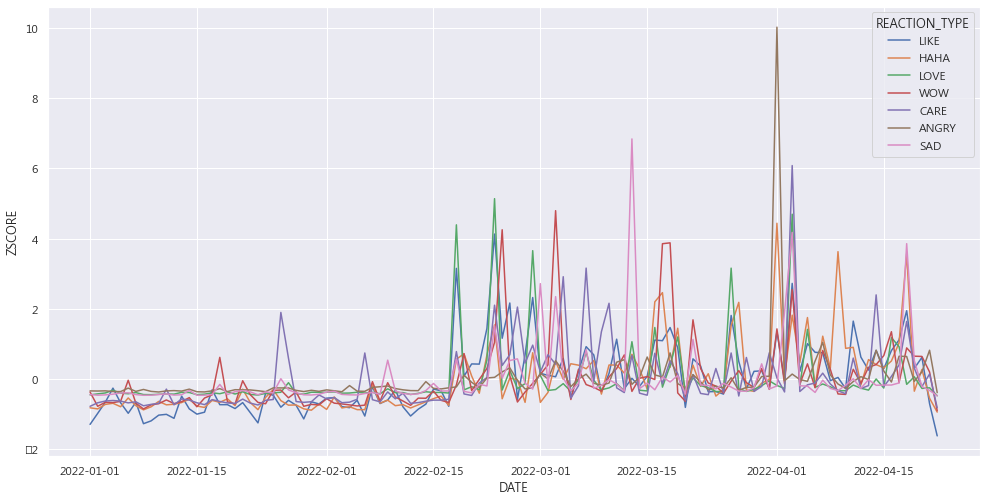

In [45]:
sns.set(rc={'figure.figsize':(16.7,8.27)})
sns.lineplot(x = 'DATE', y='ZSCORE', data=sentiment_df_stk, hue='REACTION_TYPE')

In [47]:
# 到底為什麼這麼Angry，Sad??
sentiment_df_stk.sort_values(['REACTION_TYPE', 'ZSCORE'], ascending= [True, False]).groupby('REACTION_TYPE').head(5)

,DATE,REACTION_TYPE,ZSCORE
635,2022-04-01,ANGRY,10.020670
677,2022-04-07,ANGRY,1.042563
726,2022-04-14,ANGRY,0.818541
775,2022-04-21,ANGRY,0.818541
537,2022-03-18,ANGRY,0.742719
648,2022-04-03,CARE,6.078899
459,2022-03-07,CARE,3.158739
438,2022-03-04,CARE,2.912672
725,2022-04-14,CARE,2.395430
480,2022-03-10,CARE,2.156896


In [63]:
# sentiment_df_stk.sort_values(['REACTION_TYPE', 'CNT'], ascending= [True, True]).groupby('REACTION_TYPE').head(5)

In [48]:
df.sort_values('ANGRY', ascending=False).head(2)

,NAME,TIME,MESSAGE,POSTID,PAGEID,COMMENT_COUNT,REACTION_COUNT,SHARE_COUNT,DISPLAYCOMMENTCOUNT,CURSOR,...,ANGRY,SAD,WOW,CARE,UPDATETIME,DATE,YM,HOUR,MESSAGE_LEN,PROC_MESSAGE
41086,東森財經,2022-04-01 00:51:13,TACO編：比賽車比不過就比國力？\n杰尼龜嗆大陸就是規則！2min猛罵台友狂勸別衝動\n\...,4445191822249519,127254684043276,11617,30410,1228,9844,AQHReW6t-bEcSSW5wgvml5wQyfEokIlNVm2D9tk0KVHtwH...,...,5715,64,218,114,2022-04-21 23:32:30,2022-04-01,2022-04,00,62,"[TACO, 編, ：, 比賽車, 比不過, 就, 比國力, ？, \n, 杰尼龜, 嗆, ..."
11511,今周刊,2021-12-18 00:42:59,快訊！時隔2天的週五（12/17）深夜11點多，王力宏太太李靚蕾在IG上發了一則5000字長...,10159736513223270,158025223269,1272,11590,853,952,AQHRGyW4E-WxmNPfK0lvH1nHlmJL6CCB3FhiASrC9snpf9...,...,1267,288,1331,172,2022-04-22 03:14:38,2021-12-18,2021-12,00,103,"[快訊, ！, 時隔, 2, 天, 的, 週五, （, 12, /, 17, ）, 深夜, ..."


In [49]:
df.sort_values('SAD', ascending=False).head(2)

,NAME,TIME,MESSAGE,POSTID,PAGEID,COMMENT_COUNT,REACTION_COUNT,SHARE_COUNT,DISPLAYCOMMENTCOUNT,CURSOR,...,ANGRY,SAD,WOW,CARE,UPDATETIME,DATE,YM,HOUR,MESSAGE_LEN,PROC_MESSAGE
40660,東森財經,2022-03-13 09:45:00,愛在身編：心疼...既然選擇了牠就請伴牠一生！\n年邁阿金走不動遭棄！暖男照料50天助尊嚴離...,4396009263834442,127254684043276,622,18621,794,580,AQHRp7uXXruIru3yBKYJO-mj2TwQxllFN6vWz_Lyj_t0e3...,...,42,6010,20,474,2022-04-21 23:32:30,2022-03-13,2022-03,09,64,"[愛在, 身編, ：, 心疼, ..., 既然, 選擇, 了, 牠, 就, 請, 伴, 牠,..."
41048,東森財經,2022-04-03 13:45:03,貓貓編：看著牠的眼睛怎麼捨得傷害牠？\n230kg巨龜卡漁網重傷！有靈性溫馴等救援結局淚\n...,4449677535134281,127254684043276,122,15264,298,113,AQHRzexglUEx3HxxzDTO48sOv8l-FSxsrLL_Iz0C9l3cau...,...,14,3634,121,2003,2022-04-21 23:32:30,2022-04-03,2022-04,13,58,"[貓貓編, ：, 看著, 牠, 的, 眼睛, 怎麼, 捨, 得, 傷害, 牠, ？, \n,..."


In [50]:
df.sort_values('WOW', ascending=False).head(2)

,NAME,TIME,MESSAGE,POSTID,PAGEID,COMMENT_COUNT,REACTION_COUNT,SHARE_COUNT,DISPLAYCOMMENTCOUNT,CURSOR,...,ANGRY,SAD,WOW,CARE,UPDATETIME,DATE,YM,HOUR,MESSAGE_LEN,PROC_MESSAGE
40459,東森財經,2022-03-18 20:45:00,真嗣拿你沒辦法編：糯米你還有什麼不會的🤣\n聰明汪教科書式顧娃！弟球掉水池1招驚險救\n\n...,4410863479015687,127254684043276,2796,43821,3131,2384,AQHRaMfLkNHpZpo_xmgIrAl-98ZPw1AAnUHEhgdfgvjA9J...,...,11,13,4580,109,2022-04-21 23:32:30,2022-03-18,2022-03,20,55,"[真嗣, 拿, 你, 沒辦, 法編, ：, 糯米, 你, 還有, 什麼, 不會, 的, 🤣,..."
45768,東森財經,2022-02-24 10:45:41,太陽打從西編：大家真的要小心自己的隨身物品ㄟ\n正妹腳邊行李1秒消失！他3動作連偷震驚百萬人...,4349243101844392,127254684043276,708,17459,4730,545,AQHRNCVSjplMcS5nbRj7Keiw1RuesGIlYiOlP8S33_z4i3...,...,120,31,4525,20,2022-04-14 07:37:44,2022-02-24,2022-02,10,55,"[太陽, 打, 從, 西編, ：, 大家, 真的, 要, 小心, 自己, 的, 隨身, 物品..."


In [51]:
df.sort_values('HAHA', ascending=False).head(2)

,NAME,TIME,MESSAGE,POSTID,PAGEID,COMMENT_COUNT,REACTION_COUNT,SHARE_COUNT,DISPLAYCOMMENTCOUNT,CURSOR,...,ANGRY,SAD,WOW,CARE,UPDATETIME,DATE,YM,HOUR,MESSAGE_LEN,PROC_MESSAGE
41347,東森財經,2022-04-09 18:45:01,在權志龍身編：真的是辛苦了～\n醫護爆笑催做核酸！喊下樓免化妝：這沒彭于晏\n\n影片來源：抖音,4467800656655302,127254684043276,4277,56893,9799,3169,AQHRHd2lR10H5pJ4hQBOSg4-Lz0iqDSqbkuTwjucJCN8q7...,...,18,17,90,85,2022-04-21 23:32:30,2022-04-09,2022-04,18,45,"[在, 權志龍, 身編, ：, 真的, 是, 辛苦, 了, ～, \n, 醫護, 爆笑, 催..."
41242,東森財經,2022-04-01 20:45:00,大編：這確定沒有先全麻過嗎？\n睡死汪遭飼主偷餵藥！拉舌倒粉牠全程無感\n\n影片來源：初壹...,4447061035395931,127254684043276,3129,51525,2264,2477,AQHRPVt8yv_IspSsdjC1DFM-Lef2saP_dtb1dKCmXY4p-9...,...,19,7,319,46,2022-04-21 23:32:30,2022-04-01,2022-04,20,49,"[大編, ：, 這確定, 沒有, 先, 全麻, 過嗎, ？, \n, 睡死, 汪遭, 飼主偷..."


In [52]:
df.sort_values('LIKE', ascending=False).head(2)

,NAME,TIME,MESSAGE,POSTID,PAGEID,COMMENT_COUNT,REACTION_COUNT,SHARE_COUNT,DISPLAYCOMMENTCOUNT,CURSOR,...,ANGRY,SAD,WOW,CARE,UPDATETIME,DATE,YM,HOUR,MESSAGE_LEN,PROC_MESSAGE
39774,東森財經,2022-02-25 22:20:00,魅力無編：如果是你的孩子浪費食物，你會怎麼做？\n童浪費食物隨意扔！父1舉動獲讚最佳身教\n...,4355562004545835,127254684043276,3638,80849,4771,2911,AQHR0FB3GG6lP6OzraGwV9HMgO9OrTHt3wWtCTD_GabPBK...,...,192,267,440,383,2022-04-21 23:32:30,2022-02-25,2022-02,22,58,"[魅力, 無編, ：, 如果, 是, 你, 的, 孩子, 浪費, 食物, ，, 你, 會, ..."
41046,東森財經,2022-04-03 23:45:00,TACO編：你們有被警察暖心的舉動感動到嗎？QQ\n見嬤孫只點1盤菜 暖警霸氣掏錢幫加菜\n...,4451661388269229,127254684043276,1303,87487,1165,1108,AQHRHhelm22yF9mcPvsqKWR1Dsq5CklfRgaCnQOu0ElYCS...,...,24,54,43,531,2022-04-21 23:32:30,2022-04-03,2022-04,23,52,"[TACO, 編, ：, 你們, 有, 被, 警察, 暖心, 的, 舉動, 感動, 到, 嗎..."


# Save sentiment dataframe

In [53]:
sentiment_df = df.groupby('DATE')[['LIKE', 'HAHA', 'LOVE', 'WOW', 'CARE', 'ANGRY', 'SAD']].sum()
sentiment_df

,LIKE,HAHA,LOVE,WOW,CARE,ANGRY,SAD
DATE,,,,,,,
2020-12-24,199,0,2,0,0,0,0
2020-12-28,1257,0,14,4,1,0,0
2020-12-29,3159,21,21,3,2,0,2
2020-12-30,9448,541,44,309,10,0,13
2020-12-31,14667,671,210,32,24,29,7
...,...,...,...,...,...,...,...
2022-04-18,120844,33551,721,2228,979,597,3694
2022-04-19,65164,4433,1197,1934,448,186,853
2022-04-20,75773,9032,464,1925,240,344,226


In [54]:
sentiment_df.to_pickle('./sentiment_by_date.pickle')

In [ ]:
url = ' https://www.104.com.tw/jobs/search/list?ro=0&expansionType=area%2Cspec%2Ccom%2Cjob%2Cwf%2Cwktm&order=16&asc=0&page=2&mode=s&jobsource=2018indexpoc&langFlag=0&langStatus=0&recommendJob=1&hotJob=1'


In [86]:
data = {"status":200,"action":[],"data":{"query":{"ro":0,"jobcat":"","isnew":"","kwop":"","keyword":"","expansionType":"area,spec,com,job,wf,wktm","excludeKeyword":"","area":"","indcat":"","expcate":"","edu":"","order":16,"asc":0,"zone":"","dep":"","dis_role":"","lang":"","sr":"","sctp":"","scmin":"","scmax":"","scstrict":"","scneg":"","excludeJobKeyword":"","excludeCompanyKeyword":"","excludeCompanyByCustno":"","excludeIndustryCat":"","s9":"","s5":"","wktm":"","startby":"","rostatus":"","page":2,"wf":"","jobexp":"","wt":"","mode":"s","jobsource":"2018indexpoc","utm_source":"","utm_medium":"","utm_campaign":"","c":"","custNo":"","jobNo":"","dist":"","lat":"","lon":"","mrt":"","indArea":"","newZone":"","searchTempExclude":"","manage":"","showLatLon":"","showDutyTime":"","langFlag":0,"langStatus":0,"recommendJob":1,"hotJob":1,"remoteWork":""},"filterDesc":{"jobcat":[],"indcat":[],"area":[],"dep":[],"mrt":[],"excludeIndustryCat":[],"excludeCompanyByCustno":[],"recommendIndcat":[{"no":"1001000000","des":"\u96fb\u5b50\u8cc7\u8a0a\uff0f\u8edf\u9ad4\uff0f\u534a\u5c0e\u9ad4\u76f8\u95dc\u696d"},{"no":"1002000000","des":"\u4e00\u822c\u88fd\u9020\u696d"},{"no":"1003000000","des":"\u6279\u767c\uff0f\u96f6\u552e\uff0f\u50b3\u76f4\u92b7\u696d"},{"no":"1001001000","des":"\u8edf\u9ad4\u53ca\u7db2\u8def\u76f8\u95dc\u696d"},{"no":"1007000000","des":"\u65c5\u904a\uff0f\u4f11\u9592\uff0f\u904b\u52d5\u696d"}],"indArea":[],"recommendMrt":[{"no":"99001001016","des":"\u897f\u6e56\u7ad9"},{"no":"99001005018","des":"\u5e02\u653f\u5e9c\u7ad9"},{"no":"99001005019","des":"\u6c38\u6625\u7ad9"},{"no":"99001003017","des":"\u5357\u4eac\u5fa9\u8208\u7ad9"},{"no":"99001004008","des":"\u677e\u6c5f\u5357\u4eac\u7ad9"},{"no":"99001003019","des":"\u5357\u4eac\u4e09\u6c11\u7ad9"}]},"queryDesc":{"ro":"\u5168\u90e8\u5de5\u4f5c","langFlag":0,"langStatus":0},"list":[{"jobType":"0","jobNo":"3941897","jobName":"\u85e5\u5b78\u52a9\u7406(\u65b0\u5e97\u5340)","jobNameSnippet":"\u85e5\u5b78\u52a9\u7406(\u65b0\u5e97\u5340)","jobRole":"1","jobRo":"1","jobAddrNo":"6001002011","jobAddrNoDesc":"\u65b0\u5317\u5e02\u65b0\u5e97\u5340","jobAddress":"","description":"1.\u5354\u52a9\u85e5\u5e2b\u4e4b\u5404\u9805\u884c\u653f\u4f5c\u696d\n2.\u85e5\u54c1\u5eab\u5b58\u7ba1\u7406\n3.\u5c08\u696d\u885b\u6559\u8aee\u8a62\n4.\u9867\u5ba2\u670d\u52d9\u53ca\u5546\u54c1\u92b7\u552e\n5.\u5546\u54c1\u9673\u5217\u7ba1\u7406\n6.\u6ac3\u6aaf\u6536\u9280\n7.\u9580\u5e02\u6e05\u6f54\u7dad\u8b77\n","optionEdu":"\u5c08\u79d1","period":"00","periodDesc":"\u7d93\u6b77\u4e0d\u62d8","applyCnt":"00007","applyDesc":"6~10\u4eba\u61c9\u5fb5","custNo":"13829241000","custName":"\u5eb7\u5b9c\u5ead\u751f\u6d3b\u85e5\u5c40","coIndustry":"1003002005","coIndustryDesc":"\u85e5\u54c1\uff0f\u5316\u599d\u54c1\u53ca\u6e05\u6f54\u7528\u54c1\u96f6\u552e\u696d","salaryLow":"0027000","salaryHigh":"0029000","salaryDesc":"\u6708\u85aa27,000~29,000\u5143","s10":"50","appearDate":"20220425","appearDateDesc":"4\/25","optionZone":"0","isApply":"0","applyDate":"","isSave":"0","descSnippet":"1.\u5354\u52a9\u85e5\u5e2b\u4e4b\u5404\u9805\u884c\u653f\u4f5c\u696d\n2.\u85e5\u54c1\u5eab\u5b58\u7ba1\u7406\n3.\u5c08\u696d\u885b\u6559\u8aee\u8a62\n4.\u9867\u5ba2\u670d\u52d9\u53ca\u5546\u54c1\u92b7\u552e\n5.\u5546\u54c1\u9673\u5217\u7ba1\u7406\n6.\u6ac3\u6aaf\u6536\u9280\n7.\u9580\u5e02\u6e05\u6f54\u7dad\u8b77\n","tags":["\u54e1\u5de595\u4eba"],"landmark":"","link":{"applyAnalyze":"\/\/www.104.com.tw\/jobs\/apply\/analysis\/2chl5?channel=104rpt&jobsource=apply_analyze","job":"\/\/www.104.com.tw\/job\/2chl5?jobsource=jolist_b_date","cust":"\/\/www.104.com.tw\/company\/6cpkmnc?jobsource=jolist_b_date"},"jobsource":"jolist_b_date","jobNameRaw":"\u85e5\u5b78\u52a9\u7406(\u65b0\u5e97\u5340)","custNameRaw":"\u5eb7\u5b9c\u5ead\u751f\u6d3b\u85e5\u5c40","lon":"121.5394822","lat":"24.978282","remoteWorkType":0,"major":[]},{"jobType":"0","jobNo":"12689479","jobName":"\u96fb\u8a71\u5ba2\u670d\u5c08\u54e1-\u4fdd\u969c\u5e95\u85aa\u9ad8\u734e\u91d1-\u5317\u90e8","jobNameSnippet":"\u96fb\u8a71\u5ba2\u670d\u5c08\u54e1-\u4fdd\u969c\u5e95\u85aa\u9ad8\u734e\u91d1-\u5317\u90e8","jobRole":"1","jobRo":"1","jobAddrNo":"6001001005","jobAddrNoDesc":"\u53f0\u5317\u5e02\u5927\u5b89\u5340","jobAddress":"\u6566\u5316\u5357\u8def\u4e00\u6bb5339\u865f6F","description":"\u3010\u5de5\u4f5c\u5167\u5bb9\u3011\n\u96c6\u5718\u516c\u53f8\u6295\u5165\u5065\u5eb7\u7522\u696d18\u5e74\u4f86\uff0c\u81f4\u529b\u63a8\u5ee3\u512a\u8cea\u5065\u5eb7\u5546\u54c1\uff0c\u4ee5\u5c08\u696d\u7684\u670d\u52d9\u5718\u968a\u3001\u9ad8\u54c1\u8cea\u5546\u54c1\u3001\u50b3\u905e\u6b63\u78ba\u5065\u5eb7\u89c0\u5ff5\u7d66\u6d88\u8cbb\u8005\uff0c\u5ee3\u53d7\u5404\u754c\u4fe1\u4efb\u8207\u6b61\u8fce\u3002\n\u76f8\u95dc\u798f\u5229\uff0c\u5225\u4eba\u6709\u7684\uff0c\u6211\u5011\u4e5f\u4e0d\u6703\u5c11\uff01\u66f4\u6709\u4ee5\u4e0b\u5f37\u9805\uff0c\u8d85\u512a\u65bc\u540c\u696d\n\n\u3010\u5f37\u98051\u3011\u4fdd\u969c\u5e95\u85aa\uff0c\u7167\u9867\u57fa\u672c\u751f\u6d3b\n\u6211\u5011\u5805\u6301\u4fdd\u969c\u65b0\u4eba\u57fa\u672c\u5de5\u8cc7\uff0c\u5373\u4f7f\u6c92\u6709\u696d\u7e3e\uff0c\u4e00\u6a23\u7167\u9867\u65b0\u4eba\u7684\u57fa\u672c\u751f\u6d3b\uff5e\n\u65b0\u4eba\u5b78\u7fd2\u968e\u6bb5\u7d55\u5c0d\u7121\u5f8c\u9867\u4e4b\u6182!\n\n\u3010\u5f37\u98052\u3011\u6c92\u7d93\u9a57\uff0c\u4e0d\u8981\u6015\uff0c\u516c\u53f8\u57f9\u8a13\n\u64d4\u5fc3\u7121\u7d93\u9a57\uff1f\u8acb\u653e\u5fc3\uff01\u516c\u53f8\u6709\u5b8c\u5584\u7684\u6559\u80b2\u6d41\u7a0b\uff0c\u5b78\u6703\u92b7\u552e\u6280\u80fd\uff0c\u672a\u4f86\u767c\u5c55\u6a5f\u6703\u591a\uff01\u8b93\u4f60\u5f9e\u96fb\u92b7\u7d20\u4eba\u8b8a\u6210\u92b7\u552e\u9054\u4eba\uff01\n\n\u3010\u5f37\u98053\u3011\u512a\u8cea\u540d\u55ae\uff0c\u4e0d\u7528\u5916\u64a5\n\u5ba2\u6236\u7684\u4f86\u96fb\uff0c\u90fd\u662f\u57fa\u65bc\u5c0d\u516c\u53f8\u7522\u54c1\u7684\u4fe1\u8cf4\uff0c\u514d\u8dd1\u5ba2\u6236\u4e0d\u6015\u98a8\u5439\u3001\u4e0d\u6015\u96e8\u6dcb\uff0c\u5b8c\u5168\u4e0d\u7528\u964c\u751f\u958b\u767c\uff0c\u4e0d\u7528\u64d4\u5fc3\u88ab\u7576\u6210\u8a50\u9a19\u96c6\u5718\uff0c\u5de5\u4f5c\u6eff\u610f\u5ea6\u9ad8\uff01\n \n\u3010\u5f37\u98054\u3011\u8d85\u9ad8\u734e\u91d1\n\u516c\u53f8\u63d0\u4f9b\u57fa\u672c\u5e95\u85aa+\u9ad8\u65bc\u696d\u754c\u7684\u734e\u91d1\u5236\u5ea6\uff0c\u8f15\u8f15\u9b06\u9b06\u8377\u5305\u6eff\u6eff\uff0c\u5feb\u901f\u7d2f\u7a4d\u7b2c\u4e00\u6876\u91d1\uff01\n\n\u3010\u5f37\u98055\u3011\u512a\u65bc\u52de\u57fa\u6cd5\u7684\u5de5\u6642\n\u6bcf\u65e5\u5de5\u66427\u5c0f\u6642\uff0c\u4e0b\u73ed\u6642\u9593\u907f\u958b\u64c1\u64e0\u4eba\u6f6e\uff0c\u63d0\u65e9\u56de\u5bb6\u6c92\u7169\u8166\uff01\n\n\u3010\u5f37\u98056\u3011\u4fdd\u5065\u98df\u54c1\u4efb\u4f60\u5403\n\u6975\u5177\u5e02\u5834\u7af6\u722d\u529b\u7684\u5546\u54c1\uff0c\u6210\u4ea4\u7387\u9ad8\uff0c\u92b7\u552e\u66f4\u6709\u4fe1\u5fc3\u3001\u81ea\u5df1\u4f7f\u7528\u66f4\u5b89\u5fc3\uff01\u5230\u8077\u5f8c\u5373\u70ba\u516c\u53f8\u6b63\u5f0f\u6210\u54e1\uff0c\u4eab\u6709\u54e1\u5de5\u50f9\u8cfc\u8cb7\u5065\u5eb7\u98df\u54c1\uff0c\u8b93\u4f60\u8cfa\u5230\u958b\u5fc3\uff0c\u8cfa\u5230\u5065\u5eb7\uff0c\u5929\u5929\u597d\u5fc3\u60c5\uff01\n\n\u3010\u5f37\u98057\u3011\u512a\u7f8e\u3001\u4fbf\u5229\u5de5\u4f5c\u74b0\u5883\n\u8fd1\u6377\u904b\u7ad9\uff0c\u4f4d\u65bc\u77e5\u540d\u57ce\u5e02\u7684\u4e00\u7d1a\u5546\u8fa6\uff0c\u4ea4\u901a\u4fbf\u5229\u3001\u5de5\u4f5c\u74b0\u5883\u7d55\u4f73\uff01\n\n\u2606\u2606\u2606\u6211\u5011\u6b61\u8fce\u71b1\u8aa0\u591a\u591a\u7684\u4f60\uff01\u548c\u975e\u5e38\u975e\u5e38\u60f3\u8981\u6210\u529f\u7684\u4f60\u2606\u2606\u2606\n\u2606\u2606\u2606\u6b61\u8fce\u5404\u754c\u92b7\u552e\u83c1\u82f1\u4f86\u6311\u6230\uff0c\u8d95\u5feb\u52a0\u5165\u6211\u5011\u5427\uff01\uff01\uff01\u2606\u2606\u2606\n","optionEdu":"\u9ad8\u4e2d","period":"04","periodDesc":"3\u5e74\u4ee5\u4e0a","applyCnt":"00005","applyDesc":"0~5\u4eba\u61c9\u5fb5","custNo":"130000000183320","custName":"\u5229\u9d3b\u80a1\u4efd\u6709\u9650\u516c\u53f8","coIndustry":"1006003001","coIndustryDesc":"\u5ee3\u544a\u884c\u92b7\u516c\u95dc\u696d","salaryLow":"0025250","salaryHigh":"0060000","salaryDesc":"\u6708\u85aa25,250~60,000\u5143","s10":"50","appearDate":"20220425","appearDateDesc":"4\/25","optionZone":"0","isApply":"0","applyDate":"","isSave":"0","descSnippet":"\u3010\u5de5\u4f5c\u5167\u5bb9\u3011\n\u96c6\u5718\u516c\u53f8\u6295\u5165\u5065\u5eb7\u7522\u696d18\u5e74\u4f86\uff0c\u81f4\u529b\u63a8\u5ee3\u512a\u8cea\u5065\u5eb7\u5546\u54c1\uff0c\u4ee5\u5c08\u696d\u7684\u670d\u52d9\u5718\u968a\u3001\u9ad8\u54c1\u8cea\u5546\u54c1\u3001\u50b3\u905e\u6b63\u78ba\u5065\u5eb7\u89c0\u5ff5\u7d66\u6d88\u8cbb\u8005\uff0c\u5ee3\u53d7\u5404\u754c\u4fe1\u4efb\u8207\u6b61\u8fce\u3002\n\u76f8\u95dc\u798f\u5229\uff0c\u5225\u4eba\u6709\u7684\uff0c\u6211\u5011\u4e5f\u4e0d\u6703\u5c11\uff01\u66f4\u6709\u4ee5\u4e0b\u5f37\u9805\uff0c\u8d85\u512a\u65bc\u540c\u696d\n\n\u3010\u5f37\u98051\u3011\u4fdd\u969c\u5e95\u85aa\uff0c\u7167\u9867\u57fa\u672c\u751f\u6d3b\n\u6211\u5011\u5805\u6301\u4fdd\u969c\u65b0\u4eba\u57fa\u672c\u5de5\u8cc7\uff0c\u5373\u4f7f\u6c92\u6709\u696d\u7e3e\uff0c\u4e00\u6a23\u7167\u9867\u65b0\u4eba\u7684\u57fa\u672c\u751f\u6d3b\uff5e\n\u65b0\u4eba\u5b78\u7fd2\u968e\u6bb5\u7d55\u5c0d\u7121\u5f8c\u9867\u4e4b\u6182!\n\n\u3010\u5f37\u98052\u3011\u6c92\u7d93\u9a57\uff0c\u4e0d\u8981\u6015\uff0c\u516c\u53f8\u57f9\u8a13\n\u64d4\u5fc3\u7121\u7d93\u9a57\uff1f\u8acb\u653e\u5fc3\uff01\u516c\u53f8\u6709\u5b8c\u5584\u7684\u6559\u80b2\u6d41\u7a0b\uff0c\u5b78\u6703\u92b7\u552e\u6280\u80fd\uff0c\u672a\u4f86\u767c\u5c55\u6a5f\u6703\u591a\uff01\u8b93\u4f60\u5f9e\u96fb\u92b7\u7d20\u4eba\u8b8a\u6210\u92b7\u552e\u9054\u4eba\uff01\n\n\u3010\u5f37\u98053\u3011\u512a\u8cea\u540d\u55ae\uff0c\u4e0d\u7528\u5916\u64a5\n\u5ba2\u6236\u7684\u4f86\u96fb\uff0c\u90fd\u662f\u57fa\u65bc\u5c0d\u516c\u53f8\u7522\u54c1\u7684\u4fe1\u8cf4\uff0c\u514d\u8dd1\u5ba2\u6236\u4e0d\u6015\u98a8\u5439\u3001\u4e0d\u6015\u96e8\u6dcb\uff0c\u5b8c\u5168\u4e0d\u7528\u964c\u751f\u958b\u767c\uff0c\u4e0d\u7528\u64d4\u5fc3\u88ab\u7576\u6210\u8a50\u9a19\u96c6\u5718\uff0c\u5de5\u4f5c\u6eff\u610f\u5ea6\u9ad8\uff01\n \n\u3010\u5f37\u98054\u3011\u8d85\u9ad8\u734e\u91d1\n\u516c\u53f8\u63d0\u4f9b\u57fa\u672c\u5e95\u85aa+\u9ad8\u65bc\u696d\u754c\u7684\u734e\u91d1\u5236\u5ea6\uff0c\u8f15\u8f15\u9b06\u9b06\u8377\u5305\u6eff\u6eff\uff0c\u5feb\u901f\u7d2f\u7a4d\u7b2c\u4e00\u6876\u91d1\uff01\n\n\u3010\u5f37\u98055\u3011\u512a\u65bc\u52de\u57fa\u6cd5\u7684\u5de5\u6642\n\u6bcf\u65e5\u5de5\u66427\u5c0f\u6642\uff0c\u4e0b\u73ed\u6642\u9593\u907f\u958b\u64c1\u64e0\u4eba\u6f6e\uff0c\u63d0\u65e9\u56de\u5bb6\u6c92\u7169\u8166\uff01\n\n\u3010\u5f37\u98056\u3011\u4fdd\u5065\u98df\u54c1\u4efb\u4f60\u5403\n\u6975\u5177\u5e02\u5834\u7af6\u722d\u529b\u7684\u5546\u54c1\uff0c\u6210\u4ea4\u7387\u9ad8\uff0c\u92b7\u552e\u66f4\u6709\u4fe1\u5fc3\u3001\u81ea\u5df1\u4f7f\u7528\u66f4\u5b89\u5fc3\uff01\u5230\u8077\u5f8c\u5373\u70ba\u516c\u53f8\u6b63\u5f0f\u6210\u54e1\uff0c\u4eab\u6709\u54e1\u5de5\u50f9\u8cfc\u8cb7\u5065\u5eb7\u98df\u54c1\uff0c\u8b93\u4f60\u8cfa\u5230\u958b\u5fc3\uff0c\u8cfa\u5230\u5065\u5eb7\uff0c\u5929\u5929\u597d\u5fc3\u60c5\uff01\n\n\u3010\u5f37\u98057\u3011\u512a\u7f8e\u3001\u4fbf\u5229\u5de5\u4f5c\u74b0\u5883\n\u8fd1\u6377\u904b\u7ad9\uff0c\u4f4d\u65bc\u77e5\u540d\u57ce\u5e02\u7684\u4e00\u7d1a\u5546\u8fa6\uff0c\u4ea4\u901a\u4fbf\u5229\u3001\u5de5\u4f5c\u74b0\u5883\u7d55\u4f73\uff01\n\n\u2606\u2606\u2606\u6211\u5011\u6b61\u8fce\u71b1\u8aa0\u591a\u591a\u7684\u4f60\uff01\u548c\u975e\u5e38\u975e\u5e38\u60f3\u8981\u6210\u529f\u7684\u4f60\u2606\u2606\u2606\n\u2606\u2606\u2606\u6b61\u8fce\u5404\u754c\u92b7\u552e\u83c1\u82f1\u4f86\u6311\u6230\uff0c\u8d95\u5feb\u52a0\u5165\u6211\u5011\u5427\uff01\uff01\uff01\u2606\u2606\u2606\n","tags":[],"landmark":"\u8ddd\u6377\u904b\u4fe1\u7fa9\u5b89\u548c\u7ad9380\u516c\u5c3a","link":{"applyAnalyze":"\/\/www.104.com.tw\/jobs\/apply\/analysis\/7jz9j?channel=104rpt&jobsource=apply_analyze","job":"\/\/www.104.com.tw\/job\/7jz9j?jobsource=jolist_b_date","cust":"\/\/www.104.com.tw\/company\/1a2x6blwrc?jobsource=jolist_b_date"},"jobsource":"jolist_b_date","jobNameRaw":"\u96fb\u8a71\u5ba2\u670d\u5c08\u54e1-\u4fdd\u969c\u5e95\u85aa\u9ad8\u734e\u91d1-\u5317\u90e8","custNameRaw":"\u5229\u9d3b\u80a1\u4efd\u6709\u9650\u516c\u53f8","lon":"121.5492815","lat":"25.0334861","remoteWorkType":0,"major":[]},{"jobType":"0","jobNo":"10542065","jobName":"\u6843\u5712\u71df\u904b\u8655 \u696d\u52d9\u5c08\u54e1&amp;\u5132\u5099\u5e79\u90e8(\u9031\u4f11\u4e8c\u65e5)\u5e95\u85aa+\u734e\u91d1\u5236 \u798f\u5229\u5065\u5168","jobNameSnippet":"\u6843\u5712\u71df\u904b\u8655 \u696d\u52d9\u5c08\u54e1&amp;\u5132\u5099\u5e79\u90e8(\u9031\u4f11\u4e8c\u65e5)\u5e95\u85aa+\u734e\u91d1\u5236 \u798f\u5229\u5065\u5168","jobRole":"1","jobRo":"1","jobAddrNo":"6001005007","jobAddrNoDesc":"\u6843\u5712\u5e02\u6843\u5712\u5340","jobAddress":"\u4e2d\u6b63\u8def1071\u865f7\u6a13\u4e4b2","description":"\u6211\u5011\u7684\u7522\u54c1\u9805\u76ee\uff1a\u96fb\u8996\u7246 \u3001\uff02LED\uff02\u5b57\u5e55\u6a5f(\u8dd1\u99ac\u71c8)\u3002\n\u5ba2\u6236\u65cf\u7fa4\uff1a\u8209\u51e1\u9700\u8981\u61f8\u639b\u62db\u724c\u7684\u5404\u884c\u5404\u696d\u90fd\u6709LED\u5b57\u5e55\u6a5f\u7684\u9700\u6c42\uff0c\u5e02\u5834\u9700\u6c42\u91cf\u5927\uff0cLED\u5b57\u5e55\u6a5f\u5df2\u6210\u70ba\u5e97\u5bb6\u958b\u5e97\u5fc5\u5099\u7684\u5229\u5668\u3002\n\u7368\u7279\u6027\uff1a\u76ee\u524d\u70ba\u53f0\u7063\u6700\u5927\u7684LED\u901a\u8def\u5546\uff0c\u5f9e\u6e90\u982d\u751f\u7522\u88fd\u9020\u5230\u92b7\u552e \u4e00\u689d\u9f8d\u7684\u670d\u52d9\u9ad4\u7cfb\u3002\u9664\u4e86\u8cb7\u65b7\u4e4b\u5916\u4e5f\u63d0\u4f9b\u5206\u671f\u7684\u65b9\u5f0f\uff0c\u5e02\u5834\u63a5\u53d7\u5ea6\u9ad8\uff0c\u70ba\u672c\u516c\u53f8\u7368\u7279\u7684\u7af6\u722d\u512a\u52e2\u3002\n\u7e3d\u71df\u904b\u8655\u4f4d\u65bc\u65b0\u5317\u5e02\u4e2d\u548c\u5340\uff0c\u53e6\u6709\u6843\u5712\u71df\u904b\u8655\u4f4d\u65bc\u6843\u5712\u3002\n\u5de5\u4f5c\u5167\u5bb9\uff1a\n1.\u958b\u767c\u6f5b\u5728\u5ba2\u6236\uff0c\u62d3\u5c55\u5e02\u5834\uff0c\u4ee5\u9054\u6210\u696d\u7e3e\u76ee\u6a19\u3002\n2.\u5b9a\u671f\u62dc\u8a2a\u7d93\u92b7\u5ba2\u6236\uff0c\u7dad\u7e6b\u7a69\u5b9a\u5ba2\u6236\u95dc\u4fc2\u3002\n3.\u8ca0\u8cac\u570b\u5167\u696d\u52d9\u63a5\u6d3d\u3002\n4.\u8ca0\u8cac\u7522\u54c1\u5831\u50f9\u53ca\u7522\u54c1\u5c55\u793a\u3002\n5.\u8ca0\u8cac\u696d\u52d9\u63a8\u5c55\uff0c\u50b3\u9054\u53ca\u8aaa\u660e\u516c\u53f8\u5404\u9805\u696d\u52d9\u91cd\u5927\u8a0a\u606f\u3001\u6d3b\u52d5\u53ca\u7522\u54c1\u3002\n\u53ea\u8981\u60a8\u5c0d\u696d\u52d9\u5de5\u4f5c\u6709\u8208\u8da3\uff0c\u6211\u5011\u5c07\u6703\u63d0\u4f9b\u6559\u80b2\u8a13\u7df4\uff0c\u5e6b\u52a9\u60a8\u5feb\u901f\u9032\u5165LED\u5b57\u5e55\u6a5f\u7684\u7522\u696d\uff0c\u66f4\u6b61\u8fce\u60f3\u8981\u64c1\u6709\u5e74\u6536\u5165\u767e\u842c\u7684\u696d\u52d9\u83c1\u82f1\u52a0\u5165\u6211\u5011\u7684\u5718\u968a\u3002\n\n\u6843\u5712\u71df\u904b\u8655\uff0c\u5c1a\u6709\u591a\u4f4d\u5132\u5099\u5e79\u90e8\u8077\u7f3a\uff0c\u6b61\u8fce\u6709\u7ba1\u7406\u7d93\u9a57\u8005\u4e00\u540c\u52a0\u5165\u6211\u5011\u7684\u884c\u5217\u3002\n\n\u82e5\u5c0d\u6211\u5011\u7684\u5de5\u4f5c\u6a5f\u6703\u6709\u8208\u8da3\uff0c\u8acb\u6295\u905e\u9762\u8a66\u5c65\u6b77\uff0c\n\u8acb\u81f3\uff1a\u6843\u5712\u5e02\u6843\u5712\u5340\u4e2d\u6b63\u8def1071\u865f7\u6a13\u4e4b2(\u4e16\u8cbf\u5e1d\u570b\u5927\u6a13)\u9762\u8a66\u3002\n\u4e0a\u73ed\u5730\u9ede\uff1a\u6843\u5712\u5e02\u6843\u5712\u5340\u4e2d\u6b63\u8def1071\u865f7\u6a13\u4e4b2\u3002\n\n\u25cf\u672c\u516c\u53f8\u63d0\u4f9b\uff1a\n\u25c6 \u4fdd\u96aa\u985e\n1.\u52de\u4fdd\n2.\u5065\u4fdd\n\u25c6 \u8acb \/ \u4f11\u5047\u5236\u5ea6\n1.\u9031\u4f11\u4e8c\u65e5\n2.\u7279\u4f11\/\u5e74\u5047\n3.\u540c\u4ec1\u751f\u7406\u5047\n4.\u540c\u4ec1\u80b2\u5b30\u5047\n\u25c6 \u5236\u5ea6\u985e \n\u51fa\u5dee\u5916\u6d3e\uff1a \u7121\u9700\u51fa\u5dee  \n\u53ef\u4e0a\u73ed\u65e5\uff1a \u4e00\u9031\u5167\n\u4e0a\u73ed\u6642\u6bb5\uff1a \u65e5\u73ed \n\u4f11\u5047\u5236\u5ea6\uff1a \u9031\u4f11\u4e8c\u65e5\n\u4e0a\u73ed\u5730\u9ede\t\u6843\u5712\u5e02\u6843\u5712\u5340\u4e2d\u6b63\u8def1071\u865f7\u6a13\u4e4b2\t   \n\n","optionEdu":"\u5b78\u6b77\u4e0d\u62d8","period":"00","periodDesc":"\u7d93\u6b77\u4e0d\u62d8","applyCnt":"00012","applyDesc":"11~30\u4eba\u61c9\u5fb5","custNo":"130000000119081","custName":"\u5927\u5229\u5149\u96fb\u79d1\u6280\u80a1\u4efd\u6709\u9650\u516c\u53f8","coIndustry":"1003001015","coIndustryDesc":"\u7d9c\u5408\u5546\u54c1\u6279\u767c\u4ee3\u7406\u696d","salaryLow":"0025250","salaryHigh":"0080000","salaryDesc":"\u6708\u85aa25,250~80,000\u5143","s10":"50","appearDate":"20220425","appearDateDesc":"4\/25","optionZone":"0","isApply":"0","applyDate":"","isSave":"0","descSnippet":"\u6211\u5011\u7684\u7522\u54c1\u9805\u76ee\uff1a\u96fb\u8996\u7246 \u3001\uff02LED\uff02\u5b57\u5e55\u6a5f(\u8dd1\u99ac\u71c8)\u3002\n\u5ba2\u6236\u65cf\u7fa4\uff1a\u8209\u51e1\u9700\u8981\u61f8\u639b\u62db\u724c\u7684\u5404\u884c\u5404\u696d\u90fd\u6709LED\u5b57\u5e55\u6a5f\u7684\u9700\u6c42\uff0c\u5e02\u5834\u9700\u6c42\u91cf\u5927\uff0cLED\u5b57\u5e55\u6a5f\u5df2\u6210\u70ba\u5e97\u5bb6\u958b\u5e97\u5fc5\u5099\u7684\u5229\u5668\u3002\n\u7368\u7279\u6027\uff1a\u76ee\u524d\u70ba\u53f0\u7063\u6700\u5927\u7684LED\u901a\u8def\u5546\uff0c\u5f9e\u6e90\u982d\u751f\u7522\u88fd\u9020\u5230\u92b7\u552e \u4e00\u689d\u9f8d\u7684\u670d\u52d9\u9ad4\u7cfb\u3002\u9664\u4e86\u8cb7\u65b7\u4e4b\u5916\u4e5f\u63d0\u4f9b\u5206\u671f\u7684\u65b9\u5f0f\uff0c\u5e02\u5834\u63a5\u53d7\u5ea6\u9ad8\uff0c\u70ba\u672c\u516c\u53f8\u7368\u7279\u7684\u7af6\u722d\u512a\u52e2\u3002\n\u7e3d\u71df\u904b\u8655\u4f4d\u65bc\u65b0\u5317\u5e02\u4e2d\u548c\u5340\uff0c\u53e6\u6709\u6843\u5712\u71df\u904b\u8655\u4f4d\u65bc\u6843\u5712\u3002\n\u5de5\u4f5c\u5167\u5bb9\uff1a\n1.\u958b\u767c\u6f5b\u5728\u5ba2\u6236\uff0c\u62d3\u5c55\u5e02\u5834\uff0c\u4ee5\u9054\u6210\u696d\u7e3e\u76ee\u6a19\u3002\n2.\u5b9a\u671f\u62dc\u8a2a\u7d93\u92b7\u5ba2\u6236\uff0c\u7dad\u7e6b\u7a69\u5b9a\u5ba2\u6236\u95dc\u4fc2\u3002\n3.\u8ca0\u8cac\u570b\u5167\u696d\u52d9\u63a5\u6d3d\u3002\n4.\u8ca0\u8cac\u7522\u54c1\u5831\u50f9\u53ca\u7522\u54c1\u5c55\u793a\u3002\n5.\u8ca0\u8cac\u696d\u52d9\u63a8\u5c55\uff0c\u50b3\u9054\u53ca\u8aaa\u660e\u516c\u53f8\u5404\u9805\u696d\u52d9\u91cd\u5927\u8a0a\u606f\u3001\u6d3b\u52d5\u53ca\u7522\u54c1\u3002\n\u53ea\u8981\u60a8\u5c0d\u696d\u52d9\u5de5\u4f5c\u6709\u8208\u8da3\uff0c\u6211\u5011\u5c07\u6703\u63d0\u4f9b\u6559\u80b2\u8a13\u7df4\uff0c\u5e6b\u52a9\u60a8\u5feb\u901f\u9032\u5165LED\u5b57\u5e55\u6a5f\u7684\u7522\u696d\uff0c\u66f4\u6b61\u8fce\u60f3\u8981\u64c1\u6709\u5e74\u6536\u5165\u767e\u842c\u7684\u696d\u52d9\u83c1\u82f1\u52a0\u5165\u6211\u5011\u7684\u5718\u968a\u3002\n\n\u6843\u5712\u71df\u904b\u8655\uff0c\u5c1a\u6709\u591a\u4f4d\u5132\u5099\u5e79\u90e8\u8077\u7f3a\uff0c\u6b61\u8fce\u6709\u7ba1\u7406\u7d93\u9a57\u8005\u4e00\u540c\u52a0\u5165\u6211\u5011\u7684\u884c\u5217\u3002\n\n\u82e5\u5c0d\u6211\u5011\u7684\u5de5\u4f5c\u6a5f\u6703\u6709\u8208\u8da3\uff0c\u8acb\u6295\u905e\u9762\u8a66\u5c65\u6b77\uff0c\n\u8acb\u81f3\uff1a\u6843\u5712\u5e02\u6843\u5712\u5340\u4e2d\u6b63\u8def1071\u865f7\u6a13\u4e4b2(\u4e16\u8cbf\u5e1d\u570b\u5927\u6a13)\u9762\u8a66\u3002\n\u4e0a\u73ed\u5730\u9ede\uff1a\u6843\u5712\u5e02\u6843\u5712\u5340\u4e2d\u6b63\u8def1071\u865f7\u6a13\u4e4b2\u3002\n\n\u25cf\u672c\u516c\u53f8\u63d0\u4f9b\uff1a\n\u25c6 \u4fdd\u96aa\u985e\n1.\u52de\u4fdd\n2.\u5065\u4fdd\n\u25c6 \u8acb \/ \u4f11\u5047\u5236\u5ea6\n1.\u9031\u4f11\u4e8c\u65e5\n2.\u7279\u4f11\/\u5e74\u5047\n3.\u540c\u4ec1\u751f\u7406\u5047\n4.\u540c\u4ec1\u80b2\u5b30\u5047\n\u25c6 \u5236\u5ea6\u985e \n\u51fa\u5dee\u5916\u6d3e\uff1a \u7121\u9700\u51fa\u5dee  \n\u53ef\u4e0a\u73ed\u65e5\uff1a \u4e00\u9031\u5167\n\u4e0a\u73ed\u6642\u6bb5\uff1a \u65e5\u73ed \n\u4f11\u5047\u5236\u5ea6\uff1a \u9031\u4f11\u4e8c\u65e5\n\u4e0a\u73ed\u5730\u9ede\t\u6843\u5712\u5e02\u6843\u5712\u5340\u4e2d\u6b63\u8def1071\u865f7\u6a13\u4e4b2\t   \n\n","tags":["\u54e1\u5de550\u4eba"],"landmark":"","link":{"applyAnalyze":"\/\/www.104.com.tw\/jobs\/apply\/analysis\/69yb5?channel=104rpt&jobsource=apply_analyze","job":"\/\/www.104.com.tw\/job\/69yb5?jobsource=jolist_b_date","cust":"\/\/www.104.com.tw\/company\/1a2x6bkj6x?jobsource=jolist_b_date"},"jobsource":"jolist_b_date","jobNameRaw":"\u6843\u5712\u71df\u904b\u8655 \u696d\u52d9\u5c08\u54e1&\u5132\u5099\u5e79\u90e8(\u9031\u4f11\u4e8c\u65e5)\u5e95\u85aa+\u734e\u91d1\u5236 \u798f\u5229\u5065\u5168","custNameRaw":"\u5927\u5229\u5149\u96fb\u79d1\u6280\u80a1\u4efd\u6709\u9650\u516c\u53f8","lon":"121.48407709999992","lat":"25.0064112","remoteWorkType":0,"major":[]},{"jobType":"2","jobNo":"12406667","jobName":"\u5e02\u5834\u5ba2\u670d","jobNameSnippet":"\u5e02\u5834\u5ba2\u670d","jobRole":"1","jobRo":"1","jobAddrNo":"6001008007","jobAddrNoDesc":"\u53f0\u4e2d\u5e02\u897f\u5c6f\u5340","jobAddress":"\u5e02\u653f\u5317\u4e8c\u8def238\u865f36\u6a13\u4e4b1","description":"1. \u806f\u7e6b\u8655\u7406\u5ba2\u6236\u9700\u6c42\uff0c\u7dad\u6301\u5ba2\u6236\u95dc\u4fc2\n2. \u6e9d\u901a\u8ffd\u8e64\u4e0a\u6e38\u5408\u4f5c\u5546\u4e4b\u904b\u71df\u5408\u4f5c\u4e8b\u9805\n3. \u7cfb\u7d71\u53ca\u7522\u54c1\u76e3\u63a7\u3001\u7570\u5e38\u8655\u7406\u56de\u5831\u8207\u8ffd\u8e64\n4. \u57fa\u672c\u7cfb\u7d71\u7522\u54c1\u554f\u984c\u6392\u9664\n5. \u90e8\u9580\u5e02\u5834\u884c\u92b7\u8cc7\u6599\u8490\u96c6\u53ca\u5f59\u6574","optionEdu":"\u5c08\u79d1","period":"00","periodDesc":"\u7d93\u6b77\u4e0d\u62d8","applyCnt":"00006","applyDesc":"6~10\u4eba\u61c9\u5fb5","custNo":"28624576000","custName":"\u4e2d\u4f51\u8cc7\u8a0a\u6709\u9650\u516c\u53f8","coIndustry":"1001001003","coIndustryDesc":"\u7db2\u969b\u7db2\u8def\u76f8\u95dc\u696d","salaryLow":"0030000","salaryHigh":"0040000","salaryDesc":"\u6708\u85aa30,000~40,000\u5143","s10":"50","appearDate":"20220425","appearDateDesc":"4\/25","optionZone":"2101376","isApply":"0","applyDate":"","isSave":"0","descSnippet":"1. \u806f\u7e6b\u8655\u7406\u5ba2\u6236\u9700\u6c42\uff0c\u7dad\u6301\u5ba2\u6236\u95dc\u4fc2\n2. \u6e9d\u901a\u8ffd\u8e64\u4e0a\u6e38\u5408\u4f5c\u5546\u4e4b\u904b\u71df\u5408\u4f5c\u4e8b\u9805\n3. \u7cfb\u7d71\u53ca\u7522\u54c1\u76e3\u63a7\u3001\u7570\u5e38\u8655\u7406\u56de\u5831\u8207\u8ffd\u8e64\n4. \u57fa\u672c\u7cfb\u7d71\u7522\u54c1\u554f\u984c\u6392\u9664\n5. \u90e8\u9580\u5e02\u5834\u884c\u92b7\u8cc7\u6599\u8490\u96c6\u53ca\u5f59\u6574","tags":[],"landmark":"","link":{"applyAnalyze":"\/\/www.104.com.tw\/jobs\/apply\/analysis\/7dx1n?channel=104rpt&jobsource=apply_analyze","job":"\/\/www.104.com.tw\/job\/7dx1n?jobsource=jolist_b_date","cust":"\/\/www.104.com.tw\/company\/d5ec074?jobsource=jolist_b_date"},"jobsource":"jolist_b_date","jobNameRaw":"\u5e02\u5834\u5ba2\u670d","custNameRaw":"\u4e2d\u4f51\u8cc7\u8a0a\u6709\u9650\u516c\u53f8","lon":"120.6375059","lat":"24.1637245","remoteWorkType":0,"major":[]},{"jobType":"0","jobNo":"11777064","jobName":"\u6536\u9280\u4eba\u54e1","jobNameSnippet":"\u6536\u9280\u4eba\u54e1","jobRole":"1","jobRo":"1","jobAddrNo":"6001014024","jobAddrNoDesc":"\u53f0\u5357\u5e02\u5317\u9580\u5340","jobAddress":"\u5317\u9580\u91cc\u820a\u57d5187\u865f","description":"\u6211\u5011\u662f\u96f2\u5609\u5357\u6ff1\u6d77\u570b\u5bb6\u98a8\u666f\u7ba1\u7406\u5340\u5167\uff0c\u53f0\u5357\u5e02\u5317\u9580\u77e5\u540d\u89c0\u5149\u666f\u9ede\u300c\u9322\u4f86\u4e5f\u96dc\u8ca8\u5e97\u300d.\u300c\u6c34\u6676\u6559\u5802\u300d.\u300c\u6d17\u6ecc\u9e7d\u8ce3\u5834\u300d\u7d93\u71df\u5ee0\u5546\n\n\u5de5\u4f5c\u5167\u5bb9 : \u6536\u9280\/\u5546\u54c1\u8ca9\u552e\n","optionEdu":"\u5b78\u6b77\u4e0d\u62d8","period":"00","periodDesc":"\u7d93\u6b77\u4e0d\u62d8","applyCnt":"00007","applyDesc":"6~10\u4eba\u61c9\u5fb5","custNo":"130000000154402","custName":"\u7279\u5225\u6709\u8da3\u6709\u9650\u516c\u53f8","coIndustry":"1003002016","coIndustryDesc":"\u5176\u4ed6\u96f6\u552e\u696d","salaryLow":"0025250","salaryHigh":"9999999","salaryDesc":"\u6708\u85aa25,250\u5143\u4ee5\u4e0a","s10":"50","appearDate":"20220425","appearDateDesc":"4\/25","optionZone":"0","isApply":"0","applyDate":"","isSave":"0","descSnippet":"\u6211\u5011\u662f\u96f2\u5609\u5357\u6ff1\u6d77\u570b\u5bb6\u98a8\u666f\u7ba1\u7406\u5340\u5167\uff0c\u53f0\u5357\u5e02\u5317\u9580\u77e5\u540d\u89c0\u5149\u666f\u9ede\u300c\u9322\u4f86\u4e5f\u96dc\u8ca8\u5e97\u300d.\u300c\u6c34\u6676\u6559\u5802\u300d.\u300c\u6d17\u6ecc\u9e7d\u8ce3\u5834\u300d\u7d93\u71df\u5ee0\u5546\n\n\u5de5\u4f5c\u5167\u5bb9 : \u6536\u9280\/\u5546\u54c1\u8ca9\u552e\n","tags":["\u54e1\u5de535\u4eba"],"landmark":"","link":{"applyAnalyze":"\/\/www.104.com.tw\/jobs\/apply\/analysis\/70f8o?channel=104rpt&jobsource=apply_analyze","job":"\/\/www.104.com.tw\/job\/70f8o?jobsource=jolist_b_date","cust":"\/\/www.104.com.tw\/company\/1a2x6blag2?jobsource=jolist_b_date"},"jobsource":"jolist_b_date","jobNameRaw":"\u6536\u9280\u4eba\u54e1","custNameRaw":"\u7279\u5225\u6709\u8da3\u6709\u9650\u516c\u53f8","lon":"120.12446867591858","lat":"23.267299180586257","remoteWorkType":0,"major":[]},{"jobType":"0","jobNo":"12751346","jobName":"\u6ac3\u6aaf\u5ba2\u670d\u4eba\u54e1","jobNameSnippet":"\u6ac3\u6aaf\u5ba2\u670d\u4eba\u54e1","jobRole":"1","jobRo":"1","jobAddrNo":"6001001003","jobAddrNoDesc":"\u53f0\u5317\u5e02\u4e2d\u5c71\u5340","jobAddress":"\u6c11\u6b0a\u6771\u8def\u4e00\u6bb55\u865f","description":"\u6ac3\u6aaf\u5ba2\u670d\u4eba\u54e1\n1.\u6709\u826f\u597d\u6e9d\u901a\uff0c\u50be\u807d\uff0c\u61c9\u5c0d\u7684\u80fd\u529b\u3002\n2.\u8207\u5ba2\u4eba\u60c5\u611f\u540c\u6b65\u3002\n3.\u5177\u89aa\u548c\u529b\u6709\u8010\u6027\u3002\n4.\u61c2\u5f97\u4e26\u57f7\u884c\u5546\u52d9\u63a5\u5f85\u79ae\u5100 \u96fb\u8a71\u79ae\u5100\uff0c\u61c9\u5c0d\u6280\u5de7\u3002\n5.\u5f62\u8c61\u79ae\u5100\uff08\u8457\u88dd\u8981\u6c42\/\u79ae\u8c8c\u7528\u8a9e\uff09\u3002\n6.\u5fae\u7b11\u670d\u52d9\uff0c\u5f37\u70c8\u670d\u52d9\u610f\u8b58 \u3002\n7.\u982d\u8166\u6e05\u9192\uff0c\u689d\u7406\u5206\u660e\uff0c\u53e3\u9f52\u6e05\u6670\u3002\n8.\u5206\u4eab\u5949\u737b\u80fd\u529b\u53ca\u5718\u968a\u5354\u4f5c\u610f\u8b58\u3002\n \n\u5de5\u4f5c\u6280\u80fd\n1.\u6709\u8fa6\u516c\u81ea\u52d5\u5316\u8edf\u9ad4\uff0cXMind\u7b49\u64cd\u4f5c\u3002\n2.\u5be9\u7f8e\u80fd\u529b\u53ca\u642d\u914d\u80fd\u529b\u3002\n3.\u696d\u7e3e\u8207\u7ba1\u7406\u5831\u8868\u64b0\u5beb\u5f59\u6574\u3001\u7d71\u8a08\u8edf\u9ad4\u64cd\u4f5c\u3001\u7c21\u5831\u6280\u5de7\u3002\n \n\u5de5\u4f5c\u5167\u5bb9\n1.\u5ba2\u6236\u63a5\u5f85\uff0c\u5fae\u7b11\u62db\u547c\/\u8fce\u8cd3\/\u5f15\u5c0e\u5ba2\u6d41\/\u9001\u5ba2\u670d\u52d9\/\n2.\u63a5\u807d\u96fb\u8a71\uff0c\u4e26\u8655\u7406\u9810\u7d04\u5ba2\u4eba\/\u6392\u9032\u5ba2\u8868\/\u5beb\u65e5\u5831\u8868\/\n3.\u5ba2\u670d\u96fb\u8a71\u56de\u8a2a\uff0c\u6eff\u610f\u5ea6\u8abf\u67e5\u7d50\u679c\uff08\u6bcf\u65e5\u9032\u884c\u56de\u8a2a\u4e26\u53ca\u6642\u8655\u7406\u56de\u8a2a\u7d50\u679c\uff09\u3002\n4.\u65e5\u5e38\u7dad\u8b77\uff0c\u6642\u523b\u4fdd\u6301\u74b0\u5883\u885b\u751f\uff0c\u684c\u9762\u6574\u6f54\uff0c\u7269\u54c1\u8f49\u63a5\uff0c\u65e5\u5e38\u7528\u54c1\u88dc\u7d66\uff0c\u66f4\u63db\u5c55\u793a\u53f0\u670d\u88dd\u3002\n5.\u524d\u81fa\/\u96fb\u8166key\u5404\u985e\u8868\u683c\u8f38\u5165\u3002\n6.\u53d6\u4ef6\u8a66\u7a7f\/\u56de\u4ef6\u9ede\u8ca8\uff0c\u6574\u7406\u7248\u8863\/\u8a02\u88fd\u5b8c\u6210\u897f\u88dd\uff08\u8ffd\u4ef6\u3001\u6574\u4ef6\u3001\u67e5\u4ef6\uff09\n7.\u5b78\u7fd2\u9580\u5e02\u63a5\u55ae\uff0c\u897f\u670d\u4ecb\u7d39\u53ca\u670d\u52d9\u92b7\u552e\n\n\u85aa\u8cc7\u5f85\u9047\uff1a\u57fa\u672c\u5de5\u8cc725250\uff0b\u7e3e\u6548\u734e\u91d1\uff0b\u670d\u52d9\u734e\u91d1\n(\u524d3\u500b\u6708\u4fdd\u969c\u85aa\u8cc732000\u5143)","optionEdu":"\u5927\u5b78","period":"00","periodDesc":"\u7d93\u6b77\u4e0d\u62d8","applyCnt":"00008","applyDesc":"6~10\u4eba\u61c9\u5fb5","custNo":"80157257000","custName":"\u828a\u7fd4\u7537\u4ed5\u79ae\u670d\u6709\u9650\u516c\u53f8","coIndustry":"1002003002","coIndustryDesc":"\u7d21\u7e54\u6210\u8863\u696d","salaryLow":"0032000","salaryHigh":"9999999","salaryDesc":"\u6708\u85aa32,000\u5143\u4ee5\u4e0a","s10":"50","appearDate":"20220425","appearDateDesc":"4\/25","optionZone":"0","isApply":"0","applyDate":"","isSave":"0","descSnippet":"\u6ac3\u6aaf\u5ba2\u670d\u4eba\u54e1\n1.\u6709\u826f\u597d\u6e9d\u901a\uff0c\u50be\u807d\uff0c\u61c9\u5c0d\u7684\u80fd\u529b\u3002\n2.\u8207\u5ba2\u4eba\u60c5\u611f\u540c\u6b65\u3002\n3.\u5177\u89aa\u548c\u529b\u6709\u8010\u6027\u3002\n4.\u61c2\u5f97\u4e26\u57f7\u884c\u5546\u52d9\u63a5\u5f85\u79ae\u5100 \u96fb\u8a71\u79ae\u5100\uff0c\u61c9\u5c0d\u6280\u5de7\u3002\n5.\u5f62\u8c61\u79ae\u5100\uff08\u8457\u88dd\u8981\u6c42\/\u79ae\u8c8c\u7528\u8a9e\uff09\u3002\n6.\u5fae\u7b11\u670d\u52d9\uff0c\u5f37\u70c8\u670d\u52d9\u610f\u8b58 \u3002\n7.\u982d\u8166\u6e05\u9192\uff0c\u689d\u7406\u5206\u660e\uff0c\u53e3\u9f52\u6e05\u6670\u3002\n8.\u5206\u4eab\u5949\u737b\u80fd\u529b\u53ca\u5718\u968a\u5354\u4f5c\u610f\u8b58\u3002\n \n\u5de5\u4f5c\u6280\u80fd\n1.\u6709\u8fa6\u516c\u81ea\u52d5\u5316\u8edf\u9ad4\uff0cXMind\u7b49\u64cd\u4f5c\u3002\n2.\u5be9\u7f8e\u80fd\u529b\u53ca\u642d\u914d\u80fd\u529b\u3002\n3.\u696d\u7e3e\u8207\u7ba1\u7406\u5831\u8868\u64b0\u5beb\u5f59\u6574\u3001\u7d71\u8a08\u8edf\u9ad4\u64cd\u4f5c\u3001\u7c21\u5831\u6280\u5de7\u3002\n \n\u5de5\u4f5c\u5167\u5bb9\n1.\u5ba2\u6236\u63a5\u5f85\uff0c\u5fae\u7b11\u62db\u547c\/\u8fce\u8cd3\/\u5f15\u5c0e\u5ba2\u6d41\/\u9001\u5ba2\u670d\u52d9\/\n2.\u63a5\u807d\u96fb\u8a71\uff0c\u4e26\u8655\u7406\u9810\u7d04\u5ba2\u4eba\/\u6392\u9032\u5ba2\u8868\/\u5beb\u65e5\u5831\u8868\/\n3.\u5ba2\u670d\u96fb\u8a71\u56de\u8a2a\uff0c\u6eff\u610f\u5ea6\u8abf\u67e5\u7d50\u679c\uff08\u6bcf\u65e5\u9032\u884c\u56de\u8a2a\u4e26\u53ca\u6642\u8655\u7406\u56de\u8a2a\u7d50\u679c\uff09\u3002\n4.\u65e5\u5e38\u7dad\u8b77\uff0c\u6642\u523b\u4fdd\u6301\u74b0\u5883\u885b\u751f\uff0c\u684c\u9762\u6574\u6f54\uff0c\u7269\u54c1\u8f49\u63a5\uff0c\u65e5\u5e38\u7528\u54c1\u88dc\u7d66\uff0c\u66f4\u63db\u5c55\u793a\u53f0\u670d\u88dd\u3002\n5.\u524d\u81fa\/\u96fb\u8166key\u5404\u985e\u8868\u683c\u8f38\u5165\u3002\n6.\u53d6\u4ef6\u8a66\u7a7f\/\u56de\u4ef6\u9ede\u8ca8\uff0c\u6574\u7406\u7248\u8863\/\u8a02\u88fd\u5b8c\u6210\u897f\u88dd\uff08\u8ffd\u4ef6\u3001\u6574\u4ef6\u3001\u67e5\u4ef6\uff09\n7.\u5b78\u7fd2\u9580\u5e02\u63a5\u55ae\uff0c\u897f\u670d\u4ecb\u7d39\u53ca\u670d\u52d9\u92b7\u552e\n\n\u85aa\u8cc7\u5f85\u9047\uff1a\u57fa\u672c\u5de5\u8cc725250\uff0b\u7e3e\u6548\u734e\u91d1\uff0b\u670d\u52d9\u734e\u91d1\n(\u524d3\u500b\u6708\u4fdd\u969c\u85aa\u8cc732000\u5143)","tags":[],"landmark":"\u8ddd\u6377\u904b\u4e2d\u5c71\u570b\u5c0f\u7ad9330\u516c\u5c3a","link":{"applyAnalyze":"\/\/www.104.com.tw\/jobs\/apply\/analysis\/7lb02?channel=104rpt&jobsource=apply_analyze","job":"\/\/www.104.com.tw\/job\/7lb02?jobsource=jolist_b_date","cust":"\/\/www.104.com.tw\/company\/10tnk7c8?jobsource=jolist_b_date"},"jobsource":"jolist_b_date","jobNameRaw":"\u6ac3\u6aaf\u5ba2\u670d\u4eba\u54e1","custNameRaw":"\u828a\u7fd4\u7537\u4ed5\u79ae\u670d\u6709\u9650\u516c\u53f8","lon":"121.523229","lat":"25.0629535","remoteWorkType":0,"major":[]},{"jobType":"0","jobNo":"10892996","jobName":"\u7db2\u8def\u884c\u92b7\u5c08\u54e1","jobNameSnippet":"\u7db2\u8def\u884c\u92b7\u5c08\u54e1","jobRole":"1","jobRo":"1","jobAddrNo":"6001001003","jobAddrNoDesc":"\u53f0\u5317\u5e02\u4e2d\u5c71\u5340","jobAddress":"\u4e2d\u5c71\u5317\u8def\u4e8c\u6bb531\u865f7\u6a13","description":"(\u4e00\u5e74\u4ee5\u4e0a\u76f8\u95dc\u7d93\u9a57)\n1.\t\u96fb\u5b50\u5546\u52d9\u7db2\u7ad9(\u8766\u76ae\/MOMO\/YAHOO\/PCHOME\u2026)\u64cd\u4f5c\u7d93\u9a57\u4e00\u5e74\u4ee5\u4e0a\n2.\t\u6709\u5ee3\u544a\u5716\u6587\u8a2d\u8a08\u7d93\u9a57\u5c24\u4f73\n3.\t\u92b7\u552e\u5546\u54c1\u4e0a\u3001\u4e0b\u67b6\u64cd\u4f5c\u3001\u51fa\u8ca8\/\u9000\u8ca8\u4f5c\u696d\u4ee5\u53ca\u92b7\u552e\u5f8c\u7e8c\u8ffd\u8e64\u8207\u806f\u7d61\n4.\t\u64c5\u9577\u7db2\u8def\u5e73\u53f0\u4fc3\u92b7\u6d3b\u52d5\u50f9\u683c\u8ac7\u5224, \u4fc3\u92b7\u6d3b\u52d5\u4f01\u5283\u767c\u60f3\u3001\u806f\u7d61\u8207\u57f7\u884c\n5.    \u6bcf\u6708\u7db2\u8def\u92b7\u552e\u696d\u7e3e\u6210\u679c\u7d71\u8a08\u3001\u5eab\u5b58\u7ba1\u7406\u8207\u5ba2\u6236Database \u5206\u6790\u8207\u7ba1\u7406\n6.    \u4e00\u5e74\u4ee5\u4e0a\u7db2\u8def\u884c\u92b7\u7d93\u9a57\u500b\u6027\u5916\u5411,\u53ef\u7368\u7acb\u4f5c\u696d\n\n","optionEdu":"\u5927\u5b78","period":"02","periodDesc":"1\u5e74\u4ee5\u4e0a","applyCnt":"00009","applyDesc":"6~10\u4eba\u61c9\u5fb5","custNo":"27333488000","custName":"\u50b3\u6085\u570b\u969b\u6709\u9650\u516c\u53f8","coIndustry":"1003001015","coIndustryDesc":"\u7d9c\u5408\u5546\u54c1\u6279\u767c\u4ee3\u7406\u696d","salaryLow":"0030000","salaryHigh":"0050000","salaryDesc":"\u6708\u85aa30,000~50,000\u5143","s10":"50","appearDate":"20220425","appearDateDesc":"4\/25","optionZone":"0","isApply":"0","applyDate":"","isSave":"0","descSnippet":"(\u4e00\u5e74\u4ee5\u4e0a\u76f8\u95dc\u7d93\u9a57)\n1.\t\u96fb\u5b50\u5546\u52d9\u7db2\u7ad9(\u8766\u76ae\/MOMO\/YAHOO\/PCHOME\u2026)\u64cd\u4f5c\u7d93\u9a57\u4e00\u5e74\u4ee5\u4e0a\n2.\t\u6709\u5ee3\u544a\u5716\u6587\u8a2d\u8a08\u7d93\u9a57\u5c24\u4f73\n3.\t\u92b7\u552e\u5546\u54c1\u4e0a\u3001\u4e0b\u67b6\u64cd\u4f5c\u3001\u51fa\u8ca8\/\u9000\u8ca8\u4f5c\u696d\u4ee5\u53ca\u92b7\u552e\u5f8c\u7e8c\u8ffd\u8e64\u8207\u806f\u7d61\n4.\t\u64c5\u9577\u7db2\u8def\u5e73\u53f0\u4fc3\u92b7\u6d3b\u52d5\u50f9\u683c\u8ac7\u5224, \u4fc3\u92b7\u6d3b\u52d5\u4f01\u5283\u767c\u60f3\u3001\u806f\u7d61\u8207\u57f7\u884c\n5.    \u6bcf\u6708\u7db2\u8def\u92b7\u552e\u696d\u7e3e\u6210\u679c\u7d71\u8a08\u3001\u5eab\u5b58\u7ba1\u7406\u8207\u5ba2\u6236Database \u5206\u6790\u8207\u7ba1\u7406\n6.    \u4e00\u5e74\u4ee5\u4e0a\u7db2\u8def\u884c\u92b7\u7d93\u9a57\u500b\u6027\u5916\u5411,\u53ef\u7368\u7acb\u4f5c\u696d\n\n","tags":["\u54e1\u5de510\u4eba"],"landmark":"\u8ddd\u6377\u904b\u4e2d\u5c71\u7ad9260\u516c\u5c3a","link":{"applyAnalyze":"\/\/www.104.com.tw\/jobs\/apply\/analysis\/6hh38?channel=104rpt&jobsource=apply_analyze","job":"\/\/www.104.com.tw\/job\/6hh38?jobsource=jolist_b_date","cust":"\/\/www.104.com.tw\/company\/ck1nibk?jobsource=jolist_b_date"},"jobsource":"jolist_b_date","jobNameRaw":"\u7db2\u8def\u884c\u92b7\u5c08\u54e1","custNameRaw":"\u50b3\u6085\u570b\u969b\u6709\u9650\u516c\u53f8","lon":"121.5229323","lat":"25.0532888","remoteWorkType":0,"major":["\u5927\u773e\u50b3\u64ad\u5b78\u76f8\u95dc"]},{"jobType":"0","jobNo":"12262764","jobName":"\u5de5\u52d9\u90e8\u884c\u653f\u52a9\u7406","jobNameSnippet":"\u5de5\u52d9\u90e8\u884c\u653f\u52a9\u7406","jobRole":"1","jobRo":"1","jobAddrNo":"6001005008","jobAddrNoDesc":"\u6843\u5712\u5e02\u9f9c\u5c71\u5340","jobAddress":"\u632f\u8208\u8def1089\u5df760\u5f0452\u4e4b1\u865f","description":"1. \u5de5\u52d9\u90e8\u9580\u4e4b\u6587\u66f8\u8655\u7406\u8207\u806f\u7d61\n2. \u4e3b\u7ba1\u4ea4\u8fa6\u4e8b\u9805\n----------------------------------------------------------------------------------\n\u2605\u4ee5\u4e0a\u6709\u5c08\u4eba\u57f9\u8a13 ,\u4e26\u4f9d\u7167\u719f\u6089\u7a0b\u5ea6\u4ee5\u968e\u6bb5\u6027\u7d66\u4e88\u52a0\u85aa\u6216\u5347\u8077\u2605","optionEdu":"\u9ad8\u4e2d\u4ee5\u4e0b","period":"00","periodDesc":"\u7d93\u6b77\u4e0d\u62d8","applyCnt":"00003","applyDesc":"0~5\u4eba\u61c9\u5fb5","custNo":"70369204000","custName":"\u5ead\u83d8\u91d1\u5c6c\u80a1\u4efd\u6709\u9650\u516c\u53f8","coIndustry":"1011002002","coIndustryDesc":"\u5efa\u7269\u88dd\u4fee\u53ca\u88dd\u6f62\u696d","salaryLow":"0027000","salaryHigh":"0032000","salaryDesc":"\u6708\u85aa27,000~32,000\u5143","s10":"50","appearDate":"20220425","appearDateDesc":"4\/25","optionZone":"0","isApply":"0","applyDate":"","isSave":"0","descSnippet":"1. \u5de5\u52d9\u90e8\u9580\u4e4b\u6587\u66f8\u8655\u7406\u8207\u806f\u7d61\n2. \u4e3b\u7ba1\u4ea4\u8fa6\u4e8b\u9805\n----------------------------------------------------------------------------------\n\u2605\u4ee5\u4e0a\u6709\u5c08\u4eba\u57f9\u8a13 ,\u4e26\u4f9d\u7167\u719f\u6089\u7a0b\u5ea6\u4ee5\u968e\u6bb5\u6027\u7d66\u4e88\u52a0\u85aa\u6216\u5347\u8077\u2605","tags":["\u54e1\u5de540\u4eba"],"landmark":"","link":{"applyAnalyze":"\/\/www.104.com.tw\/jobs\/apply\/analysis\/7au0c?channel=104rpt&jobsource=apply_analyze","job":"\/\/www.104.com.tw\/job\/7au0c?jobsource=jolist_b_date","cust":"\/\/www.104.com.tw\/company\/wbs09b4?jobsource=jolist_b_date"},"jobsource":"jolist_b_date","jobNameRaw":"\u5de5\u52d9\u90e8\u884c\u653f\u52a9\u7406","custNameRaw":"\u5ead\u83d8\u91d1\u5c6c\u80a1\u4efd\u6709\u9650\u516c\u53f8","lon":"121.3702481","lat":"25.0289758","remoteWorkType":0,"major":[]},{"jobType":"0","jobNo":"12530515","jobName":"\u73fe\u5834\u4f5c\u696d\u54e1","jobNameSnippet":"\u73fe\u5834\u4f5c\u696d\u54e1","jobRole":"1","jobRo":"1","jobAddrNo":"6001005009","jobAddrNoDesc":"\u6843\u5712\u5e02\u516b\u5fb7\u5340","jobAddress":"\u9577\u5b89\u8857306\u865f","description":".\u947d\u5b54\u3001\u653b\u7259\u3001\u7814\u78e8...\u7b49\u524d\u3001\u5f8c\u8655\u7406\u4f5c\u696d\u3002\n2.\u6aa2\u67e5\u7522\u54c1\u751f\u7522\u6687\u75b5\u3002\n3.\u5b8c\u6210\u4e3b\u7ba1\u4ea4\u8fa6\u6709\u95dc\u751f\u7522\u7522\u54c1\u3001\u7a0b\u5e8f\u4e8b\u5b9c\u3002","optionEdu":"\u9ad8\u4e2d\u4ee5\u4e0b","period":"00","periodDesc":"\u7d93\u6b77\u4e0d\u62d8","applyCnt":"00006","applyDesc":"6~10\u4eba\u61c9\u5fb5","custNo":"130000000156170","custName":"\u5f18\u570b\u751f\u7269\u79d1\u6280\u80a1\u4efd\u6709\u9650\u516c\u53f8","coIndustry":"1008003004","coIndustryDesc":"\u751f\u5316\u79d1\u6280\u7814\u767c\u696d","salaryLow":"0030000","salaryHigh":"0033000","salaryDesc":"\u6708\u85aa30,000~33,000\u5143","s10":"50","appearDate":"20220425","appearDateDesc":"4\/25","optionZone":"0","isApply":"0","applyDate":"","isSave":"0","descSnippet":".\u947d\u5b54\u3001\u653b\u7259\u3001\u7814\u78e8...\u7b49\u524d\u3001\u5f8c\u8655\u7406\u4f5c\u696d\u3002\n2.\u6aa2\u67e5\u7522\u54c1\u751f\u7522\u6687\u75b5\u3002\n3.\u5b8c\u6210\u4e3b\u7ba1\u4ea4\u8fa6\u6709\u95dc\u751f\u7522\u7522\u54c1\u3001\u7a0b\u5e8f\u4e8b\u5b9c\u3002","tags":[],"landmark":"","link":{"applyAnalyze":"\/\/www.104.com.tw\/jobs\/apply\/analysis\/7gklv?channel=104rpt&jobsource=apply_analyze","job":"\/\/www.104.com.tw\/job\/7gklv?jobsource=jolist_b_date","cust":"\/\/www.104.com.tw\/company\/1a2x6blbt6?jobsource=jolist_b_date"},"jobsource":"jolist_b_date","jobNameRaw":"\u73fe\u5834\u4f5c\u696d\u54e1","custNameRaw":"\u5f18\u570b\u751f\u7269\u79d1\u6280\u80a1\u4efd\u6709\u9650\u516c\u53f8","lon":"121.3175244","lat":"24.9504579","remoteWorkType":0,"major":[]},{"jobType":"0","jobNo":"9073119","jobName":"\u98db\u6a5f\u7dad\u4fee\u4f5c\u696d\u6280\u8853\u4eba\u54e1(\u7121\u7d93\u9a57\u53ef)","jobNameSnippet":"\u98db\u6a5f\u7dad\u4fee\u4f5c\u696d\u6280\u8853\u4eba\u54e1(\u7121\u7d93\u9a57\u53ef)","jobRole":"1","jobRo":"1","jobAddrNo":"6001005012","jobAddrNoDesc":"\u6843\u5712\u5e02\u5927\u5712\u5340","jobAddress":"\u822a\u7ad9\u5357\u8def6\u865f(\u77e5\u540d\u822a\u7a7a\u516c\u53f8)","description":"1.\u4f9d\u90e8\u9580\u5354\u52a9\u914d\u5408\u73fe\u5834\u5de5\u7a0b\u5e2b\uff0c\u9032\u884c\u7dad\u4fee\u5de5\u4f5c\u3001\u53ca\u4fdd\u990a\u3001\u6e2c\u8a66\u3002\n2.\u4f9d\u90e8\u9580\u5354\u52a9\u5009\u5eab\u5b58\u8ca8\u7ba1\u7406\u3001\u5354\u52a9\u73fe\u5834\u4e3b\u7ba1\u4ea4\u8fa6\u5de5\u4f5c\u4e8b\u5b9c\u3002\n3.\u4f9d\u90e8\u9580\u4f5c\u696d\u7dad\u4fee\u3001\u4fdd\u990a\u7b49\u5de5\u4f5c\u3002\n4.\u4f9d\u90e8\u9580\u4f5c\u696d\u6e05\u6d17\u3001\u4fdd\u990a\u7b49\u5de5\u4f5c\u3002\n5.\u4f9d\u90e8\u9580\u4f5c\u696d\u642c\u904b\u3001\u6e2c\u8a66\u3001\u4fdd\u990a\u7b49\u5de5\u4f5c\n6.\u8868\u73fe\u826f\u597d\u53ef\u5f97\u5f15\u85a6\u9032\u5165\u3010\u9577\u69ae\u822a\u592a\u3011\u5167\u90e8\u4eba\u54e1\u6649\u7528\u7504\u8a66\uff0c\u7531\u65bc\u54e1\u5de5\u5728\u672c\u516c\u53f8\u5df2\u6709\u5de5\u4f5c\u7d93\u9a57\u53ca\u8cc7\u6b77\uff0c\u6545\u9304\u53d6\u6a5f\u7387\u6703\u8f03\u4e00\u822c\u76f8\u5c0d\u63d0\u9ad8\u3002\n7.\u85aa\u8cc7\uff1a\u6642\u85aa180\u7d04\u6708\u85aa30000-32000\n","optionEdu":"\u9ad8\u4e2d","period":"00","periodDesc":"\u7d93\u6b77\u4e0d\u62d8","applyCnt":"00006","applyDesc":"6~10\u4eba\u61c9\u5fb5","custNo":"130000000087305","custName":"\u822a\u65fa\u570b\u969b\u4f01\u696d\u6709\u9650\u516c\u53f8","coIndustry":"1002014006","coIndustryDesc":"\u822a\u7a7a\u5668\u53ca\u5176\u96f6\u4ef6\u88fd\u9020\u4fee\u914d\u696d","salaryLow":"0030000","salaryHigh":"0032000","salaryDesc":"\u6708\u85aa30,000~32,000\u5143","s10":"50","appearDate":"20220425","appearDateDesc":"4\/25","optionZone":"0","isApply":"0","applyDate":"","isSave":"0","descSnippet":"1.\u4f9d\u90e8\u9580\u5354\u52a9\u914d\u5408\u73fe\u5834\u5de5\u7a0b\u5e2b\uff0c\u9032\u884c\u7dad\u4fee\u5de5\u4f5c\u3001\u53ca\u4fdd\u990a\u3001\u6e2c\u8a66\u3002\n2.\u4f9d\u90e8\u9580\u5354\u52a9\u5009\u5eab\u5b58\u8ca8\u7ba1\u7406\u3001\u5354\u52a9\u73fe\u5834\u4e3b\u7ba1\u4ea4\u8fa6\u5de5\u4f5c\u4e8b\u5b9c\u3002\n3.\u4f9d\u90e8\u9580\u4f5c\u696d\u7dad\u4fee\u3001\u4fdd\u990a\u7b49\u5de5\u4f5c\u3002\n4.\u4f9d\u90e8\u9580\u4f5c\u696d\u6e05\u6d17\u3001\u4fdd\u990a\u7b49\u5de5\u4f5c\u3002\n5.\u4f9d\u90e8\u9580\u4f5c\u696d\u642c\u904b\u3001\u6e2c\u8a66\u3001\u4fdd\u990a\u7b49\u5de5\u4f5c\n6.\u8868\u73fe\u826f\u597d\u53ef\u5f97\u5f15\u85a6\u9032\u5165\u3010\u9577\u69ae\u822a\u592a\u3011\u5167\u90e8\u4eba\u54e1\u6649\u7528\u7504\u8a66\uff0c\u7531\u65bc\u54e1\u5de5\u5728\u672c\u516c\u53f8\u5df2\u6709\u5de5\u4f5c\u7d93\u9a57\u53ca\u8cc7\u6b77\uff0c\u6545\u9304\u53d6\u6a5f\u7387\u6703\u8f03\u4e00\u822c\u76f8\u5c0d\u63d0\u9ad8\u3002\n7.\u85aa\u8cc7\uff1a\u6642\u85aa180\u7d04\u6708\u85aa30000-32000\n","tags":["\u54e1\u5de5200\u4eba"],"landmark":"\u8ddd\u6377\u904b\u6a5f\u5834\u65c5\u9928\u7ad9280\u516c\u5c3a","link":{"applyAnalyze":"\/\/www.104.com.tw\/jobs\/apply\/analysis\/5egv3?channel=104rpt&jobsource=apply_analyze","job":"\/\/www.104.com.tw\/job\/5egv3?jobsource=jolist_b_date","cust":"\/\/www.104.com.tw\/company\/1a2x6bjuo9?jobsource=jolist_b_date"},"jobsource":"jolist_b_date","jobNameRaw":"\u98db\u6a5f\u7dad\u4fee\u4f5c\u696d\u6280\u8853\u4eba\u54e1(\u7121\u7d93\u9a57\u53ef)","custNameRaw":"\u822a\u65fa\u570b\u969b\u4f01\u696d\u6709\u9650\u516c\u53f8","lon":"121.222738","lat":"25.067324","remoteWorkType":0,"major":[]},{"jobType":"0","jobNo":"10914147","jobName":"\u9580\u5e02\u5132\u5099\u5e97\u9577\uff08\u5e02\u5317\uff09","jobNameSnippet":"\u9580\u5e02\u5132\u5099\u5e97\u9577\uff08\u5e02\u5317\uff09","jobRole":"1","jobRo":"1","jobAddrNo":"6001001001","jobAddrNoDesc":"\u53f0\u5317\u5e02\u4e2d\u6b63\u5340","jobAddress":"","description":"1.\t\u5de5\u4f5c\u5167\u5bb9 \uff1a\n\u3000\u3000\u25c6\u4ecb\u7d39\u53ca\u92b7\u552e\u9580\u5e02\u5546\u54c1\u3002\n\u3000\u3000\u25c6\u5370\u5237\u6a5f\u53f0\u4fdd\u990a\u7dad\u8b77\u3001\u6587\u5ba3\u5370\u88fd\u54c1\u8cea\u76e3\u63a7\u3002\n\u3000\u3000\u25c6\u8655\u7406\u516c\u53f8\u4e3b\u7ba1\u4ea4\u8fa6\u4e8b\u52d9\u3002\n\u3000\u3000\u25c6\u5370\u5237\u5546\u54c1\u5305\u88dd\u3001\u9673\u5217\u53ca\u4fc3\u92b7\u54c1\u63db\u6a94\u5de5\u4f5c\u3002\n\u3000\u3000\u25c6\u5370\u5237\u5546\u54c1\u3001\u7269\u6599\u9032\u8ca8\u5165\u5eab\u3001\u92b7\u552e\u7ba1\u7406\u53ca\u5eab\u5b58\u7ba1\u7406\u3002\n\u3000\u3000\u25c6\u5411\u9867\u5ba2\u8aaa\u660e\u5546\u54c1\u7684\u6027\u8cea\u3001\u7279\u5fb5\u3001\u54c1\u8cea\u8207\u50f9\u683c\u3002\n\u3000\u3000\u25c6\u9673\u5217\u5546\u54c1\u3001\u6e05\u6f54\u6ae5\u7a97\u3001\u7dad\u6301\u71df\u696d\u5834\u6240\u7684\u6574\u6f54\u8207\u7f8e\u89c0\u3002\n\u3000\u3000\u25c6\u5404\u5f0f\u6587\u7a3f\u6392\u7248\u3001\u6821\u6b63\u5404\u985e\u5f71\u5370\u6587\u4ef6\u3001\u8655\u7406\u5404\u985e\u5f71\u5370\u4e8b\u52d9\u3002\n\u3000\u3000\u25c6\u5411\u5ba2\u6236\u793a\u7bc4\u64cd\u4f5c\u65b9\u6cd5\uff0c\u986f\u793a\u5546\u54c1\u7684\u512a\u9ede\uff0c\u4ee5\u4f9b\u9867\u5ba2\u9078\u64c7\u3002 \n\n2.\t\u4f11\u5047\uff1a\n\u3000\u3000\u9031\u4f11\u4e8c\u65e5\u53ca\u570b\u5b9a\u5047\u65e5\uff08\u5076\u9700\u8f2a\u73ed\uff09\n\n3.\t\u5c07\u63d0\u4f9b\u512a\u826f\u7684\u8077\u524d\u6559\u80b2\uff0c\u7531\u5c08\u4eba\u57f9\u8a13\u76f8\u95dc\u5370\u5237\u77e5\u8b58\u53ca\u76f8\u95dc\u64cd\u4f5c\uff0c\u7121\u7d93\u9a57\u53ef\u3002\n\u3000\u3000\u672c\u516c\u53f8\u7528\u5fc3\u57f9\u80b2\u6bcf\u4e00\u4f4d\u5de5\u4f5c\u5925\u4f34\u6210\u70ba\u512a\u79c0\u7684\u670d\u52d9\u7ba1\u7406\u4eba\u624d\uff0c\n\u5b78\u7fd2\u5370\u5237\u76f8\u95dc\uff0d\u8907\u5370\u6a5f\u3001\u52a0\u5de5\u6a5f\u53f0\u4e4b\u64cd\u4f5c\u3001\u96fb\u8166\u61c9\u7528\u53ca\u7e6a\u5716\u8edf\u9ad4\u6821\u7a3f\u7a0b\u5e8f\u7b49\u4e8b\u52d9\u5f8c\uff0c\u9810\u8a08\u57f9\u8a13\u534a\u5e74\u5230\u4e00\u5e74\u63a5\u4efb\u5e97\u9577 (\u85aa\u8cc7\u4ea6\u6703\u9023\u540c\u8abf\u6574)\u3002\n\u3000\u3000\u6b61\u8fce\u5e0c\u671b\u81ea\u5df1\u6709\u6240\u7a81\u7834\u3001\u6709\u8cac\u4efb\u5fc3\u3001\u4e0a\u9032\u5fc3\u4e26\u80fd\u63a5\u53d7\u65e9\u665a\u73ed\u8f2a\u8abf\u7684\u4f60\u52a0\u5165\u6211\u5011\uff01\n\n\uff0a\u8acb\u6ce8\u610f\uff1a\u56e0\u8077\u7f3a\u9808\u5e36\u8a13\uff0c\u57f9\u8a13\u5230\u8003\u6838\u901a\u904e\u624d\u6703\u8abf\u4efb\u5e97\u9577\u3002\n\uff0a\u8aa0\u5fb5\u9577\u671f\uff0c\u77ed\u671f\u52ff\u8a66\u3002","optionEdu":"\u9ad8\u4e2d","period":"00","periodDesc":"\u7d93\u6b77\u4e0d\u62d8","applyCnt":"00001","applyDesc":"0~5\u4eba\u61c9\u5fb5","custNo":"130000000129089","custName":"\u6709\u5f62\u570b\u969b\u4e8b\u696d\u6709\u9650\u516c\u53f8","coIndustry":"1002006003","coIndustryDesc":"\u5370\u5237\u54c1\u88dd\u8a02\u53ca\u52a0\u5de5\u696d","salaryLow":"0026000","salaryHigh":"0036000","salaryDesc":"\u6708\u85aa26,000~36,000\u5143","s10":"50","appearDate":"20220425","appearDateDesc":"4\/25","optionZone":"0","isApply":"0","applyDate":"","isSave":"0","descSnippet":"1.\t\u5de5\u4f5c\u5167\u5bb9 \uff1a\n\u3000\u3000\u25c6\u4ecb\u7d39\u53ca\u92b7\u552e\u9580\u5e02\u5546\u54c1\u3002\n\u3000\u3000\u25c6\u5370\u5237\u6a5f\u53f0\u4fdd\u990a\u7dad\u8b77\u3001\u6587\u5ba3\u5370\u88fd\u54c1\u8cea\u76e3\u63a7\u3002\n\u3000\u3000\u25c6\u8655\u7406\u516c\u53f8\u4e3b\u7ba1\u4ea4\u8fa6\u4e8b\u52d9\u3002\n\u3000\u3000\u25c6\u5370\u5237\u5546\u54c1\u5305\u88dd\u3001\u9673\u5217\u53ca\u4fc3\u92b7\u54c1\u63db\u6a94\u5de5\u4f5c\u3002\n\u3000\u3000\u25c6\u5370\u5237\u5546\u54c1\u3001\u7269\u6599\u9032\u8ca8\u5165\u5eab\u3001\u92b7\u552e\u7ba1\u7406\u53ca\u5eab\u5b58\u7ba1\u7406\u3002\n\u3000\u3000\u25c6\u5411\u9867\u5ba2\u8aaa\u660e\u5546\u54c1\u7684\u6027\u8cea\u3001\u7279\u5fb5\u3001\u54c1\u8cea\u8207\u50f9\u683c\u3002\n\u3000\u3000\u25c6\u9673\u5217\u5546\u54c1\u3001\u6e05\u6f54\u6ae5\u7a97\u3001\u7dad\u6301\u71df\u696d\u5834\u6240\u7684\u6574\u6f54\u8207\u7f8e\u89c0\u3002\n\u3000\u3000\u25c6\u5404\u5f0f\u6587\u7a3f\u6392\u7248\u3001\u6821\u6b63\u5404\u985e\u5f71\u5370\u6587\u4ef6\u3001\u8655\u7406\u5404\u985e\u5f71\u5370\u4e8b\u52d9\u3002\n\u3000\u3000\u25c6\u5411\u5ba2\u6236\u793a\u7bc4\u64cd\u4f5c\u65b9\u6cd5\uff0c\u986f\u793a\u5546\u54c1\u7684\u512a\u9ede\uff0c\u4ee5\u4f9b\u9867\u5ba2\u9078\u64c7\u3002 \n\n2.\t\u4f11\u5047\uff1a\n\u3000\u3000\u9031\u4f11\u4e8c\u65e5\u53ca\u570b\u5b9a\u5047\u65e5\uff08\u5076\u9700\u8f2a\u73ed\uff09\n\n3.\t\u5c07\u63d0\u4f9b\u512a\u826f\u7684\u8077\u524d\u6559\u80b2\uff0c\u7531\u5c08\u4eba\u57f9\u8a13\u76f8\u95dc\u5370\u5237\u77e5\u8b58\u53ca\u76f8\u95dc\u64cd\u4f5c\uff0c\u7121\u7d93\u9a57\u53ef\u3002\n\u3000\u3000\u672c\u516c\u53f8\u7528\u5fc3\u57f9\u80b2\u6bcf\u4e00\u4f4d\u5de5\u4f5c\u5925\u4f34\u6210\u70ba\u512a\u79c0\u7684\u670d\u52d9\u7ba1\u7406\u4eba\u624d\uff0c\n\u5b78\u7fd2\u5370\u5237\u76f8\u95dc\uff0d\u8907\u5370\u6a5f\u3001\u52a0\u5de5\u6a5f\u53f0\u4e4b\u64cd\u4f5c\u3001\u96fb\u8166\u61c9\u7528\u53ca\u7e6a\u5716\u8edf\u9ad4\u6821\u7a3f\u7a0b\u5e8f\u7b49\u4e8b\u52d9\u5f8c\uff0c\u9810\u8a08\u57f9\u8a13\u534a\u5e74\u5230\u4e00\u5e74\u63a5\u4efb\u5e97\u9577 (\u85aa\u8cc7\u4ea6\u6703\u9023\u540c\u8abf\u6574)\u3002\n\u3000\u3000\u6b61\u8fce\u5e0c\u671b\u81ea\u5df1\u6709\u6240\u7a81\u7834\u3001\u6709\u8cac\u4efb\u5fc3\u3001\u4e0a\u9032\u5fc3\u4e26\u80fd\u63a5\u53d7\u65e9\u665a\u73ed\u8f2a\u8abf\u7684\u4f60\u52a0\u5165\u6211\u5011\uff01\n\n\uff0a\u8acb\u6ce8\u610f\uff1a\u56e0\u8077\u7f3a\u9808\u5e36\u8a13\uff0c\u57f9\u8a13\u5230\u8003\u6838\u901a\u904e\u624d\u6703\u8abf\u4efb\u5e97\u9577\u3002\n\uff0a\u8aa0\u5fb5\u9577\u671f\uff0c\u77ed\u671f\u52ff\u8a66\u3002","tags":["\u54e1\u5de515\u4eba"],"landmark":"","link":{"applyAnalyze":"\/\/www.104.com.tw\/jobs\/apply\/analysis\/6hxer?channel=104rpt&jobsource=apply_analyze","job":"\/\/www.104.com.tw\/job\/6hxer?jobsource=jolist_b_date","cust":"\/\/www.104.com.tw\/company\/1a2x6bkqwx?jobsource=jolist_b_date"},"jobsource":"jolist_b_date","jobNameRaw":"\u9580\u5e02\u5132\u5099\u5e97\u9577\uff08\u5e02\u5317\uff09","custNameRaw":"\u6709\u5f62\u570b\u969b\u4e8b\u696d\u6709\u9650\u516c\u53f8","lon":"121.5198716","lat":"25.0421407","remoteWorkType":0,"major":[]},{"jobType":"0","jobNo":"11696774","jobName":"\u6280\u8853\u54e1","jobNameSnippet":"\u6280\u8853\u54e1","jobRole":"1","jobRo":"1","jobAddrNo":"6001002021","jobAddrNoDesc":"\u65b0\u5317\u5e02\u65b0\u838a\u5340","jobAddress":"\u58fd\u5c71\u8def107\u4e4b2\u865f","description":"   \u516c\u53f8\u662f\u4ee5\u5851\u81a0\u67d3\u8272\u70ba\u4e3b :\n   \u5de5\u4f5c\u5167\u5bb9\u5927\u7d04\u5982\u4e0b\n\n    1. \u91cf\u6e2c\u8272\u7c89\u6bd4\u91cd\n    2. \u5354\u52a9\u73fe\u5834\u6253\u8272\u677f.\n    3. \u5851\u81a0\u62bc\u51fa\u6a5f\u64cd\u4f5c\/\u4fdd\u990a\n    4.\u5851\u81a0\u67d3\u8272\n    5.\u8207\u5176\u4ed6\u4f5c\u696d\u54e1\u9032\u884c\u5354\u8abf\uff0c\u4ee5\u7b26\u5408\u751f\u7522\u53ca\u7a0b\u5e8f\u6a19\u6e96\u3002\n    6.\u5b8c\u6210\u4e3b\u7ba1\u4ea4\u8fa6\u6709\u95dc\u751f\u7522\u7522\u54c1\u3001\u7a0b\u5e8f\u4e8b\u5b9c\u3002\n\n\u9632\u75ab\u671f\u9593\u8acb\u81ea\u884c\u651c\u5e36\u5c65\u6b77","optionEdu":"\u9ad8\u4e2d\u4ee5\u4e0b","period":"00","periodDesc":"\u7d93\u6b77\u4e0d\u62d8","applyCnt":"00003","applyDesc":"0~5\u4eba\u61c9\u5fb5","custNo":"130000000145615","custName":"\u6690\u9a0f\u5851\u81a0\u5be6\u696d\u6709\u9650\u516c\u53f8","coIndustry":"1002009002","coIndustryDesc":"\u5851\u81a0\u88fd\u54c1\u88fd\u9020\u696d","salaryLow":"0035000","salaryHigh":"0042000","salaryDesc":"\u6708\u85aa35,000~42,000\u5143","s10":"50","appearDate":"20220425","appearDateDesc":"4\/25","optionZone":"0","isApply":"0","applyDate":"","isSave":"0","descSnippet":"   \u516c\u53f8\u662f\u4ee5\u5851\u81a0\u67d3\u8272\u70ba\u4e3b :\n   \u5de5\u4f5c\u5167\u5bb9\u5927\u7d04\u5982\u4e0b\n\n    1. \u91cf\u6e2c\u8272\u7c89\u6bd4\u91cd\n    2. \u5354\u52a9\u73fe\u5834\u6253\u8272\u677f.\n    3. \u5851\u81a0\u62bc\u51fa\u6a5f\u64cd\u4f5c\/\u4fdd\u990a\n    4.\u5851\u81a0\u67d3\u8272\n    5.\u8207\u5176\u4ed6\u4f5c\u696d\u54e1\u9032\u884c\u5354\u8abf\uff0c\u4ee5\u7b26\u5408\u751f\u7522\u53ca\u7a0b\u5e8f\u6a19\u6e96\u3002\n    6.\u5b8c\u6210\u4e3b\u7ba1\u4ea4\u8fa6\u6709\u95dc\u751f\u7522\u7522\u54c1\u3001\u7a0b\u5e8f\u4e8b\u5b9c\u3002\n\n\u9632\u75ab\u671f\u9593\u8acb\u81ea\u884c\u651c\u5e36\u5c65\u6b77","tags":["\u54e1\u5de510\u4eba"],"landmark":"","link":{"applyAnalyze":"\/\/www.104.com.tw\/jobs\/apply\/analysis\/6ypae?channel=104rpt&jobsource=apply_analyze","job":"\/\/www.104.com.tw\/job\/6ypae?jobsource=jolist_b_date","cust":"\/\/www.104.com.tw\/company\/1a2x6bl3nz?jobsource=jolist_b_date"},"jobsource":"jolist_b_date","jobNameRaw":"\u6280\u8853\u54e1","custNameRaw":"\u6690\u9a0f\u5851\u81a0\u5be6\u696d\u6709\u9650\u516c\u53f8","lon":"121.4051852","lat":"25.0390091","remoteWorkType":0,"major":[]},{"jobType":"0","jobNo":"12253494","jobName":"\u73fe\u5834\u4f5c\u696d\u54e1(\u88fd\u4e00\u8ab2\u73fe\u5834)","jobNameSnippet":"\u73fe\u5834\u4f5c\u696d\u54e1(\u88fd\u4e00\u8ab2\u73fe\u5834)","jobRole":"1","jobRo":"1","jobAddrNo":"6001005005","jobAddrNoDesc":"\u6843\u5712\u5e02\u65b0\u5c4b\u5340","jobAddress":"\u6885\u9ad8\u8def\u4e09\u6bb5310-2\u865f","description":"1.\u8a2d\u5099\u6a5f\u53f0\u64cd\u4f5c\n2.\u4f9d\u7167\u7522\u7ddaSOP\u4f5c\u696d\n3.\u8207\u5176\u4ed6\u4f5c\u696d\u54e1\u9032\u884c\u5354\u8abf\uff0c\u4ee5\u7b26\u5408\u751f\u7522\u53ca\u7a0b\u5e8f\u6a19\u6e96\u3002\n4.\u586b\u5beb\u751f\u7522\u5831\u8868\uff0c\u4ee5\u6aa2\u8996\u8207\u751f\u7522\u76ee\u6a19\u7684\u8ddd\u96e2\u3002\n5.\u5b8c\u6210\u4e3b\u7ba1\u4ea4\u8fa6\u6709\u95dc\u751f\u7522\u7522\u54c1\u3001\u7a0b\u5e8f\u4e8b\u5b9c\u3002","optionEdu":"\u9ad8\u4e2d\u4ee5\u4e0b","period":"00","periodDesc":"\u7d93\u6b77\u4e0d\u62d8","applyCnt":"00003","applyDesc":"0~5\u4eba\u61c9\u5fb5","custNo":"89313878000","custName":"\u68ee\u5b8f\u7cbe\u5bc6\u6709\u9650\u516c\u53f8","coIndustry":"1001005003","coIndustryDesc":"\u5176\u4ed6\u96fb\u5b50\u96f6\u7d44\u4ef6\u76f8\u95dc\u696d","salaryLow":"0029000","salaryHigh":"0033000","salaryDesc":"\u6708\u85aa29,000~33,000\u5143","s10":"50","appearDate":"20220425","appearDateDesc":"4\/25","optionZone":"0","isApply":"0","applyDate":"","isSave":"0","descSnippet":"1.\u8a2d\u5099\u6a5f\u53f0\u64cd\u4f5c\n2.\u4f9d\u7167\u7522\u7ddaSOP\u4f5c\u696d\n3.\u8207\u5176\u4ed6\u4f5c\u696d\u54e1\u9032\u884c\u5354\u8abf\uff0c\u4ee5\u7b26\u5408\u751f\u7522\u53ca\u7a0b\u5e8f\u6a19\u6e96\u3002\n4.\u586b\u5beb\u751f\u7522\u5831\u8868\uff0c\u4ee5\u6aa2\u8996\u8207\u751f\u7522\u76ee\u6a19\u7684\u8ddd\u96e2\u3002\n5.\u5b8c\u6210\u4e3b\u7ba1\u4ea4\u8fa6\u6709\u95dc\u751f\u7522\u7522\u54c1\u3001\u7a0b\u5e8f\u4e8b\u5b9c\u3002","tags":["\u54e1\u5de517\u4eba"],"landmark":"","link":{"applyAnalyze":"\/\/www.104.com.tw\/jobs\/apply\/analysis\/7amuu?channel=104rpt&jobsource=apply_analyze","job":"\/\/www.104.com.tw\/job\/7amuu?jobsource=jolist_b_date","cust":"\/\/www.104.com.tw\/company\/15136dbk?jobsource=jolist_b_date"},"jobsource":"jolist_b_date","jobNameRaw":"\u73fe\u5834\u4f5c\u696d\u54e1(\u88fd\u4e00\u8ab2\u73fe\u5834)","custNameRaw":"\u68ee\u5b8f\u7cbe\u5bc6\u6709\u9650\u516c\u53f8","lon":"121.1451174","lat":"24.9582826","remoteWorkType":0,"major":[]},{"jobType":"0","jobNo":"12663894","jobName":"\u91ab\u6750\u5ba2\u670d\u5c08\u54e1","jobNameSnippet":"\u91ab\u6750\u5ba2\u670d\u5c08\u54e1","jobRole":"1","jobRo":"1","jobAddrNo":"6001002016","jobAddrNoDesc":"\u65b0\u5317\u5e02\u571f\u57ce\u5340","jobAddress":"\u4e2d\u592e\u8def4\u6bb553\u865f4\u6a13","description":"1.\u63d0\u4f9b\u7522\u54c1\u89e3\u8aaa\u6216\u54a8\u8a62\u670d\u52d9\u3002 \n2.\u5ba2\u6236\u554f\u984c\u7684\u89e3\u6c7a\u53ca\u89e3\u7b54\n3.\u63d0\u4f9b\u5ba2\u6236\u670d\u52d9\u4e26\u7dad\u8b77\u5ba2\u6236\u6eff\u610f\u5ea6\u53ca\u5ba2\u6236\u95dc\u4fc2\u3002\n4.\u7522\u54c1\uff0f\u8a2d\u5099\u6545\u969c\u6392\u9664\u6aa2\u4fee\n5.\u5ba2\u8a34\u6848\u4ef6\u8655\u7406","optionEdu":"\u5c08\u79d1","period":"04","periodDesc":"3\u5e74\u4ee5\u4e0a","applyCnt":"00006","applyDesc":"6~10\u4eba\u61c9\u5fb5","custNo":"130000000174904","custName":"\u5bcc\u4f73\u751f\u6280\u80a1\u4efd\u6709\u9650\u516c\u53f8","coIndustry":"1008003004","coIndustryDesc":"\u751f\u5316\u79d1\u6280\u7814\u767c\u696d","salaryLow":"0030000","salaryHigh":"9999999","salaryDesc":"\u6708\u85aa30,000\u5143\u4ee5\u4e0a","s10":"50","appearDate":"20220425","appearDateDesc":"4\/25","optionZone":"0","isApply":"0","applyDate":"","isSave":"0","descSnippet":"1.\u63d0\u4f9b\u7522\u54c1\u89e3\u8aaa\u6216\u54a8\u8a62\u670d\u52d9\u3002 \n2.\u5ba2\u6236\u554f\u984c\u7684\u89e3\u6c7a\u53ca\u89e3\u7b54\n3.\u63d0\u4f9b\u5ba2\u6236\u670d\u52d9\u4e26\u7dad\u8b77\u5ba2\u6236\u6eff\u610f\u5ea6\u53ca\u5ba2\u6236\u95dc\u4fc2\u3002\n4.\u7522\u54c1\uff0f\u8a2d\u5099\u6545\u969c\u6392\u9664\u6aa2\u4fee\n5.\u5ba2\u8a34\u6848\u4ef6\u8655\u7406","tags":["\u54e1\u5de540\u4eba"],"landmark":"\u8ddd\u6377\u904b\u9802\u57d4\u7ad9150\u516c\u5c3a","link":{"applyAnalyze":"\/\/www.104.com.tw\/jobs\/apply\/analysis\/7jfiu?channel=104rpt&jobsource=apply_analyze","job":"\/\/www.104.com.tw\/job\/7jfiu?jobsource=jolist_b_date","cust":"\/\/www.104.com.tw\/company\/1a2x6blq9k?jobsource=jolist_b_date"},"jobsource":"jolist_b_date","jobNameRaw":"\u91ab\u6750\u5ba2\u670d\u5c08\u54e1","custNameRaw":"\u5bcc\u4f73\u751f\u6280\u80a1\u4efd\u6709\u9650\u516c\u53f8","lon":"121.4188614","lat":"24.9583789","remoteWorkType":0,"major":["\u516c\u5171\u885b\u751f\u76f8\u95dc","\u91ab\u5b78\u6280\u8853\u53ca\u6aa2\u9a57\u76f8\u95dc","\u5176\u4ed6\u91ab\u85e5\u885b\u751f\u76f8\u95dc"]},{"jobType":"0","jobNo":"3595893","jobName":"@\u8a2d\u8a08\u90e8 - \u5973\u88dd\u8a2d\u8a08\u52a9\u7406","jobNameSnippet":"@\u8a2d\u8a08\u90e8 - \u5973\u88dd\u8a2d\u8a08\u52a9\u7406","jobRole":"1","jobRo":"1","jobAddrNo":"6001001003","jobAddrNoDesc":"\u53f0\u5317\u5e02\u4e2d\u5c71\u5340","jobAddress":"\u677e\u6c5f\u8def63\u5df77-1\u865f1\u6a13","description":"\u4e00\u3001\u5354\u52a9\u7e2b\u88fd\u8aaa\u660e\u66f8\u53ca\u8a2d\u8a08\u5716\u7684\u8655\u7406\u3002\n.\u78ba\u4fdd\u6a23\u8863\u6253\u7248\u53ca\u6253\u6a23\u9032\u5ea6\uff0c\u53ca\u8863\u8a66\u7a7f\u4fee\u6539\u4e8b\u9805\u3002\n.\u88fd\u4f5c\u5de5\u6cd5\u8a0e\u8ad6\u53ca\u512a\u5316\u3002\n.\u8a08\u7b97\u5546\u54c1\u6210\u672c\u3002\n.\u5546\u54c1\u8cc7\u6599\u5efa\u6a94\u53ca\u78ba\u8a8d\u3002\n.\u78ba\u8a8d\u7522\u524d\u8207\u7248\u5b50\u7b49\u751f\u7522\u90e8\u6750\uff0c\u6e9d\u901a\u6ce8\u610f\u4e8b\u9805\u3002\n.\u642d\u914d\u8f14\u6599\u53ca\u914d\u8272\u3002\n\n\u4e8c\u3001\u5de5\u5ee0\u751f\u7522\u9032\u5ea6\u53ca\u4e3b\u526f\u6599\u9032\u5ea6\u8ffd\u8e64\u3002\n\u4e09\u3001\u5354\u52a9\u8a2d\u8a08\u5e2b\u8655\u7406\u4e0b\u55ae\u6587\u4ef6\u9700\u5177\u5099\u6587\u66f8\u3001\u8cc7\u6599\u8655\u7406\u80fd\u529b\u3002\n\u56db\u3001\u5354\u52a9\u4e3b\u7ba1\u4ea4\u8fa6\u4e8b\u5b9c\u3002\n\n\n   \n\n\n","optionEdu":"\u5c08\u79d1","period":"02","periodDesc":"1\u5e74\u4ee5\u4e0a","applyCnt":"00007","applyDesc":"6~10\u4eba\u61c9\u5fb5","custNo":"27742097000","custName":"Queensberry_\u679c\u7530\u570b\u969b\u80a1\u4efd\u6709\u9650\u516c\u53f8","coIndustry":"1003002013","coIndustryDesc":"\u767e\u8ca8\u76f8\u95dc\u696d","salaryLow":"0025250","salaryHigh":"0035000","salaryDesc":"\u6708\u85aa25,250~35,000\u5143","s10":"50","appearDate":"20220425","appearDateDesc":"4\/25","optionZone":"0","isApply":"0","applyDate":"","isSave":"0","descSnippet":"\u4e00\u3001\u5354\u52a9\u7e2b\u88fd\u8aaa\u660e\u66f8\u53ca\u8a2d\u8a08\u5716\u7684\u8655\u7406\u3002\n.\u78ba\u4fdd\u6a23\u8863\u6253\u7248\u53ca\u6253\u6a23\u9032\u5ea6\uff0c\u53ca\u8863\u8a66\u7a7f\u4fee\u6539\u4e8b\u9805\u3002\n.\u88fd\u4f5c\u5de5\u6cd5\u8a0e\u8ad6\u53ca\u512a\u5316\u3002\n.\u8a08\u7b97\u5546\u54c1\u6210\u672c\u3002\n.\u5546\u54c1\u8cc7\u6599\u5efa\u6a94\u53ca\u78ba\u8a8d\u3002\n.\u78ba\u8a8d\u7522\u524d\u8207\u7248\u5b50\u7b49\u751f\u7522\u90e8\u6750\uff0c\u6e9d\u901a\u6ce8\u610f\u4e8b\u9805\u3002\n.\u642d\u914d\u8f14\u6599\u53ca\u914d\u8272\u3002\n\n\u4e8c\u3001\u5de5\u5ee0\u751f\u7522\u9032\u5ea6\u53ca\u4e3b\u526f\u6599\u9032\u5ea6\u8ffd\u8e64\u3002\n\u4e09\u3001\u5354\u52a9\u8a2d\u8a08\u5e2b\u8655\u7406\u4e0b\u55ae\u6587\u4ef6\u9700\u5177\u5099\u6587\u66f8\u3001\u8cc7\u6599\u8655\u7406\u80fd\u529b\u3002\n\u56db\u3001\u5354\u52a9\u4e3b\u7ba1\u4ea4\u8fa6\u4e8b\u5b9c\u3002\n\n\n   \n\n\n","tags":["\u54e1\u5de590\u4eba"],"landmark":"\u8ddd\u6377\u904b\u677e\u6c5f\u5357\u4eac\u7ad9350\u516c\u5c3a","link":{"applyAnalyze":"\/\/www.104.com.tw\/jobs\/apply\/analysis\/252lx?channel=104rpt&jobsource=apply_analyze","job":"\/\/www.104.com.tw\/job\/252lx?jobsource=jolist_b_date","cust":"\/\/www.104.com.tw\/company\/cqsxf1k?jobsource=jolist_b_date"},"jobsource":"jolist_b_date","jobNameRaw":"@\u8a2d\u8a08\u90e8 - \u5973\u88dd\u8a2d\u8a08\u52a9\u7406","custNameRaw":"Queensberry_\u679c\u7530\u570b\u969b\u80a1\u4efd\u6709\u9650\u516c\u53f8","lon":"121.5342429","lat":"25.0491162","remoteWorkType":0,"major":["\u670d\u88dd\u8a2d\u8a08\u76f8\u95dc"]},{"jobType":"0","jobNo":"12307875","jobName":"\u5de5\u8b80\u751f(\u5de5\u4f5c\u5730\u9ede:\u5c0f\u6e2f\u91ab\u9662)","jobNameSnippet":"\u5de5\u8b80\u751f(\u5de5\u4f5c\u5730\u9ede:\u5c0f\u6e2f\u91ab\u9662)","jobRole":"1","jobRo":"1","jobAddrNo":"6001016010","jobAddrNoDesc":"\u9ad8\u96c4\u5e02\u5c0f\u6e2f\u5340","jobAddress":"\u5c71\u660e\u8def482\u865f","description":"1.\u5354\u52a9\u884c\u653f\u6587\u66f8\u4f5c\u696d\n2.\u9632\u75ab\u76f8\u95dc\u4f5c\u696d\n3.\u53ef\u914d\u5408\u8f2a\u8abf\n4.\u4e3b\u7ba1\u4ea4\u8fa6\u4e8b\u9805\n\n\u2605\u8996\u5176\u8868\u73fe\u72c0\u6cc1\uff0c\u64c7\u512a\u8f49\u4efb\u5168\u8077\u8077\u7f3a","optionEdu":"\u5927\u5b78","period":"00","periodDesc":"\u7d93\u6b77\u4e0d\u62d8","applyCnt":"00010","applyDesc":"6~10\u4eba\u61c9\u5fb5","custNo":"19901091000","custName":"\u9ad8\u96c4\u5e02\u7acb\u5c0f\u6e2f\u91ab\u9662_\u59d4\u8a17\u8ca1\u5718\u6cd5\u4eba\u79c1\u7acb\u9ad8\u96c4\u91ab\u5b78\u5927\u5b78\u7d93\u71df","coIndustry":"1012001001","coIndustryDesc":"\u91ab\u9662","salaryLow":"0000168","salaryHigh":"0000168","salaryDesc":"\u6642\u85aa168\u5143","s10":"30","appearDate":"20220425","appearDateDesc":"4\/25","optionZone":"0","isApply":"0","applyDate":"","isSave":"0","descSnippet":"1.\u5354\u52a9\u884c\u653f\u6587\u66f8\u4f5c\u696d\n2.\u9632\u75ab\u76f8\u95dc\u4f5c\u696d\n3.\u53ef\u914d\u5408\u8f2a\u8abf\n4.\u4e3b\u7ba1\u4ea4\u8fa6\u4e8b\u9805\n\n\u2605\u8996\u5176\u8868\u73fe\u72c0\u6cc1\uff0c\u64c7\u512a\u8f49\u4efb\u5168\u8077\u8077\u7f3a","tags":["\u54e1\u5de51000\u4eba"],"landmark":"","link":{"applyAnalyze":"\/\/www.104.com.tw\/jobs\/apply\/analysis\/7bstf?channel=104rpt&jobsource=apply_analyze","job":"\/\/www.104.com.tw\/job\/7bstf?jobsource=jolist_b_date","cust":"\/\/www.104.com.tw\/company\/954lg3c?jobsource=jolist_b_date"},"jobsource":"jolist_b_date","jobNameRaw":"\u5de5\u8b80\u751f(\u5de5\u4f5c\u5730\u9ede:\u5c0f\u6e2f\u91ab\u9662)","custNameRaw":"\u9ad8\u96c4\u5e02\u7acb\u5c0f\u6e2f\u91ab\u9662_\u59d4\u8a17\u8ca1\u5718\u6cd5\u4eba\u79c1\u7acb\u9ad8\u96c4\u91ab\u5b78\u5927\u5b78\u7d93\u71df","lon":"120.3633406","lat":"22.5674183","remoteWorkType":0,"major":[]},{"jobType":"0","jobNo":"11028882","jobName":"SPA\u82b3\u7642\u5e2b","jobNameSnippet":"SPA\u82b3\u7642\u5e2b","jobRole":"1","jobRo":"1","jobAddrNo":"6001001004","jobAddrNoDesc":"\u53f0\u5317\u5e02\u677e\u5c71\u5340","jobAddress":"\u5fa9\u8208\u5317\u8def305\u865f","description":"\u2022\u2022\u2022\u8077\u7f3a\u8aaa\u660e \u2022\u2022\u2022\n\u25c6 \u9700\u6709\u670d\u52d9\u696d\u7684\u7cbe\u795e\u8207\u300a\u614b\u5ea6\u548c\u6eab\u5ea6\u300b\n\u25c6 \u5b8c\u5168\u4e0d\u9700\u63a8\u92b7\u4efb\u4f55\u7684\u516c\u53f8\u7522\u54c1\u6216\u8ab2\u7a0b \n\u25c6 \u8f2a\u503c\u6392\u73ed\u9700\u5177\u6709\u81ea\u5f8b\u8ca0\u8cac\u7684\u614b\u5ea6\n\n\u2022\u2022\u2022\u798f\u5229\u5236\u5ea6\u2022\u2022\u2022\n\u25c6 \u54e1\u5de5\u7686\u4eab\u6709\u4fdd\u969c\u5e95\u85aa\n\u25c6 \u4e09\u7bc0\u79ae\u91d1\u3001\u751f\u65e5\u79ae\u91d1 \n\u25c6 \u4e0d\u5b9a\u6642\u54e1\u5de5\u805a\u9910\u3001\u54e1\u5de5\u65c5\u904a\n\u25c6 \u9ad4\u6064\u5973\u6027\u54e1\u5de5\u8f9b\u82e6\uff0c\u8f2a\u4f11\u516d\u5929\u52a0\u4e00\u5929\u751f\u7406\u5047\uff0c\u5171\u4e03\u5929\u3002 \n\u25c6 \u516c\u53f8\u6709\u63d0\u4f9b\u54e1\u5de5\u5236\u670d\n\n\u9858\u610f\u5b78\u7fd2\u4e26\u60f3\u5b78\u4e00\u6280\u4e4b\u9577\u5c0dSPA\u6309\u6469\u6709\u8208\u8da3\u7686\u53ef\n\u6709\u76f8\u95dc\u7d93\u9a57\u8005\u4f73\uff0c\u7121\u7d93\u9a57\u4ea6\u53ef\uff0c\u516c\u53f8\u6709\u5c08\u696d\u8001\u5e2b\u57f9\u8a13\u3002\n\n\u516c\u53f8\u6ce8\u91cd\u6109\u6085\u7684\u5de5\u4f5c\u6c1b\u570d\uff0c\u8aa0\u5fb5\u5c0d\u5de5\u4f5c\u6709\u71b1\u60c5\u7684\u4f60\u4e00\u540c\u52a0\u5165\uff01","optionEdu":"\u5b78\u6b77\u4e0d\u62d8","period":"00","periodDesc":"\u7d93\u6b77\u4e0d\u62d8","applyCnt":"00007","applyDesc":"6~10\u4eba\u61c9\u5fb5","custNo":"130000000132229","custName":"\u6885\u5ead\u82d1\u6c90\u5fc3SPA\u6703\u9928_\u6885\u5ead\u82d1\u80a1\u4efd\u6709\u9650\u516c\u53f8","coIndustry":"1009005002","coIndustryDesc":"\u7f8e\u5bb9\uff0f\u7f8e\u9ad4\u696d","salaryLow":"0045000","salaryHigh":"0080000","salaryDesc":"\u6708\u85aa45,000~80,000\u5143","s10":"50","appearDate":"20220425","appearDateDesc":"4\/25","optionZone":"0","isApply":"0","applyDate":"","isSave":"0","descSnippet":"\u2022\u2022\u2022\u8077\u7f3a\u8aaa\u660e \u2022\u2022\u2022\n\u25c6 \u9700\u6709\u670d\u52d9\u696d\u7684\u7cbe\u795e\u8207\u300a\u614b\u5ea6\u548c\u6eab\u5ea6\u300b\n\u25c6 \u5b8c\u5168\u4e0d\u9700\u63a8\u92b7\u4efb\u4f55\u7684\u516c\u53f8\u7522\u54c1\u6216\u8ab2\u7a0b \n\u25c6 \u8f2a\u503c\u6392\u73ed\u9700\u5177\u6709\u81ea\u5f8b\u8ca0\u8cac\u7684\u614b\u5ea6\n\n\u2022\u2022\u2022\u798f\u5229\u5236\u5ea6\u2022\u2022\u2022\n\u25c6 \u54e1\u5de5\u7686\u4eab\u6709\u4fdd\u969c\u5e95\u85aa\n\u25c6 \u4e09\u7bc0\u79ae\u91d1\u3001\u751f\u65e5\u79ae\u91d1 \n\u25c6 \u4e0d\u5b9a\u6642\u54e1\u5de5\u805a\u9910\u3001\u54e1\u5de5\u65c5\u904a\n\u25c6 \u9ad4\u6064\u5973\u6027\u54e1\u5de5\u8f9b\u82e6\uff0c\u8f2a\u4f11\u516d\u5929\u52a0\u4e00\u5929\u751f\u7406\u5047\uff0c\u5171\u4e03\u5929\u3002 \n\u25c6 \u516c\u53f8\u6709\u63d0\u4f9b\u54e1\u5de5\u5236\u670d\n\n\u9858\u610f\u5b78\u7fd2\u4e26\u60f3\u5b78\u4e00\u6280\u4e4b\u9577\u5c0dSPA\u6309\u6469\u6709\u8208\u8da3\u7686\u53ef\n\u6709\u76f8\u95dc\u7d93\u9a57\u8005\u4f73\uff0c\u7121\u7d93\u9a57\u4ea6\u53ef\uff0c\u516c\u53f8\u6709\u5c08\u696d\u8001\u5e2b\u57f9\u8a13\u3002\n\n\u516c\u53f8\u6ce8\u91cd\u6109\u6085\u7684\u5de5\u4f5c\u6c1b\u570d\uff0c\u8aa0\u5fb5\u5c0d\u5de5\u4f5c\u6709\u71b1\u60c5\u7684\u4f60\u4e00\u540c\u52a0\u5165\uff01","tags":[],"landmark":"\u8ddd\u6377\u904b\u4e2d\u5c71\u570b\u4e2d\u7ad9260\u516c\u5c3a","link":{"applyAnalyze":"\/\/www.104.com.tw\/jobs\/apply\/analysis\/6kdxu?channel=104rpt&jobsource=apply_analyze","job":"\/\/www.104.com.tw\/job\/6kdxu?jobsource=jolist_b_date","cust":"\/\/www.104.com.tw\/company\/1a2x6bktc5?jobsource=jolist_b_date"},"jobsource":"jolist_b_date","jobNameRaw":"SPA\u82b3\u7642\u5e2b","custNameRaw":"\u6885\u5ead\u82d1\u6c90\u5fc3SPA\u6703\u9928_\u6885\u5ead\u82d1\u80a1\u4efd\u6709\u9650\u516c\u53f8","lon":"121.5444691","lat":"25.0584063","remoteWorkType":0,"major":[]},{"jobType":"0","jobNo":"12473356","jobName":"\u97d3\u5f0f\u6599\u7406\u5167\u5834\u5eda\u52a9 \uff08\u6708\u4f11\u4e5d\u5230\u5341\u5929\uff09\u5ef6\u5409\u5e97","jobNameSnippet":"\u97d3\u5f0f\u6599\u7406\u5167\u5834\u5eda\u52a9 \uff08\u6708\u4f11\u4e5d\u5230\u5341\u5929\uff09\u5ef6\u5409\u5e97","jobRole":"1","jobRo":"1","jobAddrNo":"6001001004","jobAddrNoDesc":"\u53f0\u5317\u5e02\u677e\u5c71\u5340","jobAddress":"\u5ef6\u5409\u885741\u865f","description":"\u5de5\u4f5c\u5167\u5bb9\r\n1.\u8655\u7406\u70f9\u98ea\u524d\u8207\u70f9\u98ea\u4e2d\u4e4b\u6e96\u5099\u5de5\u4f5c\u8207\u5176\u4ed6\u9910\u5ef3\u76f8\u95dc\u4e8b\u52d9\u3002\r\n2.\u8ca0\u8cac\u6d17\u3001\u525d\u3001\u524a\u3001\u5207\u5404\u7a2e\u98df\u6750\u3002\r\n3.\u8ca0\u8cac\u6e05\u7406\u5de5\u4f5c\u74b0\u5883\u3001\u8a2d\u5099\u548c\u9910\u5177\u3002\r\n4.\u6e96\u5099\u4e0d\u540c\u9910\u9ede\u6240\u9700\u8981\u7684\u98df\u6750\u3002\r\n5.\u5354\u52a9\u6e2c\u91cf\u98df\u6750\u7684\u5bb9\u91cf\u8207\u91cd\u91cf\u3002\r\n6.\u8ca0\u8cac\u64fa\u76e4\u3001\u6253\u5305\u5916\u5e36\u670d\u52d9\u3002\r\n7.\u5b8c\u6210\u4e3b\u7ba1\u4ea4\u4ee3\u4e8b\u9805","optionEdu":"\u9ad8\u4e2d\u4ee5\u4e0b","period":"00","periodDesc":"\u7d93\u6b77\u4e0d\u62d8","applyCnt":"00003","applyDesc":"0~5\u4eba\u61c9\u5fb5","custNo":"130000000178204","custName":"\u7687\u54c1\u73cd\u98df\u54c1\u6709\u9650\u516c\u53f8","coIndustry":"1016002001","coIndustryDesc":"\u9910\u9928\u696d","salaryLow":"0035000","salaryHigh":"9999999","salaryDesc":"\u6708\u85aa35,000\u5143\u4ee5\u4e0a","s10":"50","appearDate":"20220425","appearDateDesc":"4\/25","optionZone":"0","isApply":"0","applyDate":"","isSave":"0","descSnippet":"\u5de5\u4f5c\u5167\u5bb9\r\n1.\u8655\u7406\u70f9\u98ea\u524d\u8207\u70f9\u98ea\u4e2d\u4e4b\u6e96\u5099\u5de5\u4f5c\u8207\u5176\u4ed6\u9910\u5ef3\u76f8\u95dc\u4e8b\u52d9\u3002\r\n2.\u8ca0\u8cac\u6d17\u3001\u525d\u3001\u524a\u3001\u5207\u5404\u7a2e\u98df\u6750\u3002\r\n3.\u8ca0\u8cac\u6e05\u7406\u5de5\u4f5c\u74b0\u5883\u3001\u8a2d\u5099\u548c\u9910\u5177\u3002\r\n4.\u6e96\u5099\u4e0d\u540c\u9910\u9ede\u6240\u9700\u8981\u7684\u98df\u6750\u3002\r\n5.\u5354\u52a9\u6e2c\u91cf\u98df\u6750\u7684\u5bb9\u91cf\u8207\u91cd\u91cf\u3002\r\n6.\u8ca0\u8cac\u64fa\u76e4\u3001\u6253\u5305\u5916\u5e36\u670d\u52d9\u3002\r\n7.\u5b8c\u6210\u4e3b\u7ba1\u4ea4\u4ee3\u4e8b\u9805","tags":["\u54e1\u5de560\u4eba"],"landmark":"","link":{"applyAnalyze":"\/\/www.104.com.tw\/jobs\/apply\/analysis\/7fci4?channel=104rpt&jobsource=apply_analyze","job":"\/\/www.104.com.tw\/job\/7fci4?jobsource=jolist_b_date","cust":"\/\/www.104.com.tw\/company\/1a2x6blst8?jobsource=jolist_b_date"},"jobsource":"jolist_b_date","jobNameRaw":"\u97d3\u5f0f\u6599\u7406\u5167\u5834\u5eda\u52a9 \uff08\u6708\u4f11\u4e5d\u5230\u5341\u5929\uff09\u5ef6\u5409\u5e97","custNameRaw":"\u7687\u54c1\u73cd\u98df\u54c1\u6709\u9650\u516c\u53f8","lon":"121.5537486","lat":"25.0455192","remoteWorkType":0,"major":[]},{"jobType":"0","jobNo":"12385989","jobName":"\u5546\u7528\u7522\u54c1 \u5de5\u7a0b\u5e2b","jobNameSnippet":"\u5546\u7528\u7522\u54c1 \u5de5\u7a0b\u5e2b","jobRole":"1","jobRo":"1","jobAddrNo":"6001001007","jobAddrNoDesc":"\u53f0\u5317\u5e02\u4fe1\u7fa9\u5340","jobAddress":"\u9038\u4ed9\u8def50\u5df72\u865f2\u6a13","description":"Ko Brother \u6210\u7acb\u65bc1973\u5e74\uff0c\u64c1\u6709\u591a\u5e74IT\u670d\u52d9\u7d93\u9a57\uff0c\u512a\u8cea\u7684\u8fa6\u516c\u74b0\u5883\uff1b\u6295\u5165\u5404\u5927\u5546\u7528\u7522\u54c1\u8207\u670d\u52d9\u5e73\u53f0\u3002 \uff0aAcer\u3001ASUS\u3001HP\u3001Lenovo\u3001Microsoft \u6388\u6b0a \uff0a\u8cc7\u8a0a\u8a2d\u5099\u3001\u8cc7\u8a0a\u7cfb\u7d71\u3001\u7dad\u8b77\u670d\u52d9\u7b49\u7cfb\u5217\u7522\u54c1 \uff0aOn-site service \u4eab\u6709\u8edf\u786c\u9ad4\u6574\u5408\u670d\u52d9\u5c08\u696d \uff0a\u591a\u5e74\u627f\u652c\u5927\u578b\u91d1\u878d\u7dad\u4fee\u99d0\u9ede\u5de5\u7a0b\u7d93\u9a57\n\n\u6211\u5011\u6b63\u5728\u5c0b\u627e\u3010\u5546\u7528\u7522\u54c1 \u5de5\u7a0b\u5e2b\u3011\u9700\u8981\u5177\u5099\u7684\u689d\u4ef6\u70ba\n1.\u719f\u6089\u8cc7\u8a0a\u8a2d\u5099\u548c\u8cc7\u8a0a\u7cfb\u7d71\u7dad\u8b77\u6280\u8853\n2.\u96fb\u8166\u8edf\u786c\u9ad4\u53ca\u5468\u908a\u8a2d\u5099\u7dad\u4fee\u3001\u5b89\u88dd\u3001\u5347\u7d1a\u7b49\u76f8\u95dc\u7d93\u9a57\n3.\u719f\u6089\u516c\u53f8\u7cfb\u7d71\u904b\u4f5c\uff0c\u9054\u6210 KPI\uff0c\u63d0\u4f9b\u9054\u6a19\u734e\u91d1\n4.\u9700\u81ea\u5099\u6a5f\u8eca","optionEdu":"\u5c08\u79d1","period":"02","periodDesc":"1\u5e74\u4ee5\u4e0a","applyCnt":"00004","applyDesc":"0~5\u4eba\u61c9\u5fb5","custNo":"4224690000","custName":"\u845b\u6c0f\u5144\u5f1f\u4f01\u696d\u6709\u9650\u516c\u53f8","coIndustry":"1001001001","coIndustryDesc":"\u96fb\u8166\u7cfb\u7d71\u6574\u5408\u670d\u52d9\u696d","salaryLow":"0030000","salaryHigh":"9999999","salaryDesc":"\u6708\u85aa30,000\u5143\u4ee5\u4e0a","s10":"50","appearDate":"20220425","appearDateDesc":"4\/25","optionZone":"0","isApply":"0","applyDate":"","isSave":"0","descSnippet":"Ko Brother \u6210\u7acb\u65bc1973\u5e74\uff0c\u64c1\u6709\u591a\u5e74IT\u670d\u52d9\u7d93\u9a57\uff0c\u512a\u8cea\u7684\u8fa6\u516c\u74b0\u5883\uff1b\u6295\u5165\u5404\u5927\u5546\u7528\u7522\u54c1\u8207\u670d\u52d9\u5e73\u53f0\u3002 \uff0aAcer\u3001ASUS\u3001HP\u3001Lenovo\u3001Microsoft \u6388\u6b0a \uff0a\u8cc7\u8a0a\u8a2d\u5099\u3001\u8cc7\u8a0a\u7cfb\u7d71\u3001\u7dad\u8b77\u670d\u52d9\u7b49\u7cfb\u5217\u7522\u54c1 \uff0aOn-site service \u4eab\u6709\u8edf\u786c\u9ad4\u6574\u5408\u670d\u52d9\u5c08\u696d \uff0a\u591a\u5e74\u627f\u652c\u5927\u578b\u91d1\u878d\u7dad\u4fee\u99d0\u9ede\u5de5\u7a0b\u7d93\u9a57\n\n\u6211\u5011\u6b63\u5728\u5c0b\u627e\u3010\u5546\u7528\u7522\u54c1 \u5de5\u7a0b\u5e2b\u3011\u9700\u8981\u5177\u5099\u7684\u689d\u4ef6\u70ba\n1.\u719f\u6089\u8cc7\u8a0a\u8a2d\u5099\u548c\u8cc7\u8a0a\u7cfb\u7d71\u7dad\u8b77\u6280\u8853\n2.\u96fb\u8166\u8edf\u786c\u9ad4\u53ca\u5468\u908a\u8a2d\u5099\u7dad\u4fee\u3001\u5b89\u88dd\u3001\u5347\u7d1a\u7b49\u76f8\u95dc\u7d93\u9a57\n3.\u719f\u6089\u516c\u53f8\u7cfb\u7d71\u904b\u4f5c\uff0c\u9054\u6210 KPI\uff0c\u63d0\u4f9b\u9054\u6a19\u734e\u91d1\n4.\u9700\u81ea\u5099\u6a5f\u8eca","tags":["\u54e1\u5de570\u4eba"],"landmark":"\u8ddd\u6377\u904b\u5e02\u653f\u5e9c\u7ad9440\u516c\u5c3a","link":{"applyAnalyze":"\/\/www.104.com.tw\/jobs\/apply\/analysis\/7dh39?channel=104rpt&jobsource=apply_analyze","job":"\/\/www.104.com.tw\/job\/7dh39?jobsource=jolist_b_date","cust":"\/\/www.104.com.tw\/company\/1xv9ro0?jobsource=jolist_b_date"},"jobsource":"jolist_b_date","jobNameRaw":"\u5546\u7528\u7522\u54c1 \u5de5\u7a0b\u5e2b","custNameRaw":"\u845b\u6c0f\u5144\u5f1f\u4f01\u696d\u6709\u9650\u516c\u53f8","lon":"121.561965","lat":"25.0404989","remoteWorkType":0,"major":[]},{"jobType":"0","jobNo":"11497512","jobName":"\u8d85\u512a\u8cea\u4e0a\u73ed\u6642\u959308:30-17:30 \u4fe1\u7fa9\u5e97-\u300e\u9818\u6aaf\u63a5\u5f85\u4eba\u54e1\/\u5916\u5834\u670d\u52d9\u4eba\u54e1 Receptionist\/Server\u300f","jobNameSnippet":"\u8d85\u512a\u8cea\u4e0a\u73ed\u6642\u959308:30-17:30 \u4fe1\u7fa9\u5e97-\u300e\u9818\u6aaf\u63a5\u5f85\u4eba\u54e1\/\u5916\u5834\u670d\u52d9\u4eba\u54e1 Receptionist\/Server\u300f","jobRole":"1","jobRo":"1","jobAddrNo":"6001001007","jobAddrNoDesc":"\u53f0\u5317\u5e02\u4fe1\u7fa9\u5340","jobAddress":"\u677e\u4ec1\u8def","description":"1. \u5177\u6709\u9818\u53f0\u7d93\u9a57\u4e14\u4f7f\u7528\u904e\u8a02\u4f4d\u3001\u5019\u4f4d\u7cfb\u7d71\u8005\u4f73\n2. \u7cbe\u901a\u4e2d\u6587\uff0c\u82f1\u6587\u80fd\u529b\u975e\u5fc5\u9808\u4f46\u5c07\u512a\u5148\u8003\u616e\n3. \u7d55\u4f73\u9867\u5ba2\u670d\u52d9\u53ca\u4eba\u969b\u95dc\u4fc2\u80fd\u529b\n4. \u6709\u826f\u597d\u614b\u5ea6\u53ca\u5177\u6709\u5f48\u6027\u601d\u8003\u80fd\u529b\uff0c\u80fd\u8207\u4e3b\u7ba1\u53ca\u5176\u4ed6\u540c\u4ec1\u6709\u6548\u6e9d\u901a\n5. \u5916\u8868\u8863\u8457\u4e7e\u6de8\u6574\u6f54\n6. \u5177\u6709\u826f\u597d\u8a18\u6027\u53ca\u7d44\u7e54\u80fd\u529b\uff0c\u80fd\u719f\u8a18\u5e38\u5ba2\u7684\u504f\u597d\u7fd2\u6163\n7. \u4e86\u89e3\u96fb\u8a71\u79ae\u5100\u3001\u63a5\u5f85\u8a02\u4f4d\u8207\u9910\u9ede\u5916\u5e36\u6d41\u7a0b\n8. \u7a4d\u6975\u7684\u614b\u5ea6\uff0c\u71b1\u60c5\u6d3b\u6f51\u3001\u958b\u6717\u3001\u884c\u52d5\u529b\u9ad8","optionEdu":"\u9ad8\u4e2d","period":"02","periodDesc":"1\u5e74\u4ee5\u4e0a","applyCnt":"00006","applyDesc":"6~10\u4eba\u61c9\u5fb5","custNo":"130000000125294","custName":"Tamed Fox Cafe_\u5609\u5bb6\u5be6\u696d\u80a1\u4efd\u6709\u9650\u516c\u53f8","coIndustry":"1016002001","coIndustryDesc":"\u9910\u9928\u696d","salaryLow":"0030000","salaryHigh":"0032000","salaryDesc":"\u6708\u85aa30,000~32,000\u5143","s10":"50","appearDate":"20220425","appearDateDesc":"4\/25","optionZone":"0","isApply":"0","applyDate":"","isSave":"0","descSnippet":"1. \u5177\u6709\u9818\u53f0\u7d93\u9a57\u4e14\u4f7f\u7528\u904e\u8a02\u4f4d\u3001\u5019\u4f4d\u7cfb\u7d71\u8005\u4f73\n2. \u7cbe\u901a\u4e2d\u6587\uff0c\u82f1\u6587\u80fd\u529b\u975e\u5fc5\u9808\u4f46\u5c07\u512a\u5148\u8003\u616e\n3. \u7d55\u4f73\u9867\u5ba2\u670d\u52d9\u53ca\u4eba\u969b\u95dc\u4fc2\u80fd\u529b\n4. \u6709\u826f\u597d\u614b\u5ea6\u53ca\u5177\u6709\u5f48\u6027\u601d\u8003\u80fd\u529b\uff0c\u80fd\u8207\u4e3b\u7ba1\u53ca\u5176\u4ed6\u540c\u4ec1\u6709\u6548\u6e9d\u901a\n5. \u5916\u8868\u8863\u8457\u4e7e\u6de8\u6574\u6f54\n6. \u5177\u6709\u826f\u597d\u8a18\u6027\u53ca\u7d44\u7e54\u80fd\u529b\uff0c\u80fd\u719f\u8a18\u5e38\u5ba2\u7684\u504f\u597d\u7fd2\u6163\n7. \u4e86\u89e3\u96fb\u8a71\u79ae\u5100\u3001\u63a5\u5f85\u8a02\u4f4d\u8207\u9910\u9ede\u5916\u5e36\u6d41\u7a0b\n8. \u7a4d\u6975\u7684\u614b\u5ea6\uff0c\u71b1\u60c5\u6d3b\u6f51\u3001\u958b\u6717\u3001\u884c\u52d5\u529b\u9ad8","tags":["\u54e1\u5de538\u4eba"],"landmark":"","link":{"applyAnalyze":"\/\/www.104.com.tw\/jobs\/apply\/analysis\/6ufjc?channel=104rpt&jobsource=apply_analyze","job":"\/\/www.104.com.tw\/job\/6ufjc?jobsource=jolist_b_date","cust":"\/\/www.104.com.tw\/company\/1a2x6bknzi?jobsource=jolist_b_date"},"jobsource":"jolist_b_date","jobNameRaw":"\u8d85\u512a\u8cea\u4e0a\u73ed\u6642\u959308:30-17:30 \u4fe1\u7fa9\u5e97-\u300e\u9818\u6aaf\u63a5\u5f85\u4eba\u54e1\/\u5916\u5834\u670d\u52d9\u4eba\u54e1 Receptionist\/Server\u300f","custNameRaw":"Tamed Fox Cafe_\u5609\u5bb6\u5be6\u696d\u80a1\u4efd\u6709\u9650\u516c\u53f8","lon":"121.568295","lat":"25.0318884","remoteWorkType":0,"major":[]}],"count":["431904","377969","49535","926","3474","0","0"],"pageNo":2,"totalPage":150,"totalCount":431904},"statusMsg":"\u6210\u529f","errorMsg":""}['data']
pd.DataFrame(data['list']).to_excel('jd.xlsx')